# Problem: Anomaly  Detection in Hand Written Digits

#### Technique: Generative Adversarial Network (GAN)

Language: Python

Library: PyTorch

This is the first ever GAN model used for anomaly detection by Thomas Schlegl

Paper by Thomas Schlegl et al. https://arxiv.org/pdf/1703.05921.pdf

Reference code: https://github.com/GunhoChoi/AnoGAN-Pytorch/blob/master/Mnist_version/AnoGAN_MNIST.ipynb

# Model Summary

To identify anomalies, we learn a model representing normal (anatomical or some other kind) variability based on GANs. This method trains a generative model and a discriminator simultaneously. 

The first model is called a Generator and it aims to generate new data similar to the expected one. The Generator could be asimilated to a human art forger, which creates fake works of art.

The generator $G$ learns a distribution $p_g$ over data $\mathbf{x}$ via a mapping $G(\mathbf{z})$ of samples $\mathbf{z}$, 1D vectors of uniformly distributed input noise sampled from latent space $\mathbf{Z}$, to 2D images in the image space manifold $\mathbf{X}$, which is populated by healthy examples. In this setting, the network architecture of the generator $G$ is equivalent to a convolutional decoder that utilizes a stack of strided convolutions.

The second model is named the Discriminator. This model’s goal is to recognize if an input data is ‘real’ — belongs to the original dataset — or if it is ‘fake’ — generated by a forger. In this scenario, a Discriminator is analogous to an art expert, which tries to detect artworks as truthful or fraud.

The discriminator $D$ is a standard CNN that maps a 2D image to a single scalar value $D(·)$. The discriminator output $D(·)$ can be interpreted as probability that the given input to the discriminator $D$ was a real image $\mathbf{x}$ sampled from training data $\mathbf{X}$ or generated $G(\mathbf{z})$ by the generator $G$.

##### How do these models interact?

It can be thought of the Generator as having an adversary, the Discriminator. The Generator (forger) needs to learn how to create data in such a way that the Discriminator isn’t able to distinguish it as fake anymore. The competition between these two teams is what improves their knowledge, until the Generator succeeds in creating realistic data.

$D$ and $G$ are simultaneously optimized through the following two-player minimax game with value function $V(G,D)$:

$\min_G \max_D V(D,G)$ = $E_{x\sim p_{data}(x)}[log D(x)]$ $+$ $E_{z\sim p_z(z)}[log(1-D(G(z)))]$

Since during training both the Discriminator and Generator are trying to optimize opposite loss functions, they can be thought of two agents playing a minimax game with value function $V(G,D)$. In this minimax game, the generator is trying to maximize it's probability of having it's outputs recognized as real, while the discriminator is trying to minimize this same value.

##### Mapping new Images to the Latent Space for determining anomaly

When adversarial training is completed, the generator has learned the mapping $G(\mathbf{z}) = \mathbf{z} \mapsto \mathbf{x}$ from latent space representations $\mathbf{z}$ to realistic (normal) images $\mathbf{x}$. 

To determine anomaly, first we need to map new image to the latent space to see how colosely it's corresponding latent space generate normal image. But GANs do not automatically yield the inverse mapping $\mu(\mathbf{x}) = \mathbf{x} \mapsto \mathbf{z}$.

Given a query image $\mathbf{x}$, we aim to find a $\mathbf{z}$ in the latent space $\mathbf{Z}$ that corresponds to an image $G(\mathbf{z})$ that is visually most similar to query image $\mathbf{x}$ and that is located on the manifold $\mathbf{X}$. The degree of similarity of $\mathbf{x}$ and $G(\mathbf{z})$ depends on to which extent the query image follows the data distribution $p_g$ that was used for training of the generator.

To find the best $\mathbf{z}$, we start with randomly sampling $\mathbf{z}_1$ from the latent space distribution $\mathbf{Z}$ and feed it into the trained generator to get a generated image $G(\mathbf{z}_1)$. Based on the generated image $G(\mathbf{z}_1)$ we define a loss function, which provides gradients for the update of the coefficients of $\mathbf{z}_1$ resulting in an updated position in the latent space, $\mathbf{z}_2$. In order to find the most similar image $G(\mathbf{z}_\Gamma)$, the location of $\mathbf{z}$ in the latent space $\mathbf{Z}$ is optimized in an iterative process via $\lambda = 1, 2, \dots , \Gamma$ backpropagation steps.

We define a loss function for the mapping of new images to the latent space that comprises two components, a residual loss and a discrimination loss. The residual loss enforces the visual similarity between the generated image $G(\mathbf{z}_\lambda)$ and query image $\mathbf{x}$. The discrimination loss enforces the generated image $G(\mathbf{z}_\lambda)$ to lie on the learned manifold $\mathbf{X}$. Therefore, both components of the trained GAN, the discriminator $D$ and the generator $G$, are utilized to adapt the coefficients of $\mathbf{z}$ via backpropagation. Only the coefficients of $\mathbf{z}$ are adapted via backpropagation. The trained parameters of the generator and discriminator are kept fixed.

##### Detection of Anomalies

During anomaly identification in new data we evaluate the new query image $\mathbf{x}$ as being a normal or anomalous image. Our loss function, used for mapping to the latent space, evaluates in every update iteration $\lambda$ the compatibility of generated images $G(\mathbf{z}_\lambda)$ with images, seen during adversarial training. Thus, an anomaly score, which expresses the fit of a query image $\mathbf{x}$ to the model of normal images, can be directly derived from the mapping loss function. 

# Let's Code the AnoGAN

### Import libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7"

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

### Define Settings

In [2]:
epoch = 200
batch_size = 100
learning_rate = 0.0002
num_gpus = 1

### Define Data Download

In [3]:
# Download Data

mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5,),(0.5,)),
                        ]),
                        target_transform=None,
                        download=True)

mnist_test = dset.MNIST("./", train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5,),(0.5,)),
                        ]),
                        target_transform=None,
                        download=True)

In [ ]:
# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)

### Define Generator Network

In [4]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    """
    A three sequential-layer generative neural network
    """
    def __init__(self):
        super(Generator,self).__init__()
        
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*512),
             nn.BatchNorm1d(7*7*512),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(512,256,3,2,1,1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(256,128,3,1,1),
                        nn.BatchNorm2d(128),    
                        nn.LeakyReLU(),
            )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.BatchNorm2d(64),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64,1,3,2,1,1),
                        nn.Tanh()
            )

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.size()[0],512,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out
    

### Define Discriminator network

In [5]:
# Discriminator receives 1x28x28 image and returns a float number 0~1
# we can name each layer using OrderedDict

class Discriminator(nn.Module):
    """
    A three sequential-layer discriminative neural network
    """
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,8,3,padding=1),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,16,3,stride=2,padding=1),  # batch x 32 x 28 x 28
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        #('max1',nn.MaxPool2d(2,2))   # batch x 32 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,32,3,stride=2,padding=1),  # batch x 64 x 14 x 14
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        #nn.MaxPool2d(2,2),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 128 x 7 x 7
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1),
                        nn.Sigmoid()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        feature = out
        out = self.fc(out)
        return out,feature

### GPU Parallelisation

In [6]:
# Put class objects on Multiple GPUs using 
# torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
# device_ids: default all devices / output_device: default device 0 
# along with .cuda()

generator = nn.DataParallel(Generator()).cuda()
discriminator = nn.DataParallel(Discriminator()).cuda()

### Decide Los Function and Optimizer

In [ ]:
# loss function, optimizers

loss_func = nn.MSELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr= 5*learning_rate,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate,betas=(0.5,0.999))

### Define labels for training dataset

In [7]:
# labels for training

ones_label = Variable(torch.ones(batch_size,1)).cuda()
zeros_label = Variable(torch.zeros(batch_size,1)).cuda()

### Define a utility function to check images

In [20]:
def image_check(gen_fake):
    img = gen_fake.data.numpy()
    for i in range(2):
        plt.imshow(img[i][0],cmap='gray')
        plt.show()

### Restore any model saved bebore

In [8]:
# model restore if any

try:
    generator.load_state_dict(torch.load('./saved_model/generator.pkl'))
    discriminator.load_state_dict(torch.load('./saved_model/discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



### Train Generator and Discriminator Network

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


0th iteration gen_loss: 0.40158379077911377 dis_loss: 0.274188369512558
0th iteration gen_loss: 0.32558104395866394 dis_loss: 0.4858102798461914
0th iteration gen_loss: 0.3071189224720001 dis_loss: 0.4808633029460907
0th iteration gen_loss: 0.28252527117729187 dis_loss: 0.47812092304229736
0th iteration gen_loss: 0.3083091676235199 dis_loss: 0.4347946345806122
0th iteration gen_loss: 0.3385620713233948 dis_loss: 0.4270222783088684
0th iteration gen_loss: 0.2821890711784363 dis_loss: 0.4479333162307739
0th iteration gen_loss: 0.2930273413658142 dis_loss: 0.4164149761199951
0th iteration gen_loss: 0.329878032207489 dis_loss: 0.46011799573898315
0th iteration gen_loss: 0.2509249746799469 dis_loss: 0.44115984439849854
0th iteration gen_loss: 0.27383852005004883 dis_loss: 0.4324391782283783
0th iteration gen_loss: 0.2737216055393219 dis_loss: 0.43885767459869385


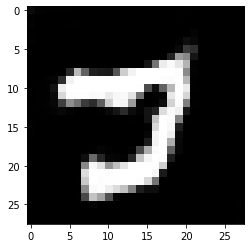

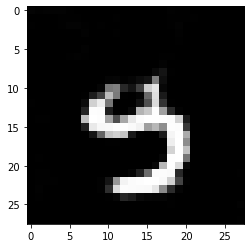

1th iteration gen_loss: 0.29580387473106384 dis_loss: 0.4622849225997925
1th iteration gen_loss: 0.29864710569381714 dis_loss: 0.4329255521297455
1th iteration gen_loss: 0.2770896553993225 dis_loss: 0.42213571071624756
1th iteration gen_loss: 0.2615627348423004 dis_loss: 0.4800357222557068
1th iteration gen_loss: 0.32183530926704407 dis_loss: 0.5221512913703918
1th iteration gen_loss: 0.31946665048599243 dis_loss: 0.47707271575927734
1th iteration gen_loss: 0.31291326880455017 dis_loss: 0.4645727872848511
1th iteration gen_loss: 0.3126153349876404 dis_loss: 0.44363459944725037
1th iteration gen_loss: 0.32153019309043884 dis_loss: 0.43922877311706543
1th iteration gen_loss: 0.2574547529220581 dis_loss: 0.43680471181869507
1th iteration gen_loss: 0.3176242411136627 dis_loss: 0.46992775797843933
1th iteration gen_loss: 0.3320629894733429 dis_loss: 0.47346824407577515


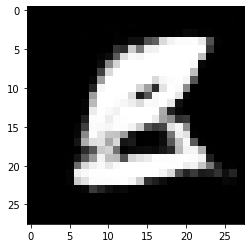

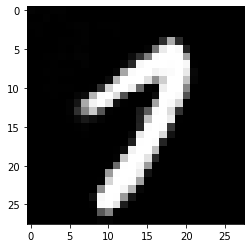

2th iteration gen_loss: 0.27817296981811523 dis_loss: 0.4273941218852997
2th iteration gen_loss: 0.2580290734767914 dis_loss: 0.4693864583969116
2th iteration gen_loss: 0.3143169581890106 dis_loss: 0.4316953420639038
2th iteration gen_loss: 0.31728166341781616 dis_loss: 0.39497897028923035
2th iteration gen_loss: 0.27825862169265747 dis_loss: 0.4270715117454529
2th iteration gen_loss: 0.3007567524909973 dis_loss: 0.4301508665084839
2th iteration gen_loss: 0.2824033796787262 dis_loss: 0.38385552167892456
2th iteration gen_loss: 0.4326325058937073 dis_loss: 0.47623777389526367
2th iteration gen_loss: 0.23965471982955933 dis_loss: 0.43579891324043274
2th iteration gen_loss: 0.3786366879940033 dis_loss: 0.4466288089752197
2th iteration gen_loss: 0.3754070997238159 dis_loss: 0.4651598632335663
2th iteration gen_loss: 0.320265531539917 dis_loss: 0.4566183090209961


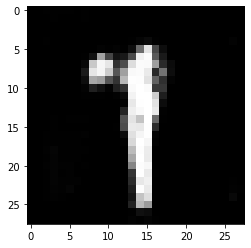

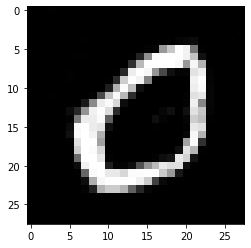

3th iteration gen_loss: 0.2516205608844757 dis_loss: 0.41753020882606506
3th iteration gen_loss: 0.3024531602859497 dis_loss: 0.4784701466560364
3th iteration gen_loss: 0.3256722092628479 dis_loss: 0.3893359303474426
3th iteration gen_loss: 0.2840123474597931 dis_loss: 0.4535272717475891
3th iteration gen_loss: 0.2783757746219635 dis_loss: 0.4613659381866455
3th iteration gen_loss: 0.3500836193561554 dis_loss: 0.46953946352005005
3th iteration gen_loss: 0.31885507702827454 dis_loss: 0.40996670722961426
3th iteration gen_loss: 0.26568296551704407 dis_loss: 0.41235947608947754
3th iteration gen_loss: 0.30168241262435913 dis_loss: 0.4240792393684387
3th iteration gen_loss: 0.32943183183670044 dis_loss: 0.46629756689071655
3th iteration gen_loss: 0.3434399962425232 dis_loss: 0.47673940658569336
3th iteration gen_loss: 0.334115207195282 dis_loss: 0.4576849341392517


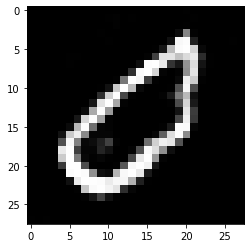

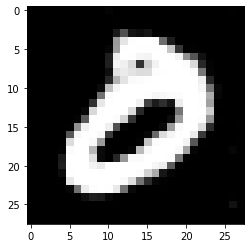

4th iteration gen_loss: 0.43651098012924194 dis_loss: 0.527665376663208
4th iteration gen_loss: 0.35114890336990356 dis_loss: 0.4607161283493042
4th iteration gen_loss: 0.3521159589290619 dis_loss: 0.4380483329296112
4th iteration gen_loss: 0.25681373476982117 dis_loss: 0.45854276418685913
4th iteration gen_loss: 0.3104592263698578 dis_loss: 0.4678492844104767
4th iteration gen_loss: 0.21659831702709198 dis_loss: 0.47798505425453186
4th iteration gen_loss: 0.31690117716789246 dis_loss: 0.4750633239746094
4th iteration gen_loss: 0.38030940294265747 dis_loss: 0.44157013297080994
4th iteration gen_loss: 0.2773282527923584 dis_loss: 0.47425174713134766
4th iteration gen_loss: 0.281274676322937 dis_loss: 0.38836026191711426
4th iteration gen_loss: 0.2537270188331604 dis_loss: 0.4124174416065216
4th iteration gen_loss: 0.29888954758644104 dis_loss: 0.4696510434150696


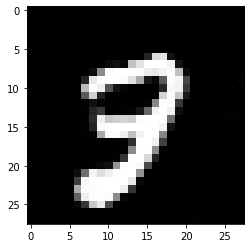

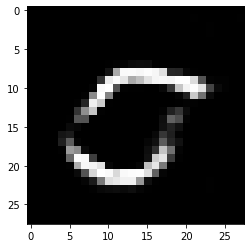

5th iteration gen_loss: 0.3600924611091614 dis_loss: 0.4708309769630432
5th iteration gen_loss: 0.3091824948787689 dis_loss: 0.44534462690353394
5th iteration gen_loss: 0.41615915298461914 dis_loss: 0.5100281238555908
5th iteration gen_loss: 0.25074121356010437 dis_loss: 0.45381003618240356
5th iteration gen_loss: 0.27611199021339417 dis_loss: 0.4297904968261719
5th iteration gen_loss: 0.31877490878105164 dis_loss: 0.39624232053756714
5th iteration gen_loss: 0.35761770606040955 dis_loss: 0.4279097020626068
5th iteration gen_loss: 0.3776020109653473 dis_loss: 0.4711843729019165
5th iteration gen_loss: 0.4303431510925293 dis_loss: 0.4772290587425232
5th iteration gen_loss: 0.2617376744747162 dis_loss: 0.3796181082725525
5th iteration gen_loss: 0.31726351380348206 dis_loss: 0.49303126335144043
5th iteration gen_loss: 0.42817702889442444 dis_loss: 0.44728219509124756


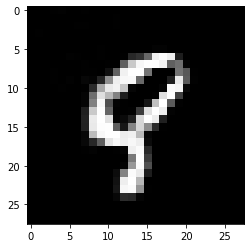

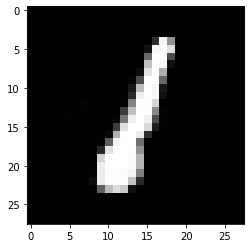

6th iteration gen_loss: 0.30820518732070923 dis_loss: 0.4456654191017151
6th iteration gen_loss: 0.31642577052116394 dis_loss: 0.4612457752227783
6th iteration gen_loss: 0.32730787992477417 dis_loss: 0.4612095355987549
6th iteration gen_loss: 0.3112385869026184 dis_loss: 0.43838775157928467
6th iteration gen_loss: 0.4384087026119232 dis_loss: 0.4145880937576294
6th iteration gen_loss: 0.3341245949268341 dis_loss: 0.45011869072914124
6th iteration gen_loss: 0.3148265480995178 dis_loss: 0.45250582695007324
6th iteration gen_loss: 0.26770880818367004 dis_loss: 0.45837312936782837
6th iteration gen_loss: 0.3162590265274048 dis_loss: 0.46273261308670044
6th iteration gen_loss: 0.3081052601337433 dis_loss: 0.4075450599193573
6th iteration gen_loss: 0.29782599210739136 dis_loss: 0.4553537368774414
6th iteration gen_loss: 0.2560078501701355 dis_loss: 0.3726869523525238


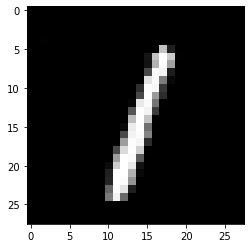

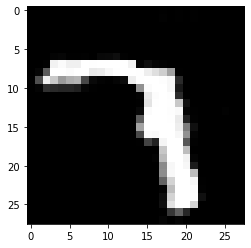

7th iteration gen_loss: 0.3737541139125824 dis_loss: 0.4607101380825043
7th iteration gen_loss: 0.38400503993034363 dis_loss: 0.4397404193878174
7th iteration gen_loss: 0.3147849440574646 dis_loss: 0.4578758478164673
7th iteration gen_loss: 0.4051198363304138 dis_loss: 0.4369257986545563
7th iteration gen_loss: 0.3365974724292755 dis_loss: 0.41247794032096863
7th iteration gen_loss: 0.3556635081768036 dis_loss: 0.4005526900291443
7th iteration gen_loss: 0.2887417674064636 dis_loss: 0.4964517056941986
7th iteration gen_loss: 0.3917379677295685 dis_loss: 0.45745766162872314
7th iteration gen_loss: 0.3643819987773895 dis_loss: 0.4594416618347168
7th iteration gen_loss: 0.4018087685108185 dis_loss: 0.4656534790992737
7th iteration gen_loss: 0.39946848154067993 dis_loss: 0.4682769775390625
7th iteration gen_loss: 0.39144694805145264 dis_loss: 0.3790203332901001


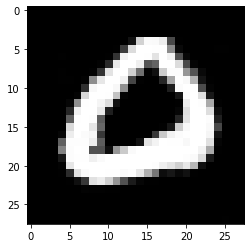

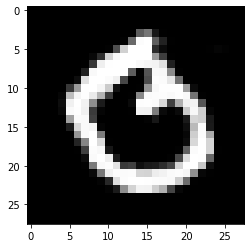

8th iteration gen_loss: 0.41515275835990906 dis_loss: 0.4595748484134674
8th iteration gen_loss: 0.4406677186489105 dis_loss: 0.46953195333480835
8th iteration gen_loss: 0.411996454000473 dis_loss: 0.4347800612449646
8th iteration gen_loss: 0.3470938801765442 dis_loss: 0.47867095470428467
8th iteration gen_loss: 0.3592893183231354 dis_loss: 0.358350545167923
8th iteration gen_loss: 0.3210761845111847 dis_loss: 0.4537298083305359
8th iteration gen_loss: 0.26474466919898987 dis_loss: 0.476824015378952
8th iteration gen_loss: 0.3129301071166992 dis_loss: 0.40736281871795654
8th iteration gen_loss: 0.3834379017353058 dis_loss: 0.4675102233886719
8th iteration gen_loss: 0.3368677496910095 dis_loss: 0.45211493968963623
8th iteration gen_loss: 0.3809303343296051 dis_loss: 0.40678131580352783
8th iteration gen_loss: 0.2786354720592499 dis_loss: 0.45087647438049316


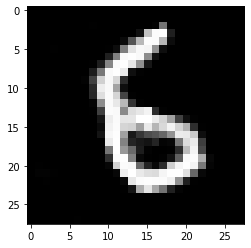

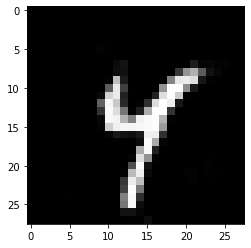

9th iteration gen_loss: 0.35866251587867737 dis_loss: 0.4793950915336609
9th iteration gen_loss: 0.32541632652282715 dis_loss: 0.45617371797561646
9th iteration gen_loss: 0.3497985303401947 dis_loss: 0.45987021923065186
9th iteration gen_loss: 0.3759535253047943 dis_loss: 0.42358213663101196
9th iteration gen_loss: 0.28605401515960693 dis_loss: 0.4011351466178894
9th iteration gen_loss: 0.329192578792572 dis_loss: 0.41010236740112305
9th iteration gen_loss: 0.2754802405834198 dis_loss: 0.42132946848869324
9th iteration gen_loss: 0.2890315353870392 dis_loss: 0.43821898102760315
9th iteration gen_loss: 0.34676939249038696 dis_loss: 0.45120561122894287
9th iteration gen_loss: 0.36264514923095703 dis_loss: 0.4538559317588806
9th iteration gen_loss: 0.25729504227638245 dis_loss: 0.3915281891822815
9th iteration gen_loss: 0.4194081127643585 dis_loss: 0.41927772760391235


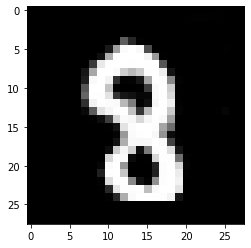

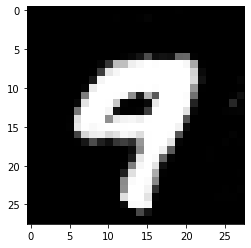

10th iteration gen_loss: 0.2445082813501358 dis_loss: 0.41041648387908936
10th iteration gen_loss: 0.23411399126052856 dis_loss: 0.4836306571960449
10th iteration gen_loss: 0.2923482358455658 dis_loss: 0.4778088927268982
10th iteration gen_loss: 0.3281056880950928 dis_loss: 0.42494314908981323
10th iteration gen_loss: 0.3753381371498108 dis_loss: 0.46097907423973083
10th iteration gen_loss: 0.25224414467811584 dis_loss: 0.48325130343437195
10th iteration gen_loss: 0.29798921942710876 dis_loss: 0.48689204454421997
10th iteration gen_loss: 0.3552100658416748 dis_loss: 0.42747175693511963
10th iteration gen_loss: 0.368941992521286 dis_loss: 0.43661731481552124
10th iteration gen_loss: 0.3448837995529175 dis_loss: 0.44187140464782715
10th iteration gen_loss: 0.3568970859050751 dis_loss: 0.45057326555252075
10th iteration gen_loss: 0.3503364622592926 dis_loss: 0.4465031921863556


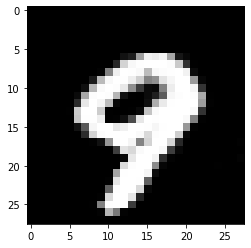

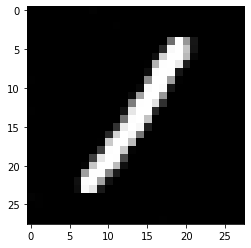

11th iteration gen_loss: 0.3709198534488678 dis_loss: 0.47728273272514343
11th iteration gen_loss: 0.29326558113098145 dis_loss: 0.48105499148368835
11th iteration gen_loss: 0.3953250050544739 dis_loss: 0.42106497287750244
11th iteration gen_loss: 0.2629924714565277 dis_loss: 0.4064044952392578
11th iteration gen_loss: 0.3597647249698639 dis_loss: 0.42722219228744507
11th iteration gen_loss: 0.340105265378952 dis_loss: 0.4590948224067688
11th iteration gen_loss: 0.2902205288410187 dis_loss: 0.40919071435928345
11th iteration gen_loss: 0.24119070172309875 dis_loss: 0.506073534488678
11th iteration gen_loss: 0.38670533895492554 dis_loss: 0.4748194217681885
11th iteration gen_loss: 0.38444197177886963 dis_loss: 0.4806770086288452
11th iteration gen_loss: 0.38765963912010193 dis_loss: 0.4801747798919678
11th iteration gen_loss: 0.30302292108535767 dis_loss: 0.4307065010070801


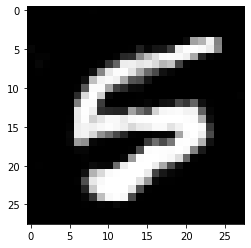

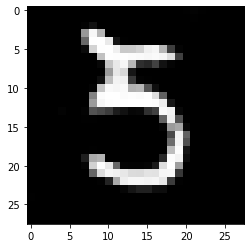

12th iteration gen_loss: 0.2474941909313202 dis_loss: 0.4770199656486511
12th iteration gen_loss: 0.39913564920425415 dis_loss: 0.4563523530960083
12th iteration gen_loss: 0.4018884301185608 dis_loss: 0.3859088122844696
12th iteration gen_loss: 0.26800209283828735 dis_loss: 0.42011740803718567
12th iteration gen_loss: 0.34283849596977234 dis_loss: 0.4367223381996155
12th iteration gen_loss: 0.3560338616371155 dis_loss: 0.45079362392425537
12th iteration gen_loss: 0.26756638288497925 dis_loss: 0.36589664220809937
12th iteration gen_loss: 0.29752397537231445 dis_loss: 0.40904468297958374
12th iteration gen_loss: 0.2066524773836136 dis_loss: 0.42416805028915405
12th iteration gen_loss: 0.32489439845085144 dis_loss: 0.4066697359085083
12th iteration gen_loss: 0.3168010711669922 dis_loss: 0.4320681095123291
12th iteration gen_loss: 0.32941627502441406 dis_loss: 0.39357367157936096


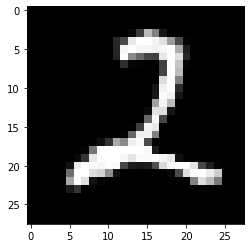

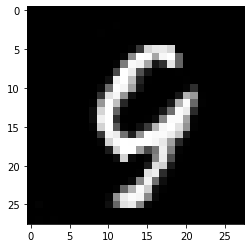

13th iteration gen_loss: 0.31527048349380493 dis_loss: 0.3912237882614136
13th iteration gen_loss: 0.4057386815547943 dis_loss: 0.44690558314323425
13th iteration gen_loss: 0.39104992151260376 dis_loss: 0.47733500599861145
13th iteration gen_loss: 0.3202378749847412 dis_loss: 0.4960075914859772
13th iteration gen_loss: 0.3442867696285248 dis_loss: 0.45487353205680847
13th iteration gen_loss: 0.29193875193595886 dis_loss: 0.40677958726882935
13th iteration gen_loss: 0.37329864501953125 dis_loss: 0.43533962965011597
13th iteration gen_loss: 0.27557989954948425 dis_loss: 0.4812738299369812
13th iteration gen_loss: 0.33493974804878235 dis_loss: 0.4518442153930664
13th iteration gen_loss: 0.2634027898311615 dis_loss: 0.4490812420845032
13th iteration gen_loss: 0.29321756958961487 dis_loss: 0.4802970588207245
13th iteration gen_loss: 0.2890962064266205 dis_loss: 0.4544593095779419


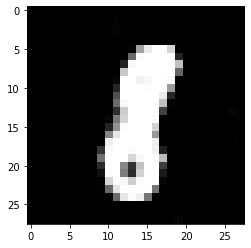

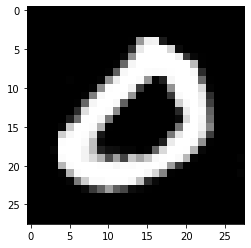

14th iteration gen_loss: 0.31972959637641907 dis_loss: 0.4200183153152466
14th iteration gen_loss: 0.30082812905311584 dis_loss: 0.46095651388168335
14th iteration gen_loss: 0.30709126591682434 dis_loss: 0.4552973210811615
14th iteration gen_loss: 0.33172211050987244 dis_loss: 0.4145135283470154
14th iteration gen_loss: 0.3146054446697235 dis_loss: 0.44566985964775085
14th iteration gen_loss: 0.38490012288093567 dis_loss: 0.44607794284820557
14th iteration gen_loss: 0.35610324144363403 dis_loss: 0.4303426742553711
14th iteration gen_loss: 0.35402023792266846 dis_loss: 0.43671977519989014
14th iteration gen_loss: 0.4390953779220581 dis_loss: 0.4300383925437927
14th iteration gen_loss: 0.3369564712047577 dis_loss: 0.475231409072876
14th iteration gen_loss: 0.3449544906616211 dis_loss: 0.4513317942619324
14th iteration gen_loss: 0.31675535440444946 dis_loss: 0.4439479112625122


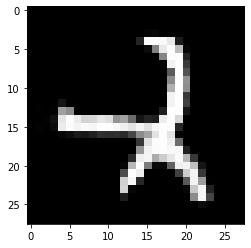

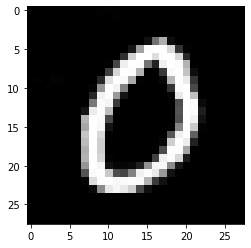

15th iteration gen_loss: 0.32933446764945984 dis_loss: 0.4611530303955078
15th iteration gen_loss: 0.3518521785736084 dis_loss: 0.49230894446372986
15th iteration gen_loss: 0.25807392597198486 dis_loss: 0.48449066281318665
15th iteration gen_loss: 0.3294810354709625 dis_loss: 0.40414974093437195
15th iteration gen_loss: 0.30194875597953796 dis_loss: 0.4469785690307617
15th iteration gen_loss: 0.31119537353515625 dis_loss: 0.4718738794326782
15th iteration gen_loss: 0.37511885166168213 dis_loss: 0.39640170335769653
15th iteration gen_loss: 0.3713778555393219 dis_loss: 0.47823232412338257
15th iteration gen_loss: 0.2683393955230713 dis_loss: 0.5199999809265137
15th iteration gen_loss: 0.2651897370815277 dis_loss: 0.3827994465827942
15th iteration gen_loss: 0.29351478815078735 dis_loss: 0.4551420509815216
15th iteration gen_loss: 0.36527183651924133 dis_loss: 0.4381186366081238


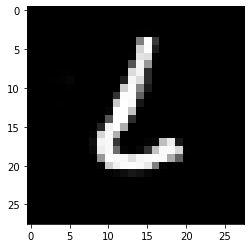

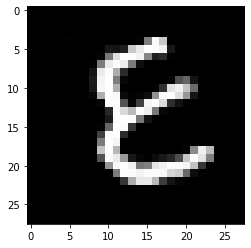

16th iteration gen_loss: 0.3225824236869812 dis_loss: 0.4643305838108063
16th iteration gen_loss: 0.34612277150154114 dis_loss: 0.40851786732673645
16th iteration gen_loss: 0.41245344281196594 dis_loss: 0.4840950667858124
16th iteration gen_loss: 0.3273080289363861 dis_loss: 0.4465755820274353
16th iteration gen_loss: 0.4240153431892395 dis_loss: 0.4658735990524292
16th iteration gen_loss: 0.35428160429000854 dis_loss: 0.4742892384529114
16th iteration gen_loss: 0.4210797846317291 dis_loss: 0.40873420238494873
16th iteration gen_loss: 0.3121188282966614 dis_loss: 0.4981532096862793
16th iteration gen_loss: 0.28608137369155884 dis_loss: 0.48380041122436523
16th iteration gen_loss: 0.34129512310028076 dis_loss: 0.43314695358276367
16th iteration gen_loss: 0.3708457052707672 dis_loss: 0.4618785083293915
16th iteration gen_loss: 0.3098992705345154 dis_loss: 0.44172823429107666


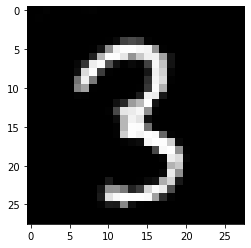

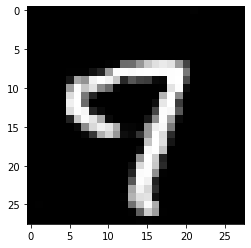

17th iteration gen_loss: 0.3097549378871918 dis_loss: 0.4584674537181854
17th iteration gen_loss: 0.38370269536972046 dis_loss: 0.4426240622997284
17th iteration gen_loss: 0.1981016844511032 dis_loss: 0.4671866297721863
17th iteration gen_loss: 0.3006892800331116 dis_loss: 0.43400880694389343
17th iteration gen_loss: 0.3294224143028259 dis_loss: 0.4717705547809601
17th iteration gen_loss: 0.3868297040462494 dis_loss: 0.4492160677909851
17th iteration gen_loss: 0.272563636302948 dis_loss: 0.45790499448776245
17th iteration gen_loss: 0.40702077746391296 dis_loss: 0.43332439661026
17th iteration gen_loss: 0.3486262559890747 dis_loss: 0.448789119720459
17th iteration gen_loss: 0.22254236042499542 dis_loss: 0.4585835635662079
17th iteration gen_loss: 0.3074627220630646 dis_loss: 0.46111759543418884
17th iteration gen_loss: 0.31555747985839844 dis_loss: 0.45533132553100586


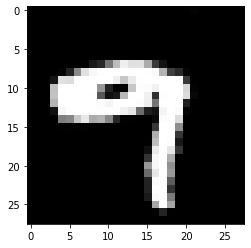

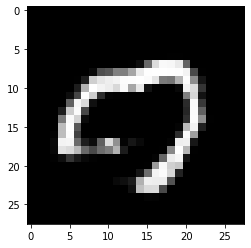

18th iteration gen_loss: 0.31295016407966614 dis_loss: 0.408479779958725
18th iteration gen_loss: 0.3481277525424957 dis_loss: 0.44214701652526855
18th iteration gen_loss: 0.3073078989982605 dis_loss: 0.44324058294296265
18th iteration gen_loss: 0.4185504913330078 dis_loss: 0.43231385946273804
18th iteration gen_loss: 0.31429386138916016 dis_loss: 0.48150211572647095
18th iteration gen_loss: 0.31665658950805664 dis_loss: 0.4669298529624939
18th iteration gen_loss: 0.2610662281513214 dis_loss: 0.4177505373954773
18th iteration gen_loss: 0.2990216612815857 dis_loss: 0.48232734203338623
18th iteration gen_loss: 0.4392906725406647 dis_loss: 0.43606680631637573
18th iteration gen_loss: 0.27000078558921814 dis_loss: 0.49017030000686646
18th iteration gen_loss: 0.2711949050426483 dis_loss: 0.4653294086456299
18th iteration gen_loss: 0.3080257773399353 dis_loss: 0.4638023376464844


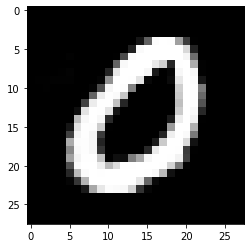

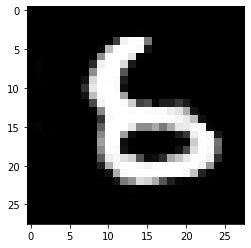

19th iteration gen_loss: 0.393218070268631 dis_loss: 0.4173176884651184
19th iteration gen_loss: 0.2759011387825012 dis_loss: 0.46605730056762695
19th iteration gen_loss: 0.2962723970413208 dis_loss: 0.5160611867904663
19th iteration gen_loss: 0.37387123703956604 dis_loss: 0.48025310039520264
19th iteration gen_loss: 0.34602493047714233 dis_loss: 0.46236228942871094
19th iteration gen_loss: 0.42399078607559204 dis_loss: 0.472673237323761
19th iteration gen_loss: 0.35747459530830383 dis_loss: 0.46852371096611023
19th iteration gen_loss: 0.36182892322540283 dis_loss: 0.43602025508880615
19th iteration gen_loss: 0.3399818241596222 dis_loss: 0.4318245053291321
19th iteration gen_loss: 0.256284236907959 dis_loss: 0.44010454416275024
19th iteration gen_loss: 0.3871361315250397 dis_loss: 0.4404745101928711
19th iteration gen_loss: 0.38468512892723083 dis_loss: 0.49791067838668823


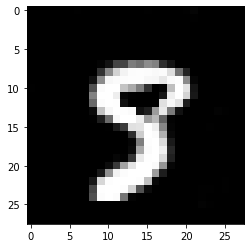

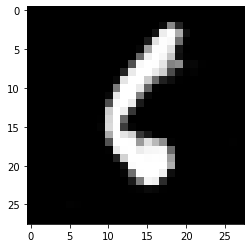

20th iteration gen_loss: 0.2862870693206787 dis_loss: 0.45332714915275574
20th iteration gen_loss: 0.4160814583301544 dis_loss: 0.4874172806739807
20th iteration gen_loss: 0.30041706562042236 dis_loss: 0.4576992988586426
20th iteration gen_loss: 0.3575611114501953 dis_loss: 0.4670505225658417
20th iteration gen_loss: 0.2586495280265808 dis_loss: 0.47758594155311584
20th iteration gen_loss: 0.3657400906085968 dis_loss: 0.43800851702690125
20th iteration gen_loss: 0.3612602949142456 dis_loss: 0.4702199399471283
20th iteration gen_loss: 0.3533613979816437 dis_loss: 0.43661290407180786
20th iteration gen_loss: 0.42926156520843506 dis_loss: 0.4748230576515198
20th iteration gen_loss: 0.25919443368911743 dis_loss: 0.44778525829315186
20th iteration gen_loss: 0.23749980330467224 dis_loss: 0.4762510359287262
20th iteration gen_loss: 0.3198511302471161 dis_loss: 0.46736276149749756


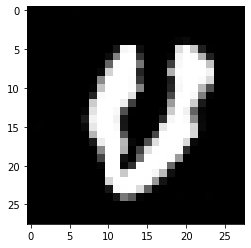

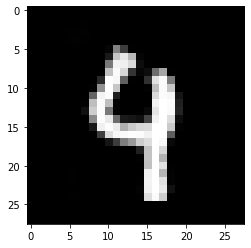

21th iteration gen_loss: 0.33286163210868835 dis_loss: 0.4271742105484009
21th iteration gen_loss: 0.3495558798313141 dis_loss: 0.3703623116016388
21th iteration gen_loss: 0.31870612502098083 dis_loss: 0.4748896360397339
21th iteration gen_loss: 0.32961198687553406 dis_loss: 0.4192163348197937
21th iteration gen_loss: 0.34032759070396423 dis_loss: 0.460362046957016
21th iteration gen_loss: 0.43165943026542664 dis_loss: 0.4235653877258301
21th iteration gen_loss: 0.30130869150161743 dis_loss: 0.43551385402679443
21th iteration gen_loss: 0.3354787230491638 dis_loss: 0.4049702286720276
21th iteration gen_loss: 0.2603699564933777 dis_loss: 0.45976218581199646
21th iteration gen_loss: 0.2387360781431198 dis_loss: 0.45694777369499207
21th iteration gen_loss: 0.22048541903495789 dis_loss: 0.4817427098751068
21th iteration gen_loss: 0.3324182331562042 dis_loss: 0.49596160650253296


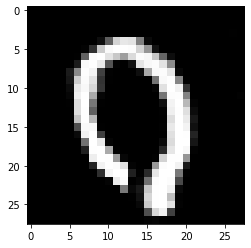

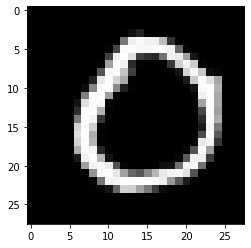

22th iteration gen_loss: 0.40707290172576904 dis_loss: 0.45584529638290405
22th iteration gen_loss: 0.42740100622177124 dis_loss: 0.43038439750671387
22th iteration gen_loss: 0.3616305887699127 dis_loss: 0.4737713932991028
22th iteration gen_loss: 0.3645596206188202 dis_loss: 0.4700433015823364
22th iteration gen_loss: 0.31210917234420776 dis_loss: 0.4514067769050598
22th iteration gen_loss: 0.3749888837337494 dis_loss: 0.4998023509979248
22th iteration gen_loss: 0.27721258997917175 dis_loss: 0.4523894190788269
22th iteration gen_loss: 0.3174571990966797 dis_loss: 0.483312726020813
22th iteration gen_loss: 0.2845817506313324 dis_loss: 0.46440523862838745
22th iteration gen_loss: 0.3898210823535919 dis_loss: 0.4395180642604828
22th iteration gen_loss: 0.3705715537071228 dis_loss: 0.5140409469604492
22th iteration gen_loss: 0.25479525327682495 dis_loss: 0.43657630681991577


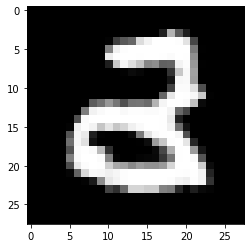

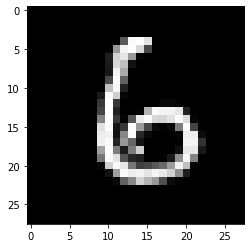

23th iteration gen_loss: 0.27069851756095886 dis_loss: 0.48730623722076416
23th iteration gen_loss: 0.24166342616081238 dis_loss: 0.44844919443130493
23th iteration gen_loss: 0.35994529724121094 dis_loss: 0.4664952754974365
23th iteration gen_loss: 0.38965240120887756 dis_loss: 0.4506789743900299
23th iteration gen_loss: 0.2145516574382782 dis_loss: 0.4276686906814575
23th iteration gen_loss: 0.35790786147117615 dis_loss: 0.49304139614105225
23th iteration gen_loss: 0.33409908413887024 dis_loss: 0.4393395185470581
23th iteration gen_loss: 0.26000750064849854 dis_loss: 0.5208401083946228
23th iteration gen_loss: 0.41286689043045044 dis_loss: 0.48372238874435425
23th iteration gen_loss: 0.29110145568847656 dis_loss: 0.42344146966934204
23th iteration gen_loss: 0.28742948174476624 dis_loss: 0.47083330154418945
23th iteration gen_loss: 0.3615524172782898 dis_loss: 0.44925937056541443


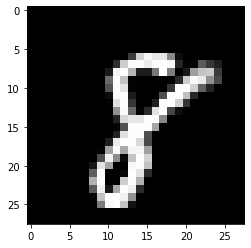

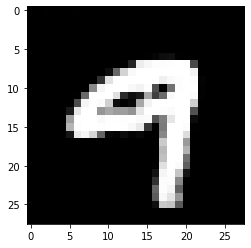

24th iteration gen_loss: 0.28924691677093506 dis_loss: 0.5005366802215576
24th iteration gen_loss: 0.3307275176048279 dis_loss: 0.42555248737335205
24th iteration gen_loss: 0.38553932309150696 dis_loss: 0.45272621512413025
24th iteration gen_loss: 0.29904627799987793 dis_loss: 0.4568658173084259
24th iteration gen_loss: 0.31476902961730957 dis_loss: 0.4390804171562195
24th iteration gen_loss: 0.2752322256565094 dis_loss: 0.43094879388809204
24th iteration gen_loss: 0.28847891092300415 dis_loss: 0.4410114288330078
24th iteration gen_loss: 0.400603711605072 dis_loss: 0.4602065980434418
24th iteration gen_loss: 0.312732070684433 dis_loss: 0.49623364210128784
24th iteration gen_loss: 0.4745173156261444 dis_loss: 0.4425273537635803
24th iteration gen_loss: 0.23826704919338226 dis_loss: 0.3952299952507019
24th iteration gen_loss: 0.18023549020290375 dis_loss: 0.47199469804763794


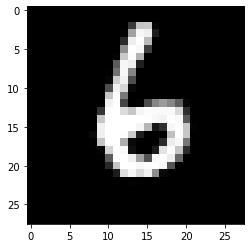

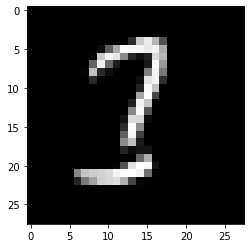

25th iteration gen_loss: 0.3357398808002472 dis_loss: 0.44373059272766113
25th iteration gen_loss: 0.23450477421283722 dis_loss: 0.43809235095977783
25th iteration gen_loss: 0.307872474193573 dis_loss: 0.4345192015171051
25th iteration gen_loss: 0.2967902421951294 dis_loss: 0.40809714794158936
25th iteration gen_loss: 0.2834358215332031 dis_loss: 0.45430922508239746
25th iteration gen_loss: 0.4093989431858063 dis_loss: 0.5101695656776428
25th iteration gen_loss: 0.3348004221916199 dis_loss: 0.48029419779777527
25th iteration gen_loss: 0.22563031315803528 dis_loss: 0.406860888004303
25th iteration gen_loss: 0.17978350818157196 dis_loss: 0.416715145111084
25th iteration gen_loss: 0.3201766908168793 dis_loss: 0.4821881055831909
25th iteration gen_loss: 0.2987481653690338 dis_loss: 0.4398331046104431
25th iteration gen_loss: 0.24527953565120697 dis_loss: 0.4438244700431824


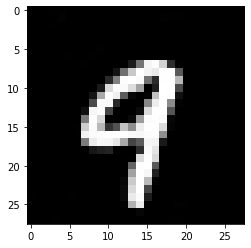

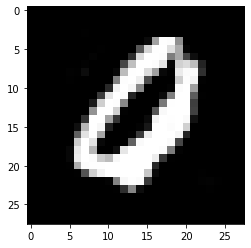

26th iteration gen_loss: 0.27105921506881714 dis_loss: 0.4344484210014343
26th iteration gen_loss: 0.26009801030158997 dis_loss: 0.44502347707748413
26th iteration gen_loss: 0.3156600594520569 dis_loss: 0.44209837913513184
26th iteration gen_loss: 0.30053824186325073 dis_loss: 0.38933229446411133
26th iteration gen_loss: 0.1669175624847412 dis_loss: 0.4721534848213196
26th iteration gen_loss: 0.4021996855735779 dis_loss: 0.45759326219558716
26th iteration gen_loss: 0.2926691770553589 dis_loss: 0.44045066833496094
26th iteration gen_loss: 0.3688139319419861 dis_loss: 0.4640282094478607
26th iteration gen_loss: 0.31404393911361694 dis_loss: 0.44385218620300293
26th iteration gen_loss: 0.403543621301651 dis_loss: 0.4429031014442444
26th iteration gen_loss: 0.28442785143852234 dis_loss: 0.39422374963760376
26th iteration gen_loss: 0.41234496235847473 dis_loss: 0.4868967533111572


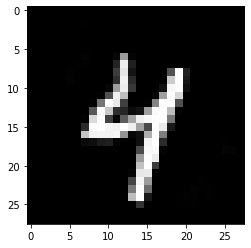

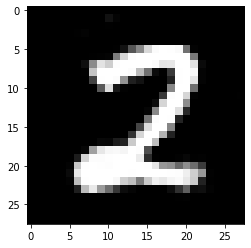

27th iteration gen_loss: 0.2837814390659332 dis_loss: 0.446223646402359
27th iteration gen_loss: 0.37866324186325073 dis_loss: 0.3621160387992859
27th iteration gen_loss: 0.37724143266677856 dis_loss: 0.425137996673584
27th iteration gen_loss: 0.37468284368515015 dis_loss: 0.4581027030944824
27th iteration gen_loss: 0.2195696383714676 dis_loss: 0.43813711404800415
27th iteration gen_loss: 0.26312655210494995 dis_loss: 0.4894901514053345
27th iteration gen_loss: 0.3714631199836731 dis_loss: 0.47144991159439087
27th iteration gen_loss: 0.3557574450969696 dis_loss: 0.4196457266807556
27th iteration gen_loss: 0.37350738048553467 dis_loss: 0.45170027017593384
27th iteration gen_loss: 0.3023776113986969 dis_loss: 0.551586389541626
27th iteration gen_loss: 0.24849514663219452 dis_loss: 0.4310832619667053
27th iteration gen_loss: 0.35020652413368225 dis_loss: 0.46847623586654663


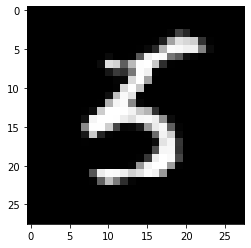

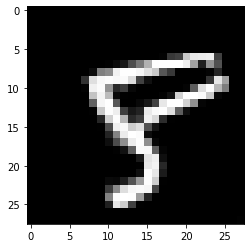

28th iteration gen_loss: 0.31689944863319397 dis_loss: 0.4503054618835449
28th iteration gen_loss: 0.37555959820747375 dis_loss: 0.4675527811050415
28th iteration gen_loss: 0.2078590989112854 dis_loss: 0.4539996385574341
28th iteration gen_loss: 0.29412731528282166 dis_loss: 0.4286949038505554
28th iteration gen_loss: 0.3217252194881439 dis_loss: 0.46132978796958923
28th iteration gen_loss: 0.2880876958370209 dis_loss: 0.5117779970169067
28th iteration gen_loss: 0.3207308053970337 dis_loss: 0.5454275012016296
28th iteration gen_loss: 0.3477608263492584 dis_loss: 0.4331371784210205
28th iteration gen_loss: 0.23448878526687622 dis_loss: 0.44272688031196594
28th iteration gen_loss: 0.325452983379364 dis_loss: 0.5264537334442139
28th iteration gen_loss: 0.3198327422142029 dis_loss: 0.4298411011695862
28th iteration gen_loss: 0.33508333563804626 dis_loss: 0.4468154311180115


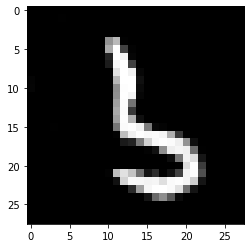

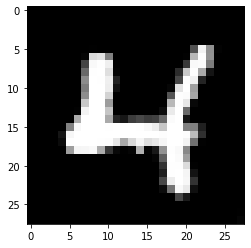

29th iteration gen_loss: 0.23824302852153778 dis_loss: 0.39308762550354004
29th iteration gen_loss: 0.24811623990535736 dis_loss: 0.4799397587776184
29th iteration gen_loss: 0.3364383578300476 dis_loss: 0.4361647367477417
29th iteration gen_loss: 0.3512285053730011 dis_loss: 0.5488215684890747
29th iteration gen_loss: 0.37762975692749023 dis_loss: 0.45639777183532715
29th iteration gen_loss: 0.2685144245624542 dis_loss: 0.469968318939209
29th iteration gen_loss: 0.3924287259578705 dis_loss: 0.476893812417984
29th iteration gen_loss: 0.33205679059028625 dis_loss: 0.4495794177055359
29th iteration gen_loss: 0.22222991287708282 dis_loss: 0.5514270067214966
29th iteration gen_loss: 0.3694848418235779 dis_loss: 0.4518936574459076
29th iteration gen_loss: 0.2553235590457916 dis_loss: 0.4559273421764374
29th iteration gen_loss: 0.2531525492668152 dis_loss: 0.4523288607597351


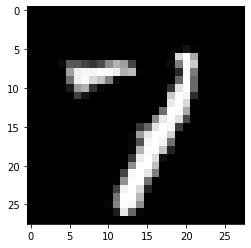

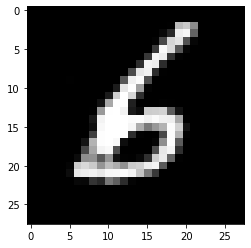

30th iteration gen_loss: 0.36289718747138977 dis_loss: 0.47735655307769775
30th iteration gen_loss: 0.30635350942611694 dis_loss: 0.46078479290008545
30th iteration gen_loss: 0.32223790884017944 dis_loss: 0.4662224352359772
30th iteration gen_loss: 0.33940571546554565 dis_loss: 0.41060054302215576
30th iteration gen_loss: 0.49997568130493164 dis_loss: 0.434482216835022
30th iteration gen_loss: 0.2344335913658142 dis_loss: 0.4252506494522095
30th iteration gen_loss: 0.35304510593414307 dis_loss: 0.4231404662132263
30th iteration gen_loss: 0.43920817971229553 dis_loss: 0.4715327024459839
30th iteration gen_loss: 0.3380744755268097 dis_loss: 0.43255800008773804
30th iteration gen_loss: 0.2571592628955841 dis_loss: 0.4611467719078064
30th iteration gen_loss: 0.17173129320144653 dis_loss: 0.5356061458587646
30th iteration gen_loss: 0.3817499577999115 dis_loss: 0.45691102743148804


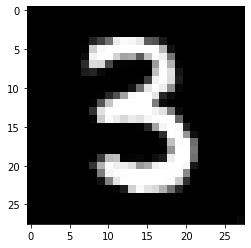

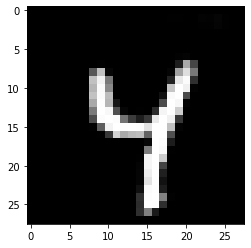

31th iteration gen_loss: 0.3818928003311157 dis_loss: 0.4300166070461273
31th iteration gen_loss: 0.2668285071849823 dis_loss: 0.42746078968048096
31th iteration gen_loss: 0.2792645990848541 dis_loss: 0.44798290729522705
31th iteration gen_loss: 0.4158656895160675 dis_loss: 0.4540860056877136
31th iteration gen_loss: 0.26118871569633484 dis_loss: 0.48070257902145386
31th iteration gen_loss: 0.3675893247127533 dis_loss: 0.43449169397354126
31th iteration gen_loss: 0.3514010012149811 dis_loss: 0.4228435754776001
31th iteration gen_loss: 0.3289649188518524 dis_loss: 0.4692370295524597
31th iteration gen_loss: 0.4298924505710602 dis_loss: 0.4223663806915283
31th iteration gen_loss: 0.38983264565467834 dis_loss: 0.4646722376346588
31th iteration gen_loss: 0.2857690155506134 dis_loss: 0.48116737604141235
31th iteration gen_loss: 0.3545635938644409 dis_loss: 0.43398767709732056


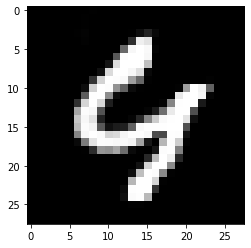

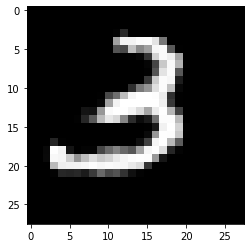

32th iteration gen_loss: 0.29026541113853455 dis_loss: 0.4727526307106018
32th iteration gen_loss: 0.37079277634620667 dis_loss: 0.48185020685195923
32th iteration gen_loss: 0.2643737494945526 dis_loss: 0.471282422542572
32th iteration gen_loss: 0.3630065321922302 dis_loss: 0.41476500034332275
32th iteration gen_loss: 0.3017428517341614 dis_loss: 0.39575791358947754
32th iteration gen_loss: 0.290932297706604 dis_loss: 0.453189492225647
32th iteration gen_loss: 0.2523561120033264 dis_loss: 0.4447740614414215
32th iteration gen_loss: 0.32604312896728516 dis_loss: 0.4627283811569214
32th iteration gen_loss: 0.37400248646736145 dis_loss: 0.4564996659755707
32th iteration gen_loss: 0.33297407627105713 dis_loss: 0.44469350576400757
32th iteration gen_loss: 0.32740646600723267 dis_loss: 0.4520593285560608
32th iteration gen_loss: 0.2862054109573364 dis_loss: 0.4633452296257019


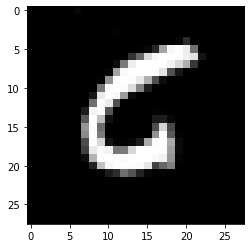

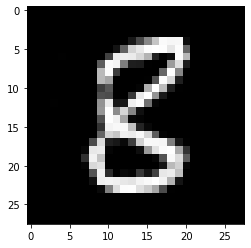

33th iteration gen_loss: 0.2959679663181305 dis_loss: 0.490601122379303
33th iteration gen_loss: 0.29325273633003235 dis_loss: 0.43162429332733154
33th iteration gen_loss: 0.3654903769493103 dis_loss: 0.4270109534263611
33th iteration gen_loss: 0.2859562337398529 dis_loss: 0.468296617269516
33th iteration gen_loss: 0.5028371214866638 dis_loss: 0.4489184617996216
33th iteration gen_loss: 0.33292242884635925 dis_loss: 0.4327530264854431
33th iteration gen_loss: 0.28744396567344666 dis_loss: 0.4831334948539734
33th iteration gen_loss: 0.3224724531173706 dis_loss: 0.4782674312591553
33th iteration gen_loss: 0.2399628609418869 dis_loss: 0.48886120319366455
33th iteration gen_loss: 0.291446715593338 dis_loss: 0.4828893542289734
33th iteration gen_loss: 0.29142454266548157 dis_loss: 0.48158934712409973
33th iteration gen_loss: 0.3104465901851654 dis_loss: 0.4147776663303375


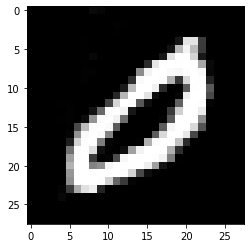

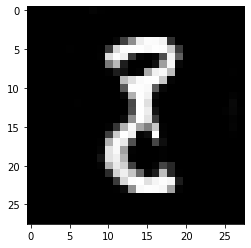

34th iteration gen_loss: 0.26307249069213867 dis_loss: 0.4450356960296631
34th iteration gen_loss: 0.20991551876068115 dis_loss: 0.4903464913368225
34th iteration gen_loss: 0.2801261842250824 dis_loss: 0.41764307022094727
34th iteration gen_loss: 0.23770026862621307 dis_loss: 0.4432834982872009
34th iteration gen_loss: 0.334450900554657 dis_loss: 0.4420924484729767
34th iteration gen_loss: 0.36517104506492615 dis_loss: 0.4925824701786041
34th iteration gen_loss: 0.3515302538871765 dis_loss: 0.46251732110977173
34th iteration gen_loss: 0.33572134375572205 dis_loss: 0.4379497766494751
34th iteration gen_loss: 0.2746797204017639 dis_loss: 0.3789742588996887
34th iteration gen_loss: 0.2416684925556183 dis_loss: 0.47277262806892395
34th iteration gen_loss: 0.2584851086139679 dis_loss: 0.45529818534851074
34th iteration gen_loss: 0.3331977427005768 dis_loss: 0.45447659492492676


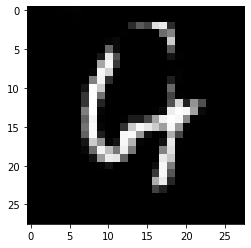

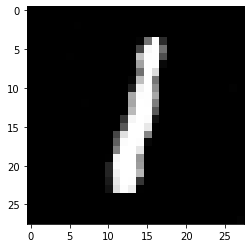

35th iteration gen_loss: 0.37002047896385193 dis_loss: 0.4450221061706543
35th iteration gen_loss: 0.37599602341651917 dis_loss: 0.48421692848205566
35th iteration gen_loss: 0.29497283697128296 dis_loss: 0.4482514262199402
35th iteration gen_loss: 0.3931487500667572 dis_loss: 0.46260932087898254
35th iteration gen_loss: 0.3987136781215668 dis_loss: 0.5148919224739075
35th iteration gen_loss: 0.35259872674942017 dis_loss: 0.42902082204818726
35th iteration gen_loss: 0.28921014070510864 dis_loss: 0.4667435586452484
35th iteration gen_loss: 0.3047668933868408 dis_loss: 0.43726804852485657
35th iteration gen_loss: 0.30230480432510376 dis_loss: 0.4877188801765442
35th iteration gen_loss: 0.2923182547092438 dis_loss: 0.43490540981292725
35th iteration gen_loss: 0.41462820768356323 dis_loss: 0.467883825302124
35th iteration gen_loss: 0.31194812059402466 dis_loss: 0.45905810594558716


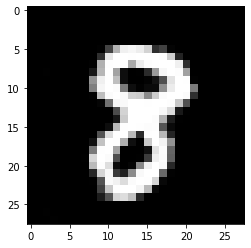

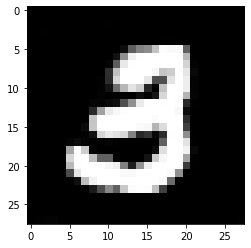

36th iteration gen_loss: 0.3566684126853943 dis_loss: 0.4007682204246521
36th iteration gen_loss: 0.34404468536376953 dis_loss: 0.4499598741531372
36th iteration gen_loss: 0.33843815326690674 dis_loss: 0.5098541378974915
36th iteration gen_loss: 0.24996057152748108 dis_loss: 0.45637136697769165
36th iteration gen_loss: 0.4172787666320801 dis_loss: 0.4234989285469055
36th iteration gen_loss: 0.38892602920532227 dis_loss: 0.43837282061576843
36th iteration gen_loss: 0.4317169189453125 dis_loss: 0.45200997591018677
36th iteration gen_loss: 0.31065359711647034 dis_loss: 0.4425952434539795
36th iteration gen_loss: 0.21889427304267883 dis_loss: 0.48763102293014526
36th iteration gen_loss: 0.38246574997901917 dis_loss: 0.4939071536064148
36th iteration gen_loss: 0.20365090668201447 dis_loss: 0.43975114822387695
36th iteration gen_loss: 0.4245862364768982 dis_loss: 0.537257969379425


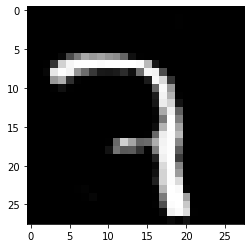

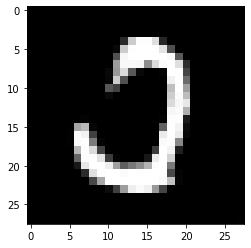

37th iteration gen_loss: 0.3147459328174591 dis_loss: 0.4897710084915161
37th iteration gen_loss: 0.33350229263305664 dis_loss: 0.35229501128196716
37th iteration gen_loss: 0.38013139367103577 dis_loss: 0.4872626066207886
37th iteration gen_loss: 0.3645678162574768 dis_loss: 0.4257284104824066
37th iteration gen_loss: 0.33753615617752075 dis_loss: 0.43192386627197266
37th iteration gen_loss: 0.3052651286125183 dis_loss: 0.42660924792289734
37th iteration gen_loss: 0.41441044211387634 dis_loss: 0.48400193452835083
37th iteration gen_loss: 0.34517279267311096 dis_loss: 0.46673375368118286
37th iteration gen_loss: 0.26616060733795166 dis_loss: 0.495356023311615
37th iteration gen_loss: 0.34966063499450684 dis_loss: 0.46429359912872314
37th iteration gen_loss: 0.2523527145385742 dis_loss: 0.5194265246391296
37th iteration gen_loss: 0.4185936748981476 dis_loss: 0.410469114780426


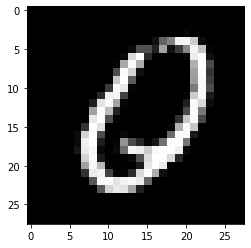

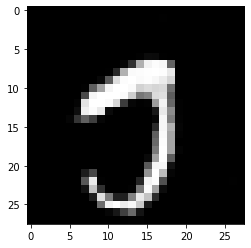

38th iteration gen_loss: 0.37261566519737244 dis_loss: 0.4347658157348633
38th iteration gen_loss: 0.3629686236381531 dis_loss: 0.42137762904167175
38th iteration gen_loss: 0.4330962300300598 dis_loss: 0.44986671209335327
38th iteration gen_loss: 0.24005621671676636 dis_loss: 0.41663846373558044
38th iteration gen_loss: 0.31471702456474304 dis_loss: 0.45628607273101807
38th iteration gen_loss: 0.34476858377456665 dis_loss: 0.45915454626083374
38th iteration gen_loss: 0.4386955499649048 dis_loss: 0.4787976145744324
38th iteration gen_loss: 0.3549816906452179 dis_loss: 0.46498236060142517
38th iteration gen_loss: 0.3586992919445038 dis_loss: 0.4839634597301483
38th iteration gen_loss: 0.30379268527030945 dis_loss: 0.4310525059700012
38th iteration gen_loss: 0.3326400816440582 dis_loss: 0.44417333602905273
38th iteration gen_loss: 0.28368398547172546 dis_loss: 0.46585971117019653


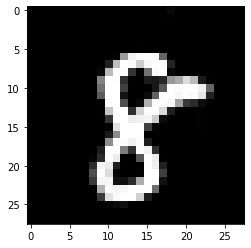

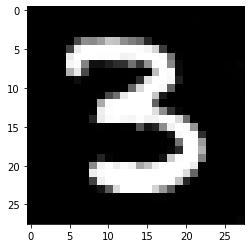

39th iteration gen_loss: 0.4064933657646179 dis_loss: 0.45813751220703125
39th iteration gen_loss: 0.32212549448013306 dis_loss: 0.4788327217102051
39th iteration gen_loss: 0.4528149366378784 dis_loss: 0.4577227830886841
39th iteration gen_loss: 0.3911473751068115 dis_loss: 0.47474104166030884
39th iteration gen_loss: 0.32394835352897644 dis_loss: 0.4168052077293396
39th iteration gen_loss: 0.27490317821502686 dis_loss: 0.41952764987945557
39th iteration gen_loss: 0.3561265766620636 dis_loss: 0.4121223986148834
39th iteration gen_loss: 0.40334340929985046 dis_loss: 0.45572707056999207
39th iteration gen_loss: 0.2437707632780075 dis_loss: 0.43657970428466797
39th iteration gen_loss: 0.28354090452194214 dis_loss: 0.4392012357711792
39th iteration gen_loss: 0.34569305181503296 dis_loss: 0.42218345403671265
39th iteration gen_loss: 0.3041708171367645 dis_loss: 0.41393357515335083


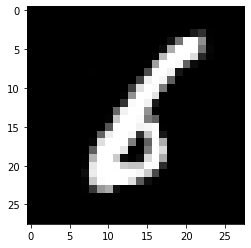

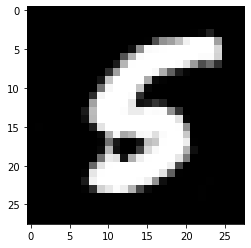

40th iteration gen_loss: 0.2042320966720581 dis_loss: 0.4932929277420044
40th iteration gen_loss: 0.26558974385261536 dis_loss: 0.4482138752937317
40th iteration gen_loss: 0.32731708884239197 dis_loss: 0.4401512145996094
40th iteration gen_loss: 0.2632458508014679 dis_loss: 0.49213266372680664
40th iteration gen_loss: 0.220646932721138 dis_loss: 0.46904242038726807
40th iteration gen_loss: 0.3030519187450409 dis_loss: 0.4269603192806244
40th iteration gen_loss: 0.3841974437236786 dis_loss: 0.5008448362350464
40th iteration gen_loss: 0.3392483592033386 dis_loss: 0.44181254506111145
40th iteration gen_loss: 0.26147541403770447 dis_loss: 0.49928849935531616
40th iteration gen_loss: 0.37082639336586 dis_loss: 0.4471931457519531
40th iteration gen_loss: 0.21754144132137299 dis_loss: 0.4568994343280792
40th iteration gen_loss: 0.30273640155792236 dis_loss: 0.41840875148773193


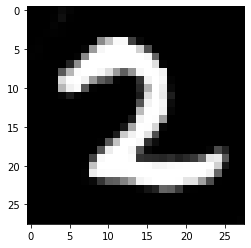

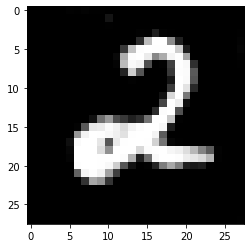

41th iteration gen_loss: 0.3468032479286194 dis_loss: 0.43408042192459106
41th iteration gen_loss: 0.21238933503627777 dis_loss: 0.5405979156494141
41th iteration gen_loss: 0.34906211495399475 dis_loss: 0.44935381412506104
41th iteration gen_loss: 0.3070509135723114 dis_loss: 0.577895998954773
41th iteration gen_loss: 0.28648948669433594 dis_loss: 0.451753705739975
41th iteration gen_loss: 0.2631571292877197 dis_loss: 0.4515293836593628
41th iteration gen_loss: 0.25136202573776245 dis_loss: 0.43797263503074646
41th iteration gen_loss: 0.31751716136932373 dis_loss: 0.5000693202018738
41th iteration gen_loss: 0.37762001156806946 dis_loss: 0.4801819920539856
41th iteration gen_loss: 0.31061679124832153 dis_loss: 0.4440152049064636
41th iteration gen_loss: 0.28377625346183777 dis_loss: 0.4426685571670532
41th iteration gen_loss: 0.4945966303348541 dis_loss: 0.49337995052337646


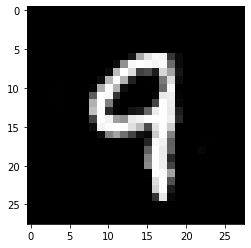

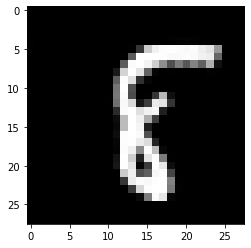

42th iteration gen_loss: 0.27263447642326355 dis_loss: 0.4430510401725769
42th iteration gen_loss: 0.33746570348739624 dis_loss: 0.4299898147583008
42th iteration gen_loss: 0.38816800713539124 dis_loss: 0.43270444869995117
42th iteration gen_loss: 0.339604914188385 dis_loss: 0.47186219692230225
42th iteration gen_loss: 0.4397231340408325 dis_loss: 0.4136114716529846
42th iteration gen_loss: 0.2944324314594269 dis_loss: 0.4867500066757202
42th iteration gen_loss: 0.2818879783153534 dis_loss: 0.4360016882419586
42th iteration gen_loss: 0.35087257623672485 dis_loss: 0.40632906556129456
42th iteration gen_loss: 0.3155534267425537 dis_loss: 0.4192579984664917
42th iteration gen_loss: 0.3106030225753784 dis_loss: 0.4695659577846527
42th iteration gen_loss: 0.3522254228591919 dis_loss: 0.4649687707424164
42th iteration gen_loss: 0.4005599915981293 dis_loss: 0.4704980254173279


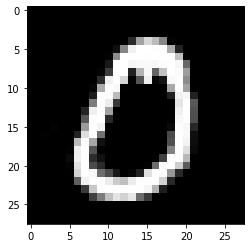

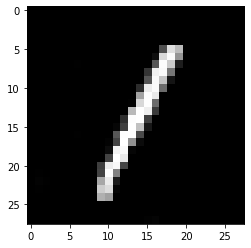

43th iteration gen_loss: 0.30110833048820496 dis_loss: 0.4378344416618347
43th iteration gen_loss: 0.29868361353874207 dis_loss: 0.5364450216293335
43th iteration gen_loss: 0.3967404067516327 dis_loss: 0.4192202687263489
43th iteration gen_loss: 0.44408079981803894 dis_loss: 0.420865923166275
43th iteration gen_loss: 0.3210180997848511 dis_loss: 0.467079758644104
43th iteration gen_loss: 0.34537941217422485 dis_loss: 0.5092813968658447
43th iteration gen_loss: 0.22764787077903748 dis_loss: 0.5006845593452454
43th iteration gen_loss: 0.30662474036216736 dis_loss: 0.4245820641517639
43th iteration gen_loss: 0.2786119878292084 dis_loss: 0.43664276599884033
43th iteration gen_loss: 0.46260523796081543 dis_loss: 0.4644242823123932
43th iteration gen_loss: 0.2388029843568802 dis_loss: 0.4218139052391052
43th iteration gen_loss: 0.2772314250469208 dis_loss: 0.4711340665817261


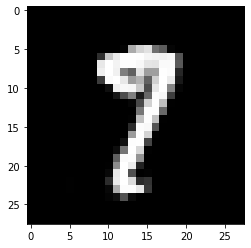

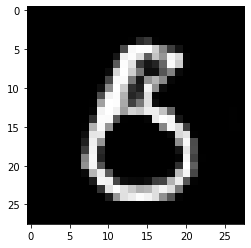

44th iteration gen_loss: 0.27043628692626953 dis_loss: 0.48325109481811523
44th iteration gen_loss: 0.31732484698295593 dis_loss: 0.4218294620513916
44th iteration gen_loss: 0.2809324264526367 dis_loss: 0.4400295913219452
44th iteration gen_loss: 0.3173876404762268 dis_loss: 0.47253865003585815
44th iteration gen_loss: 0.3325263261795044 dis_loss: 0.5372327566146851
44th iteration gen_loss: 0.3810199201107025 dis_loss: 0.47402822971343994
44th iteration gen_loss: 0.23582807183265686 dis_loss: 0.4483869671821594
44th iteration gen_loss: 0.35811081528663635 dis_loss: 0.45295587182044983
44th iteration gen_loss: 0.23889152705669403 dis_loss: 0.4490840435028076
44th iteration gen_loss: 0.26575642824172974 dis_loss: 0.48013201355934143
44th iteration gen_loss: 0.2458619624376297 dis_loss: 0.4847787618637085
44th iteration gen_loss: 0.3285742998123169 dis_loss: 0.4606447219848633


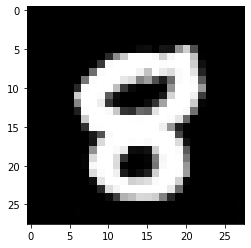

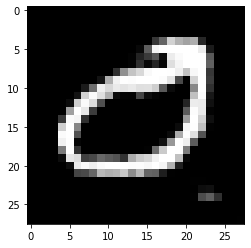

45th iteration gen_loss: 0.4167275130748749 dis_loss: 0.4517061114311218
45th iteration gen_loss: 0.25691720843315125 dis_loss: 0.48461443185806274
45th iteration gen_loss: 0.31472048163414 dis_loss: 0.42186009883880615
45th iteration gen_loss: 0.25209054350852966 dis_loss: 0.5134925842285156
45th iteration gen_loss: 0.22261779010295868 dis_loss: 0.4615210294723511
45th iteration gen_loss: 0.2500532567501068 dis_loss: 0.5035817623138428
45th iteration gen_loss: 0.3204076290130615 dis_loss: 0.45270293951034546
45th iteration gen_loss: 0.5006128549575806 dis_loss: 0.45955991744995117
45th iteration gen_loss: 0.27360254526138306 dis_loss: 0.41435950994491577
45th iteration gen_loss: 0.27302855253219604 dis_loss: 0.4505373239517212
45th iteration gen_loss: 0.3549697697162628 dis_loss: 0.4426267743110657
45th iteration gen_loss: 0.30946898460388184 dis_loss: 0.538861095905304


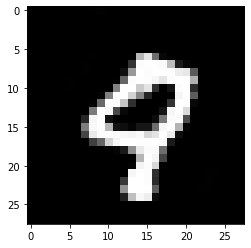

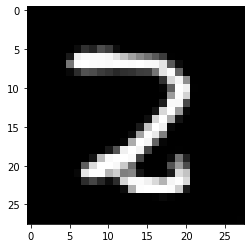

46th iteration gen_loss: 0.26691603660583496 dis_loss: 0.43300196528434753
46th iteration gen_loss: 0.2559176981449127 dis_loss: 0.5148724913597107
46th iteration gen_loss: 0.35153067111968994 dis_loss: 0.450152188539505
46th iteration gen_loss: 0.30900734663009644 dis_loss: 0.44122403860092163
46th iteration gen_loss: 0.34106841683387756 dis_loss: 0.4301733672618866
46th iteration gen_loss: 0.37425002455711365 dis_loss: 0.47045260667800903
46th iteration gen_loss: 0.3550240099430084 dis_loss: 0.4501836895942688
46th iteration gen_loss: 0.34857410192489624 dis_loss: 0.43038231134414673
46th iteration gen_loss: 0.3796040117740631 dis_loss: 0.4795154929161072
46th iteration gen_loss: 0.28784963488578796 dis_loss: 0.5369493961334229
46th iteration gen_loss: 0.31463921070098877 dis_loss: 0.46371984481811523
46th iteration gen_loss: 0.3887980878353119 dis_loss: 0.45464015007019043


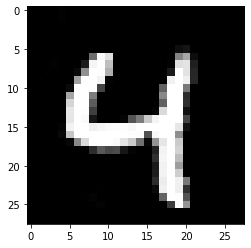

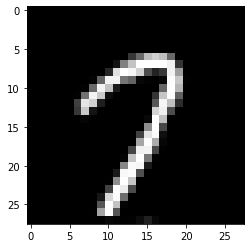

47th iteration gen_loss: 0.31926998496055603 dis_loss: 0.41195279359817505
47th iteration gen_loss: 0.34816911816596985 dis_loss: 0.4949915409088135
47th iteration gen_loss: 0.3690657615661621 dis_loss: 0.4482458233833313
47th iteration gen_loss: 0.32280805706977844 dis_loss: 0.4268012046813965
47th iteration gen_loss: 0.31834104657173157 dis_loss: 0.44166600704193115
47th iteration gen_loss: 0.26353010535240173 dis_loss: 0.4696009159088135
47th iteration gen_loss: 0.2709202468395233 dis_loss: 0.5031867027282715
47th iteration gen_loss: 0.4211196005344391 dis_loss: 0.42178407311439514
47th iteration gen_loss: 0.34722888469696045 dis_loss: 0.407457172870636
47th iteration gen_loss: 0.38582631945610046 dis_loss: 0.48287856578826904
47th iteration gen_loss: 0.2751745283603668 dis_loss: 0.46543362736701965
47th iteration gen_loss: 0.3879797160625458 dis_loss: 0.4317381680011749


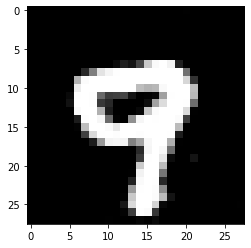

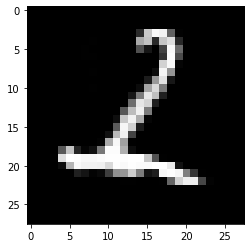

48th iteration gen_loss: 0.31329986453056335 dis_loss: 0.4257172644138336
48th iteration gen_loss: 0.33710426092147827 dis_loss: 0.4554487466812134
48th iteration gen_loss: 0.4065391421318054 dis_loss: 0.47038981318473816
48th iteration gen_loss: 0.3429679870605469 dis_loss: 0.46434009075164795
48th iteration gen_loss: 0.2660565972328186 dis_loss: 0.4611334502696991
48th iteration gen_loss: 0.25434210896492004 dis_loss: 0.44552910327911377
48th iteration gen_loss: 0.3339870274066925 dis_loss: 0.48356926441192627
48th iteration gen_loss: 0.2083217054605484 dis_loss: 0.5006691813468933
48th iteration gen_loss: 0.1786520928144455 dis_loss: 0.4973997175693512
48th iteration gen_loss: 0.3153306543827057 dis_loss: 0.4373614490032196
48th iteration gen_loss: 0.4004337191581726 dis_loss: 0.45010727643966675
48th iteration gen_loss: 0.3429248332977295 dis_loss: 0.39993852376937866


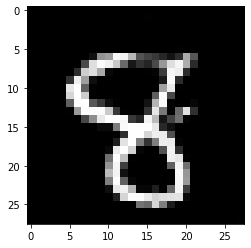

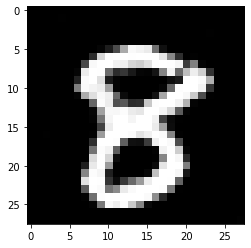

49th iteration gen_loss: 0.2513313293457031 dis_loss: 0.5304830074310303
49th iteration gen_loss: 0.3582881987094879 dis_loss: 0.47335249185562134
49th iteration gen_loss: 0.30878573656082153 dis_loss: 0.4214319586753845
49th iteration gen_loss: 0.3404613137245178 dis_loss: 0.45641201734542847
49th iteration gen_loss: 0.3109148144721985 dis_loss: 0.36752140522003174
49th iteration gen_loss: 0.31897982954978943 dis_loss: 0.35196226835250854
49th iteration gen_loss: 0.23316287994384766 dis_loss: 0.4601154625415802
49th iteration gen_loss: 0.3048820495605469 dis_loss: 0.4833061695098877
49th iteration gen_loss: 0.4938097298145294 dis_loss: 0.47484394907951355
49th iteration gen_loss: 0.39526939392089844 dis_loss: 0.4505844712257385
49th iteration gen_loss: 0.2066037356853485 dis_loss: 0.48113077878952026
49th iteration gen_loss: 0.3062138557434082 dis_loss: 0.4905362129211426


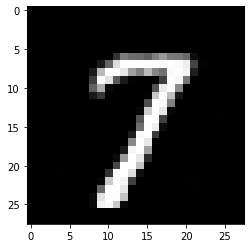

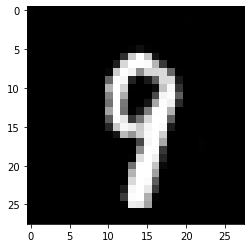

50th iteration gen_loss: 0.33050957322120667 dis_loss: 0.4816615581512451
50th iteration gen_loss: 0.36925727128982544 dis_loss: 0.4698711335659027
50th iteration gen_loss: 0.330124169588089 dis_loss: 0.5055216550827026
50th iteration gen_loss: 0.2721850872039795 dis_loss: 0.4659413695335388
50th iteration gen_loss: 0.2895045280456543 dis_loss: 0.5092776417732239
50th iteration gen_loss: 0.2980062663555145 dis_loss: 0.4956539273262024
50th iteration gen_loss: 0.24164699018001556 dis_loss: 0.48655587434768677
50th iteration gen_loss: 0.36152756214141846 dis_loss: 0.4565519690513611
50th iteration gen_loss: 0.43650877475738525 dis_loss: 0.4180460572242737
50th iteration gen_loss: 0.35227707028388977 dis_loss: 0.44778528809547424
50th iteration gen_loss: 0.2224416881799698 dis_loss: 0.5035467147827148
50th iteration gen_loss: 0.2371421754360199 dis_loss: 0.5175164341926575


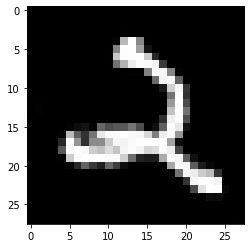

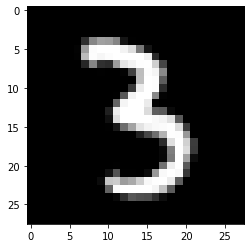

51th iteration gen_loss: 0.332608163356781 dis_loss: 0.4381619989871979
51th iteration gen_loss: 0.16274547576904297 dis_loss: 0.5225087404251099
51th iteration gen_loss: 0.33072853088378906 dis_loss: 0.47008055448532104
51th iteration gen_loss: 0.36769285798072815 dis_loss: 0.473599910736084
51th iteration gen_loss: 0.2784898579120636 dis_loss: 0.45965102314949036
51th iteration gen_loss: 0.3627619445323944 dis_loss: 0.46798306703567505
51th iteration gen_loss: 0.2893349826335907 dis_loss: 0.4540822207927704
51th iteration gen_loss: 0.30607616901397705 dis_loss: 0.3912953734397888
51th iteration gen_loss: 0.2737466096878052 dis_loss: 0.47122836112976074
51th iteration gen_loss: 0.4443516433238983 dis_loss: 0.4272536337375641
51th iteration gen_loss: 0.2951579689979553 dis_loss: 0.5069152116775513
51th iteration gen_loss: 0.28919854760169983 dis_loss: 0.5420357584953308


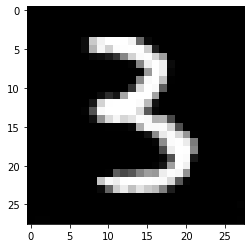

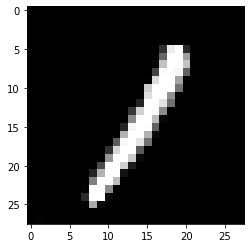

52th iteration gen_loss: 0.3016601800918579 dis_loss: 0.4032258987426758
52th iteration gen_loss: 0.29084110260009766 dis_loss: 0.5125529170036316
52th iteration gen_loss: 0.3937399685382843 dis_loss: 0.42904072999954224
52th iteration gen_loss: 0.3608708083629608 dis_loss: 0.47222745418548584
52th iteration gen_loss: 0.3656214773654938 dis_loss: 0.4774744510650635
52th iteration gen_loss: 0.2731989622116089 dis_loss: 0.4893158972263336
52th iteration gen_loss: 0.40052175521850586 dis_loss: 0.4761204719543457
52th iteration gen_loss: 0.27236586809158325 dis_loss: 0.428310751914978
52th iteration gen_loss: 0.36614805459976196 dis_loss: 0.4419138431549072
52th iteration gen_loss: 0.34273117780685425 dis_loss: 0.47177761793136597
52th iteration gen_loss: 0.2649514973163605 dis_loss: 0.4512844681739807
52th iteration gen_loss: 0.2784842550754547 dis_loss: 0.481869637966156


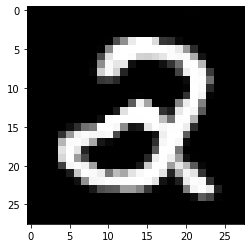

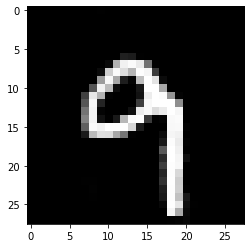

53th iteration gen_loss: 0.42035409808158875 dis_loss: 0.47525855898857117
53th iteration gen_loss: 0.33336395025253296 dis_loss: 0.46534842252731323
53th iteration gen_loss: 0.2647639513015747 dis_loss: 0.464913010597229
53th iteration gen_loss: 0.3081139326095581 dis_loss: 0.4675416946411133
53th iteration gen_loss: 0.30966588854789734 dis_loss: 0.5304135084152222
53th iteration gen_loss: 0.38805919885635376 dis_loss: 0.4765496253967285
53th iteration gen_loss: 0.2781579792499542 dis_loss: 0.47326233983039856
53th iteration gen_loss: 0.2984981834888458 dis_loss: 0.41721197962760925
53th iteration gen_loss: 0.3242732286453247 dis_loss: 0.4775242805480957
53th iteration gen_loss: 0.2735738456249237 dis_loss: 0.487812340259552
53th iteration gen_loss: 0.1609608680009842 dis_loss: 0.5248044729232788
53th iteration gen_loss: 0.2886802554130554 dis_loss: 0.386849582195282


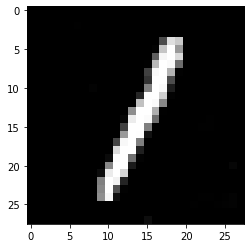

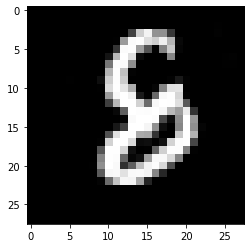

54th iteration gen_loss: 0.35341060161590576 dis_loss: 0.5050844550132751
54th iteration gen_loss: 0.31643033027648926 dis_loss: 0.44917750358581543
54th iteration gen_loss: 0.27231207489967346 dis_loss: 0.37999415397644043
54th iteration gen_loss: 0.2807280421257019 dis_loss: 0.4015248417854309
54th iteration gen_loss: 0.32818153500556946 dis_loss: 0.4375492334365845
54th iteration gen_loss: 0.3583688735961914 dis_loss: 0.45461875200271606
54th iteration gen_loss: 0.33714666962623596 dis_loss: 0.4642118811607361
54th iteration gen_loss: 0.36939120292663574 dis_loss: 0.43693262338638306
54th iteration gen_loss: 0.29312118887901306 dis_loss: 0.41743117570877075
54th iteration gen_loss: 0.31230229139328003 dis_loss: 0.436140775680542
54th iteration gen_loss: 0.307431697845459 dis_loss: 0.47401654720306396
54th iteration gen_loss: 0.26001909375190735 dis_loss: 0.4445286989212036


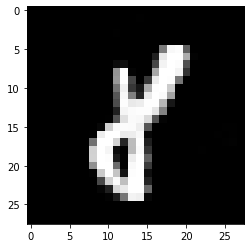

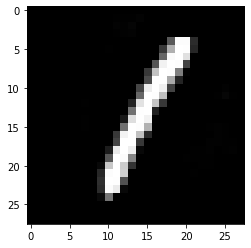

55th iteration gen_loss: 0.3768741488456726 dis_loss: 0.4490758776664734
55th iteration gen_loss: 0.296019583940506 dis_loss: 0.4887406826019287
55th iteration gen_loss: 0.351204514503479 dis_loss: 0.489101767539978
55th iteration gen_loss: 0.3433384597301483 dis_loss: 0.45153385400772095
55th iteration gen_loss: 0.20979492366313934 dis_loss: 0.41368719935417175
55th iteration gen_loss: 0.2474372386932373 dis_loss: 0.44751420617103577
55th iteration gen_loss: 0.2823725938796997 dis_loss: 0.44153761863708496
55th iteration gen_loss: 0.40189558267593384 dis_loss: 0.3898252248764038
55th iteration gen_loss: 0.3048986494541168 dis_loss: 0.4617183804512024
55th iteration gen_loss: 0.2989863157272339 dis_loss: 0.45143845677375793
55th iteration gen_loss: 0.2692404091358185 dis_loss: 0.42183566093444824
55th iteration gen_loss: 0.41028693318367004 dis_loss: 0.48399099707603455


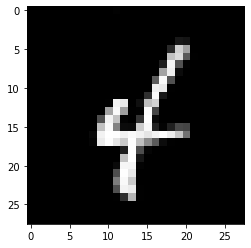

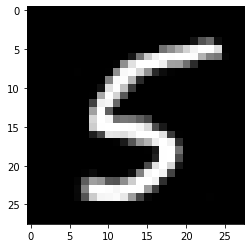

56th iteration gen_loss: 0.28617241978645325 dis_loss: 0.45858436822891235
56th iteration gen_loss: 0.37883058190345764 dis_loss: 0.4593254327774048
56th iteration gen_loss: 0.1944320648908615 dis_loss: 0.4614364802837372
56th iteration gen_loss: 0.2718965411186218 dis_loss: 0.4312496781349182
56th iteration gen_loss: 0.27345010638237 dis_loss: 0.48051363229751587
56th iteration gen_loss: 0.24300816655158997 dis_loss: 0.4419863820075989
56th iteration gen_loss: 0.3141464293003082 dis_loss: 0.39940452575683594
56th iteration gen_loss: 0.2511637210845947 dis_loss: 0.4413001537322998
56th iteration gen_loss: 0.3907880187034607 dis_loss: 0.5331590175628662
56th iteration gen_loss: 0.28755173087120056 dis_loss: 0.47807973623275757
56th iteration gen_loss: 0.26983314752578735 dis_loss: 0.4755887985229492
56th iteration gen_loss: 0.21498042345046997 dis_loss: 0.5048381686210632


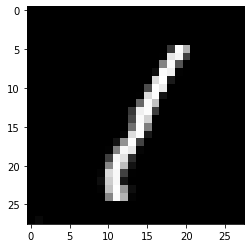

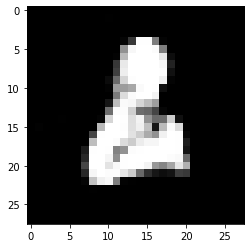

57th iteration gen_loss: 0.2793464660644531 dis_loss: 0.48434776067733765
57th iteration gen_loss: 0.32051509618759155 dis_loss: 0.4789779782295227
57th iteration gen_loss: 0.29297757148742676 dis_loss: 0.5221085548400879
57th iteration gen_loss: 0.23774659633636475 dis_loss: 0.530759334564209
57th iteration gen_loss: 0.3060297667980194 dis_loss: 0.4467417001724243
57th iteration gen_loss: 0.3398366868495941 dis_loss: 0.36158332228660583
57th iteration gen_loss: 0.2390824407339096 dis_loss: 0.4444342255592346
57th iteration gen_loss: 0.45916807651519775 dis_loss: 0.45960676670074463
57th iteration gen_loss: 0.37017694115638733 dis_loss: 0.44043341279029846
57th iteration gen_loss: 0.22210389375686646 dis_loss: 0.4638376235961914
57th iteration gen_loss: 0.3402888774871826 dis_loss: 0.4998360872268677
57th iteration gen_loss: 0.36073195934295654 dis_loss: 0.46723195910453796


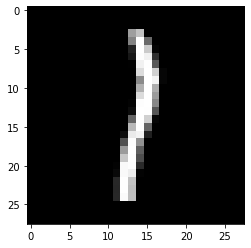

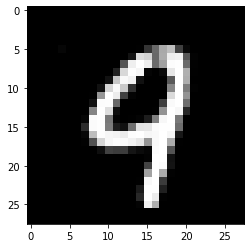

58th iteration gen_loss: 0.38127416372299194 dis_loss: 0.45374274253845215
58th iteration gen_loss: 0.4000113606452942 dis_loss: 0.4523848295211792
58th iteration gen_loss: 0.3004325330257416 dis_loss: 0.4776343107223511
58th iteration gen_loss: 0.39876285195350647 dis_loss: 0.4172915816307068
58th iteration gen_loss: 0.31391090154647827 dis_loss: 0.46931058168411255
58th iteration gen_loss: 0.32191935181617737 dis_loss: 0.4295980930328369
58th iteration gen_loss: 0.4079527258872986 dis_loss: 0.47820794582366943
58th iteration gen_loss: 0.40775084495544434 dis_loss: 0.41667717695236206
58th iteration gen_loss: 0.26880884170532227 dis_loss: 0.46389055252075195
58th iteration gen_loss: 0.32375186681747437 dis_loss: 0.4845865070819855
58th iteration gen_loss: 0.21768587827682495 dis_loss: 0.5107783675193787
58th iteration gen_loss: 0.37608569860458374 dis_loss: 0.4196469187736511


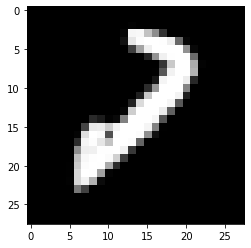

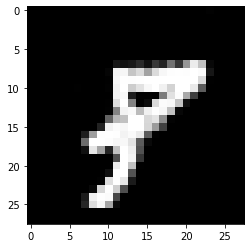

59th iteration gen_loss: 0.26889824867248535 dis_loss: 0.43834784626960754
59th iteration gen_loss: 0.30540895462036133 dis_loss: 0.4465322494506836
59th iteration gen_loss: 0.23349963128566742 dis_loss: 0.37283051013946533
59th iteration gen_loss: 0.41957172751426697 dis_loss: 0.5185297727584839
59th iteration gen_loss: 0.31423330307006836 dis_loss: 0.4363952577114105
59th iteration gen_loss: 0.21869833767414093 dis_loss: 0.4368833899497986
59th iteration gen_loss: 0.38027194142341614 dis_loss: 0.48766499757766724
59th iteration gen_loss: 0.30533525347709656 dis_loss: 0.42175379395484924
59th iteration gen_loss: 0.2923552989959717 dis_loss: 0.46466588973999023
59th iteration gen_loss: 0.21886798739433289 dis_loss: 0.4193493127822876
59th iteration gen_loss: 0.28041872382164 dis_loss: 0.4427803158760071
59th iteration gen_loss: 0.4130873680114746 dis_loss: 0.5069452524185181


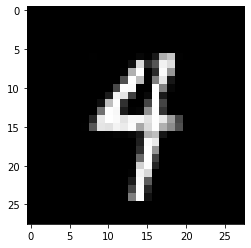

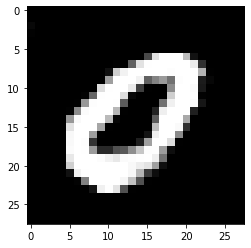

60th iteration gen_loss: 0.3126574754714966 dis_loss: 0.44216179847717285
60th iteration gen_loss: 0.3876769542694092 dis_loss: 0.41955816745758057
60th iteration gen_loss: 0.34163612127304077 dis_loss: 0.4187966585159302
60th iteration gen_loss: 0.3519546389579773 dis_loss: 0.48222583532333374
60th iteration gen_loss: 0.24924695491790771 dis_loss: 0.45552122592926025
60th iteration gen_loss: 0.32159096002578735 dis_loss: 0.5115651488304138
60th iteration gen_loss: 0.24111320078372955 dis_loss: 0.4537423849105835
60th iteration gen_loss: 0.350768506526947 dis_loss: 0.46259021759033203
60th iteration gen_loss: 0.3555428683757782 dis_loss: 0.5700298547744751
60th iteration gen_loss: 0.2641875147819519 dis_loss: 0.5273314118385315
60th iteration gen_loss: 0.3435335159301758 dis_loss: 0.4618039131164551
60th iteration gen_loss: 0.3866523802280426 dis_loss: 0.4513295590877533


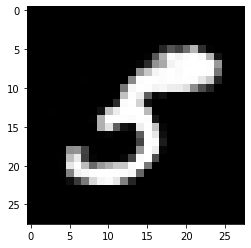

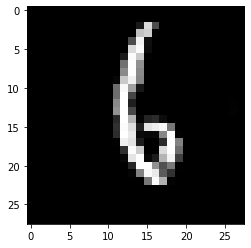

61th iteration gen_loss: 0.30684444308280945 dis_loss: 0.44833001494407654
61th iteration gen_loss: 0.3973076641559601 dis_loss: 0.42907363176345825
61th iteration gen_loss: 0.2760156989097595 dis_loss: 0.47537699341773987
61th iteration gen_loss: 0.31572431325912476 dis_loss: 0.4974241852760315
61th iteration gen_loss: 0.29145973920822144 dis_loss: 0.44078007340431213
61th iteration gen_loss: 0.3110087215900421 dis_loss: 0.42799800634384155
61th iteration gen_loss: 0.2723989486694336 dis_loss: 0.4729849398136139
61th iteration gen_loss: 0.28018131852149963 dis_loss: 0.5046393275260925
61th iteration gen_loss: 0.23047222197055817 dis_loss: 0.467885285615921
61th iteration gen_loss: 0.3499576449394226 dis_loss: 0.46834754943847656
61th iteration gen_loss: 0.29471659660339355 dis_loss: 0.484274685382843
61th iteration gen_loss: 0.3016809821128845 dis_loss: 0.4489385485649109


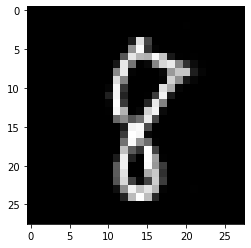

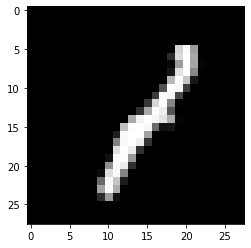

62th iteration gen_loss: 0.4244832396507263 dis_loss: 0.44351500272750854
62th iteration gen_loss: 0.3033387064933777 dis_loss: 0.48539435863494873
62th iteration gen_loss: 0.2874138653278351 dis_loss: 0.4905242323875427
62th iteration gen_loss: 0.41255447268486023 dis_loss: 0.4450991153717041
62th iteration gen_loss: 0.3612372577190399 dis_loss: 0.45839089155197144
62th iteration gen_loss: 0.3041549324989319 dis_loss: 0.5027419328689575
62th iteration gen_loss: 0.34321528673171997 dis_loss: 0.4887511730194092
62th iteration gen_loss: 0.3157035708427429 dis_loss: 0.4304201900959015
62th iteration gen_loss: 0.2628370523452759 dis_loss: 0.43622657656669617
62th iteration gen_loss: 0.2645581066608429 dis_loss: 0.5364031791687012
62th iteration gen_loss: 0.36593517661094666 dis_loss: 0.47621846199035645
62th iteration gen_loss: 0.38387805223464966 dis_loss: 0.5507888793945312


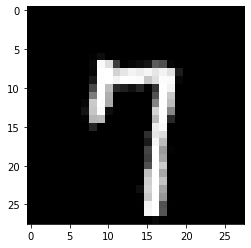

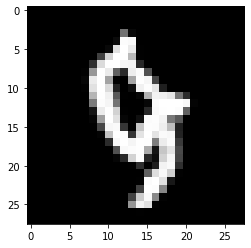

63th iteration gen_loss: 0.31140127778053284 dis_loss: 0.46395838260650635
63th iteration gen_loss: 0.3314162790775299 dis_loss: 0.43907856941223145
63th iteration gen_loss: 0.30406492948532104 dis_loss: 0.4730880856513977
63th iteration gen_loss: 0.2611452639102936 dis_loss: 0.491759717464447
63th iteration gen_loss: 0.2922472059726715 dis_loss: 0.45599156618118286
63th iteration gen_loss: 0.3274601995944977 dis_loss: 0.40127652883529663
63th iteration gen_loss: 0.316656231880188 dis_loss: 0.49086588621139526
63th iteration gen_loss: 0.33491119742393494 dis_loss: 0.42627614736557007
63th iteration gen_loss: 0.2789342701435089 dis_loss: 0.49012571573257446
63th iteration gen_loss: 0.3730907440185547 dis_loss: 0.4512523412704468
63th iteration gen_loss: 0.30803748965263367 dis_loss: 0.40871697664260864
63th iteration gen_loss: 0.2576877176761627 dis_loss: 0.4310852289199829


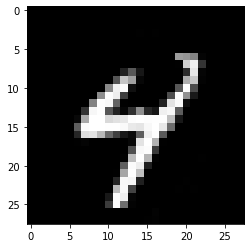

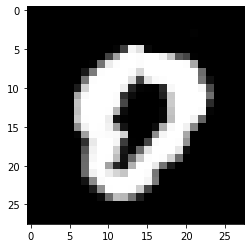

64th iteration gen_loss: 0.3177751302719116 dis_loss: 0.43216514587402344
64th iteration gen_loss: 0.2835432291030884 dis_loss: 0.4503418803215027
64th iteration gen_loss: 0.28503626585006714 dis_loss: 0.45055708289146423
64th iteration gen_loss: 0.2520729899406433 dis_loss: 0.45212504267692566
64th iteration gen_loss: 0.3719959855079651 dis_loss: 0.539718508720398
64th iteration gen_loss: 0.3393019735813141 dis_loss: 0.4736107587814331
64th iteration gen_loss: 0.30301469564437866 dis_loss: 0.47568613290786743
64th iteration gen_loss: 0.23536765575408936 dis_loss: 0.4315127730369568
64th iteration gen_loss: 0.39836767315864563 dis_loss: 0.4534439146518707
64th iteration gen_loss: 0.36061567068099976 dis_loss: 0.5445011258125305
64th iteration gen_loss: 0.27670252323150635 dis_loss: 0.5266846418380737
64th iteration gen_loss: 0.35194873809814453 dis_loss: 0.474540114402771


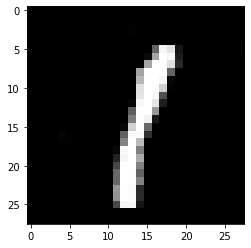

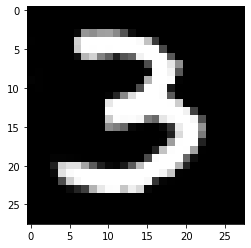

65th iteration gen_loss: 0.18393437564373016 dis_loss: 0.5168161988258362
65th iteration gen_loss: 0.3041854500770569 dis_loss: 0.4124891757965088
65th iteration gen_loss: 0.4189966917037964 dis_loss: 0.4315078854560852
65th iteration gen_loss: 0.3073349595069885 dis_loss: 0.434090256690979
65th iteration gen_loss: 0.29887574911117554 dis_loss: 0.4726831316947937
65th iteration gen_loss: 0.3423200249671936 dis_loss: 0.44976872205734253
65th iteration gen_loss: 0.22376252710819244 dis_loss: 0.5042568445205688
65th iteration gen_loss: 0.24125231802463531 dis_loss: 0.42165759205818176
65th iteration gen_loss: 0.2335585504770279 dis_loss: 0.4966387152671814
65th iteration gen_loss: 0.3790324032306671 dis_loss: 0.4119022786617279
65th iteration gen_loss: 0.36417272686958313 dis_loss: 0.5026735663414001
65th iteration gen_loss: 0.2957592308521271 dis_loss: 0.4407057762145996


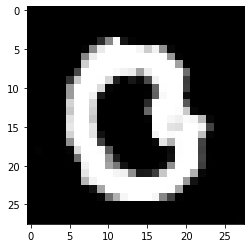

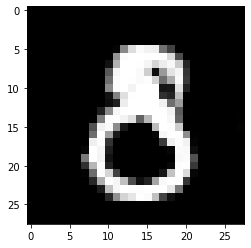

66th iteration gen_loss: 0.2586051821708679 dis_loss: 0.4755208492279053
66th iteration gen_loss: 0.24156612157821655 dis_loss: 0.42810994386672974
66th iteration gen_loss: 0.28528687357902527 dis_loss: 0.4715133309364319
66th iteration gen_loss: 0.2852984666824341 dis_loss: 0.47281157970428467
66th iteration gen_loss: 0.20194491744041443 dis_loss: 0.40541499853134155
66th iteration gen_loss: 0.2978938817977905 dis_loss: 0.4770921468734741
66th iteration gen_loss: 0.2225130796432495 dis_loss: 0.4854464530944824
66th iteration gen_loss: 0.40412023663520813 dis_loss: 0.48426973819732666
66th iteration gen_loss: 0.2019200474023819 dis_loss: 0.4590293765068054
66th iteration gen_loss: 0.34007957577705383 dis_loss: 0.35232383012771606
66th iteration gen_loss: 0.26973792910575867 dis_loss: 0.4689432978630066
66th iteration gen_loss: 0.31934258341789246 dis_loss: 0.4268530011177063


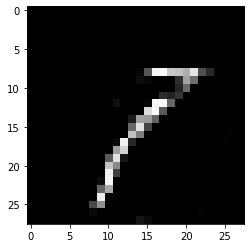

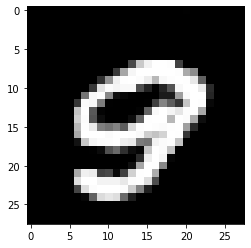

67th iteration gen_loss: 0.35631582140922546 dis_loss: 0.4431118667125702
67th iteration gen_loss: 0.3353480398654938 dis_loss: 0.4501931965351105
67th iteration gen_loss: 0.27391958236694336 dis_loss: 0.41128218173980713
67th iteration gen_loss: 0.3089292347431183 dis_loss: 0.4228408932685852
67th iteration gen_loss: 0.2647591233253479 dis_loss: 0.5049067735671997
67th iteration gen_loss: 0.3608818054199219 dis_loss: 0.4205467700958252
67th iteration gen_loss: 0.40824729204177856 dis_loss: 0.5768736600875854
67th iteration gen_loss: 0.2217104732990265 dis_loss: 0.48008978366851807
67th iteration gen_loss: 0.2104531079530716 dis_loss: 0.5362156629562378
67th iteration gen_loss: 0.2597391903400421 dis_loss: 0.4901807904243469
67th iteration gen_loss: 0.35382217168807983 dis_loss: 0.3953644335269928
67th iteration gen_loss: 0.24628300964832306 dis_loss: 0.47731369733810425


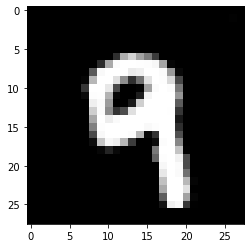

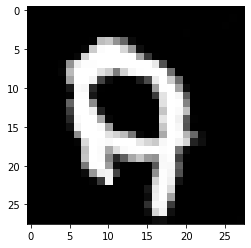

68th iteration gen_loss: 0.4934242069721222 dis_loss: 0.43705934286117554
68th iteration gen_loss: 0.2599451243877411 dis_loss: 0.3832855522632599
68th iteration gen_loss: 0.37898826599121094 dis_loss: 0.4280317425727844
68th iteration gen_loss: 0.3063296377658844 dis_loss: 0.41389352083206177
68th iteration gen_loss: 0.3385964035987854 dis_loss: 0.47527366876602173
68th iteration gen_loss: 0.3094852864742279 dis_loss: 0.4954242706298828
68th iteration gen_loss: 0.15802590548992157 dis_loss: 0.49247708916664124
68th iteration gen_loss: 0.3245958983898163 dis_loss: 0.42910653352737427
68th iteration gen_loss: 0.3425735831260681 dis_loss: 0.3936005234718323
68th iteration gen_loss: 0.3994258940219879 dis_loss: 0.4094991981983185
68th iteration gen_loss: 0.43482956290245056 dis_loss: 0.46408766508102417
68th iteration gen_loss: 0.3874897062778473 dis_loss: 0.4653785824775696


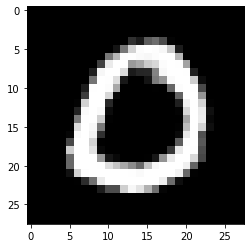

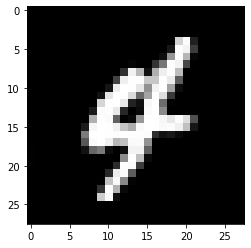

69th iteration gen_loss: 0.3795863389968872 dis_loss: 0.41509824991226196
69th iteration gen_loss: 0.34954553842544556 dis_loss: 0.4489167630672455
69th iteration gen_loss: 0.30970898270606995 dis_loss: 0.4516294598579407
69th iteration gen_loss: 0.32000696659088135 dis_loss: 0.4369303584098816
69th iteration gen_loss: 0.2884645164012909 dis_loss: 0.47711676359176636
69th iteration gen_loss: 0.34376922249794006 dis_loss: 0.40653735399246216
69th iteration gen_loss: 0.2635253965854645 dis_loss: 0.4359126687049866
69th iteration gen_loss: 0.3489835262298584 dis_loss: 0.4494810104370117
69th iteration gen_loss: 0.26376286149024963 dis_loss: 0.4881119132041931
69th iteration gen_loss: 0.261564701795578 dis_loss: 0.4902428984642029
69th iteration gen_loss: 0.3049640953540802 dis_loss: 0.4970749318599701
69th iteration gen_loss: 0.40682491660118103 dis_loss: 0.4297526180744171


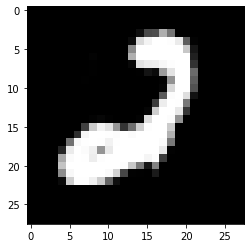

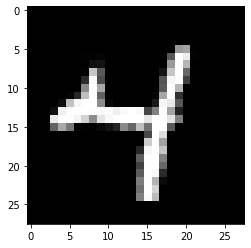

70th iteration gen_loss: 0.41162803769111633 dis_loss: 0.5410066246986389
70th iteration gen_loss: 0.27928683161735535 dis_loss: 0.448840856552124
70th iteration gen_loss: 0.47303712368011475 dis_loss: 0.44288867712020874
70th iteration gen_loss: 0.3300119638442993 dis_loss: 0.48289090394973755
70th iteration gen_loss: 0.2530783414840698 dis_loss: 0.4153008460998535
70th iteration gen_loss: 0.3076740503311157 dis_loss: 0.4131450653076172
70th iteration gen_loss: 0.3384167551994324 dis_loss: 0.44259172677993774
70th iteration gen_loss: 0.298374205827713 dis_loss: 0.47644567489624023
70th iteration gen_loss: 0.2415069341659546 dis_loss: 0.47415149211883545
70th iteration gen_loss: 0.4901945888996124 dis_loss: 0.4794043302536011
70th iteration gen_loss: 0.27230003476142883 dis_loss: 0.5070651173591614
70th iteration gen_loss: 0.34483814239501953 dis_loss: 0.45107853412628174


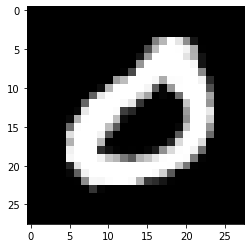

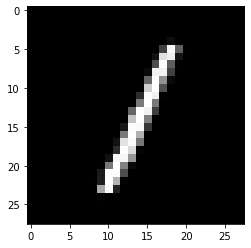

71th iteration gen_loss: 0.29660072922706604 dis_loss: 0.47373339533805847
71th iteration gen_loss: 0.414419025182724 dis_loss: 0.4708453416824341
71th iteration gen_loss: 0.34545671939849854 dis_loss: 0.5148176550865173
71th iteration gen_loss: 0.2960264980792999 dis_loss: 0.43117600679397583
71th iteration gen_loss: 0.3126201033592224 dis_loss: 0.4698829650878906
71th iteration gen_loss: 0.28196728229522705 dis_loss: 0.4362635016441345
71th iteration gen_loss: 0.31989946961402893 dis_loss: 0.44900959730148315
71th iteration gen_loss: 0.33274927735328674 dis_loss: 0.4355219602584839
71th iteration gen_loss: 0.2918311357498169 dis_loss: 0.5079343318939209
71th iteration gen_loss: 0.32364749908447266 dis_loss: 0.42446890473365784
71th iteration gen_loss: 0.3343813121318817 dis_loss: 0.4816482663154602
71th iteration gen_loss: 0.28319376707077026 dis_loss: 0.39597922563552856


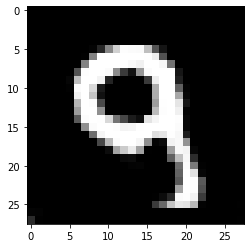

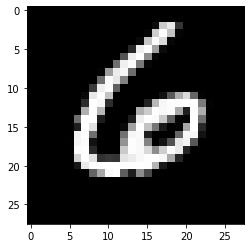

72th iteration gen_loss: 0.31152528524398804 dis_loss: 0.4254785180091858
72th iteration gen_loss: 0.3028731942176819 dis_loss: 0.4708598852157593
72th iteration gen_loss: 0.38030195236206055 dis_loss: 0.4078074097633362
72th iteration gen_loss: 0.3656757175922394 dis_loss: 0.44921112060546875
72th iteration gen_loss: 0.33554166555404663 dis_loss: 0.4930866062641144
72th iteration gen_loss: 0.30799147486686707 dis_loss: 0.4337494373321533
72th iteration gen_loss: 0.3449574112892151 dis_loss: 0.4810435175895691
72th iteration gen_loss: 0.27530473470687866 dis_loss: 0.5010288953781128
72th iteration gen_loss: 0.26549413800239563 dis_loss: 0.40005940198898315
72th iteration gen_loss: 0.3270379900932312 dis_loss: 0.4701038897037506
72th iteration gen_loss: 0.3261014521121979 dis_loss: 0.4421583414077759
72th iteration gen_loss: 0.41803067922592163 dis_loss: 0.45251983404159546


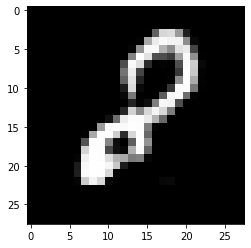

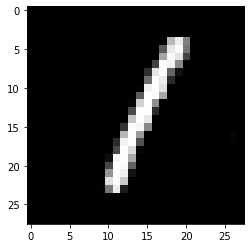

73th iteration gen_loss: 0.42222869396209717 dis_loss: 0.44840091466903687
73th iteration gen_loss: 0.2762652039527893 dis_loss: 0.44608303904533386
73th iteration gen_loss: 0.4208609163761139 dis_loss: 0.4542863368988037
73th iteration gen_loss: 0.2199438363313675 dis_loss: 0.46112698316574097
73th iteration gen_loss: 0.3710644543170929 dis_loss: 0.41093456745147705
73th iteration gen_loss: 0.2746058702468872 dis_loss: 0.4556367099285126
73th iteration gen_loss: 0.43746939301490784 dis_loss: 0.4562540650367737
73th iteration gen_loss: 0.23810961842536926 dis_loss: 0.40517890453338623
73th iteration gen_loss: 0.28511735796928406 dis_loss: 0.441555380821228
73th iteration gen_loss: 0.2974611520767212 dis_loss: 0.5206966400146484
73th iteration gen_loss: 0.2333596795797348 dis_loss: 0.43050211668014526
73th iteration gen_loss: 0.31829559803009033 dis_loss: 0.4392753839492798


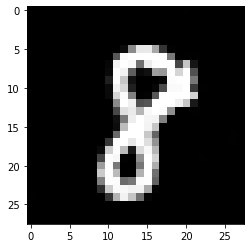

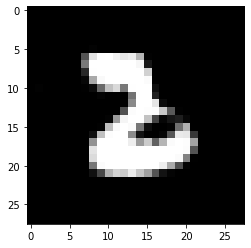

74th iteration gen_loss: 0.30792561173439026 dis_loss: 0.49850034713745117
74th iteration gen_loss: 0.3369957208633423 dis_loss: 0.48856282234191895
74th iteration gen_loss: 0.28453463315963745 dis_loss: 0.4307366609573364
74th iteration gen_loss: 0.2673654854297638 dis_loss: 0.4997168779373169
74th iteration gen_loss: 0.34401431679725647 dis_loss: 0.47957760095596313
74th iteration gen_loss: 0.34286296367645264 dis_loss: 0.3797324597835541
74th iteration gen_loss: 0.2817414700984955 dis_loss: 0.42592376470565796
74th iteration gen_loss: 0.34245944023132324 dis_loss: 0.49721792340278625
74th iteration gen_loss: 0.3618786036968231 dis_loss: 0.45773187279701233
74th iteration gen_loss: 0.4088348150253296 dis_loss: 0.4747806191444397
74th iteration gen_loss: 0.28202342987060547 dis_loss: 0.4818546772003174
74th iteration gen_loss: 0.303658664226532 dis_loss: 0.39178213477134705


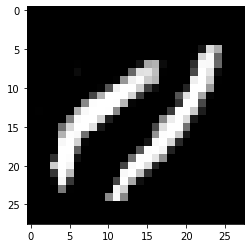

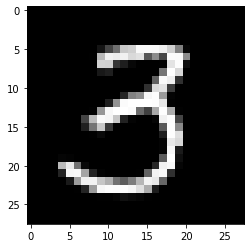

75th iteration gen_loss: 0.2540530860424042 dis_loss: 0.4742252230644226
75th iteration gen_loss: 0.33366113901138306 dis_loss: 0.4256826639175415
75th iteration gen_loss: 0.41449278593063354 dis_loss: 0.49755069613456726
75th iteration gen_loss: 0.3122578561306 dis_loss: 0.4170311689376831
75th iteration gen_loss: 0.3565113842487335 dis_loss: 0.3947021961212158
75th iteration gen_loss: 0.35206928849220276 dis_loss: 0.49285292625427246
75th iteration gen_loss: 0.4071440100669861 dis_loss: 0.47274675965309143
75th iteration gen_loss: 0.3084559440612793 dis_loss: 0.3936610817909241
75th iteration gen_loss: 0.28116998076438904 dis_loss: 0.45230168104171753
75th iteration gen_loss: 0.19281424582004547 dis_loss: 0.5094597339630127
75th iteration gen_loss: 0.3388107120990753 dis_loss: 0.39602386951446533
75th iteration gen_loss: 0.35252678394317627 dis_loss: 0.43003368377685547


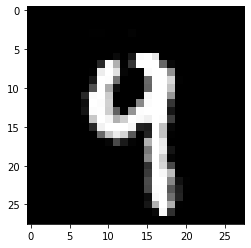

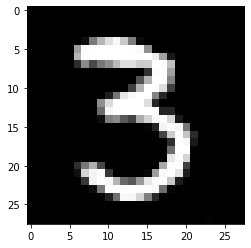

76th iteration gen_loss: 0.4016619920730591 dis_loss: 0.4740120768547058
76th iteration gen_loss: 0.3605378270149231 dis_loss: 0.43562281131744385
76th iteration gen_loss: 0.3415023982524872 dis_loss: 0.4195283055305481
76th iteration gen_loss: 0.23570609092712402 dis_loss: 0.44848471879959106
76th iteration gen_loss: 0.41700172424316406 dis_loss: 0.48738473653793335
76th iteration gen_loss: 0.2719208598136902 dis_loss: 0.42640548944473267
76th iteration gen_loss: 0.398333877325058 dis_loss: 0.45607298612594604
76th iteration gen_loss: 0.2491694539785385 dis_loss: 0.466824471950531
76th iteration gen_loss: 0.3560701906681061 dis_loss: 0.4449724853038788
76th iteration gen_loss: 0.36615580320358276 dis_loss: 0.4548252522945404
76th iteration gen_loss: 0.3066522777080536 dis_loss: 0.45632559061050415
76th iteration gen_loss: 0.41711440682411194 dis_loss: 0.505252480506897


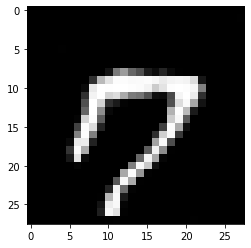

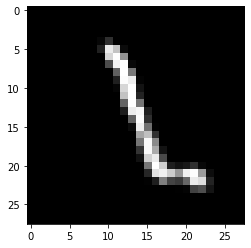

77th iteration gen_loss: 0.25307291746139526 dis_loss: 0.5263945460319519
77th iteration gen_loss: 0.30779001116752625 dis_loss: 0.4313465356826782
77th iteration gen_loss: 0.25740036368370056 dis_loss: 0.43899667263031006
77th iteration gen_loss: 0.3170790672302246 dis_loss: 0.42972996830940247
77th iteration gen_loss: 0.33894461393356323 dis_loss: 0.46961385011672974
77th iteration gen_loss: 0.3974001109600067 dis_loss: 0.4035377502441406
77th iteration gen_loss: 0.2423989474773407 dis_loss: 0.47367405891418457
77th iteration gen_loss: 0.30667629837989807 dis_loss: 0.4233241081237793
77th iteration gen_loss: 0.26759785413742065 dis_loss: 0.5070419907569885
77th iteration gen_loss: 0.4093828499317169 dis_loss: 0.3811204135417938
77th iteration gen_loss: 0.5159781575202942 dis_loss: 0.47660574316978455
77th iteration gen_loss: 0.35043951869010925 dis_loss: 0.3879191279411316


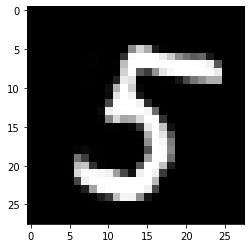

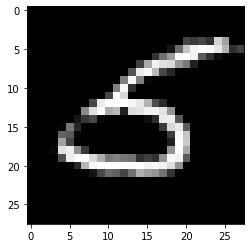

78th iteration gen_loss: 0.4085020422935486 dis_loss: 0.36956435441970825
78th iteration gen_loss: 0.2555350065231323 dis_loss: 0.4437653422355652
78th iteration gen_loss: 0.27516451478004456 dis_loss: 0.5222266316413879
78th iteration gen_loss: 0.3582409620285034 dis_loss: 0.47728216648101807
78th iteration gen_loss: 0.27188801765441895 dis_loss: 0.4761754274368286
78th iteration gen_loss: 0.20383693277835846 dis_loss: 0.41534245014190674
78th iteration gen_loss: 0.27743566036224365 dis_loss: 0.45379483699798584
78th iteration gen_loss: 0.18393424153327942 dis_loss: 0.51090008020401
78th iteration gen_loss: 0.2753651738166809 dis_loss: 0.37626320123672485
78th iteration gen_loss: 0.28939828276634216 dis_loss: 0.4214232265949249
78th iteration gen_loss: 0.4819207787513733 dis_loss: 0.4491044878959656
78th iteration gen_loss: 0.3179044723510742 dis_loss: 0.5780189037322998


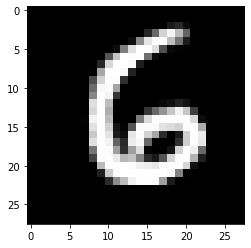

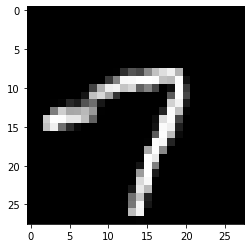

79th iteration gen_loss: 0.3171149492263794 dis_loss: 0.37328386306762695
79th iteration gen_loss: 0.29550570249557495 dis_loss: 0.43316444754600525
79th iteration gen_loss: 0.25130364298820496 dis_loss: 0.4515160322189331
79th iteration gen_loss: 0.43517568707466125 dis_loss: 0.4849119484424591
79th iteration gen_loss: 0.3335101306438446 dis_loss: 0.4856121242046356
79th iteration gen_loss: 0.37892594933509827 dis_loss: 0.4231824278831482
79th iteration gen_loss: 0.282325804233551 dis_loss: 0.4878380298614502
79th iteration gen_loss: 0.2636832892894745 dis_loss: 0.41094979643821716
79th iteration gen_loss: 0.34181541204452515 dis_loss: 0.41770318150520325
79th iteration gen_loss: 0.38731664419174194 dis_loss: 0.48143357038497925
79th iteration gen_loss: 0.28203636407852173 dis_loss: 0.38211172819137573
79th iteration gen_loss: 0.250771701335907 dis_loss: 0.48023802042007446


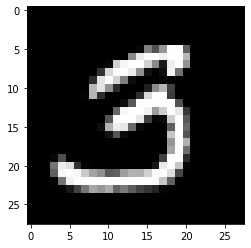

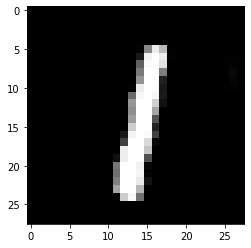

80th iteration gen_loss: 0.3880171775817871 dis_loss: 0.47363516688346863
80th iteration gen_loss: 0.3795863687992096 dis_loss: 0.40938568115234375
80th iteration gen_loss: 0.36930182576179504 dis_loss: 0.3532259166240692
80th iteration gen_loss: 0.41160863637924194 dis_loss: 0.4739602506160736
80th iteration gen_loss: 0.26317694783210754 dis_loss: 0.5139356851577759
80th iteration gen_loss: 0.3174532949924469 dis_loss: 0.4825652241706848
80th iteration gen_loss: 0.38835668563842773 dis_loss: 0.3883041739463806
80th iteration gen_loss: 0.3075922429561615 dis_loss: 0.4299190938472748
80th iteration gen_loss: 0.22692932188510895 dis_loss: 0.37199169397354126
80th iteration gen_loss: 0.30973705649375916 dis_loss: 0.5148046612739563
80th iteration gen_loss: 0.43907997012138367 dis_loss: 0.4712468385696411
80th iteration gen_loss: 0.31143519282341003 dis_loss: 0.4374281167984009


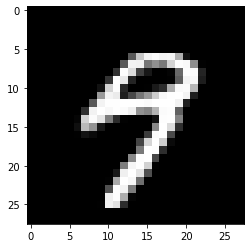

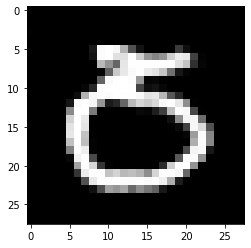

81th iteration gen_loss: 0.24085481464862823 dis_loss: 0.4955365061759949
81th iteration gen_loss: 0.3009086847305298 dis_loss: 0.3462834358215332
81th iteration gen_loss: 0.26173582673072815 dis_loss: 0.41856253147125244
81th iteration gen_loss: 0.3235253095626831 dis_loss: 0.4582027196884155
81th iteration gen_loss: 0.2382757067680359 dis_loss: 0.5237209796905518
81th iteration gen_loss: 0.298261821269989 dis_loss: 0.449887752532959
81th iteration gen_loss: 0.3589175343513489 dis_loss: 0.5097491145133972
81th iteration gen_loss: 0.3278104364871979 dis_loss: 0.4093530774116516
81th iteration gen_loss: 0.37921419739723206 dis_loss: 0.3962351679801941
81th iteration gen_loss: 0.4470914304256439 dis_loss: 0.5132795572280884
81th iteration gen_loss: 0.2994452714920044 dis_loss: 0.4179661273956299
81th iteration gen_loss: 0.371533066034317 dis_loss: 0.4602499008178711


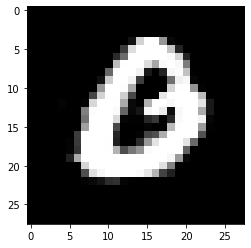

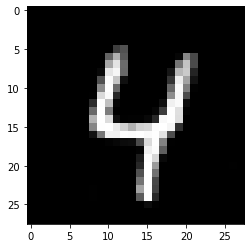

82th iteration gen_loss: 0.23017777502536774 dis_loss: 0.38786226511001587
82th iteration gen_loss: 0.4078732132911682 dis_loss: 0.39891260862350464
82th iteration gen_loss: 0.42328375577926636 dis_loss: 0.41812199354171753
82th iteration gen_loss: 0.43476951122283936 dis_loss: 0.4356262683868408
82th iteration gen_loss: 0.2593585252761841 dis_loss: 0.43203285336494446
82th iteration gen_loss: 0.2969978153705597 dis_loss: 0.42725613713264465
82th iteration gen_loss: 0.33734720945358276 dis_loss: 0.5231110453605652
82th iteration gen_loss: 0.2638600766658783 dis_loss: 0.45510348677635193
82th iteration gen_loss: 0.3131403625011444 dis_loss: 0.38159680366516113
82th iteration gen_loss: 0.36545392870903015 dis_loss: 0.4102386236190796
82th iteration gen_loss: 0.2896151542663574 dis_loss: 0.42671728134155273
82th iteration gen_loss: 0.4068301022052765 dis_loss: 0.4801024794578552


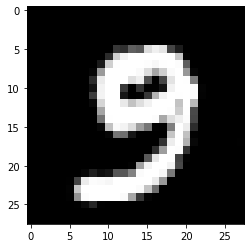

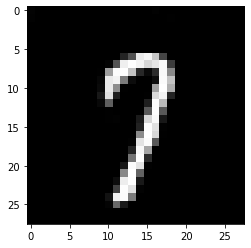

83th iteration gen_loss: 0.4545731544494629 dis_loss: 0.47081273794174194
83th iteration gen_loss: 0.31764715909957886 dis_loss: 0.4397639036178589
83th iteration gen_loss: 0.256196528673172 dis_loss: 0.46771106123924255
83th iteration gen_loss: 0.5075688362121582 dis_loss: 0.3995805084705353
83th iteration gen_loss: 0.41055288910865784 dis_loss: 0.4112205505371094
83th iteration gen_loss: 0.32152342796325684 dis_loss: 0.4390546679496765
83th iteration gen_loss: 0.31822818517684937 dis_loss: 0.4585723876953125
83th iteration gen_loss: 0.42248642444610596 dis_loss: 0.4257013201713562
83th iteration gen_loss: 0.3319736421108246 dis_loss: 0.3737260103225708
83th iteration gen_loss: 0.35108694434165955 dis_loss: 0.33699703216552734
83th iteration gen_loss: 0.5647672414779663 dis_loss: 0.4535306394100189
83th iteration gen_loss: 0.43949058651924133 dis_loss: 0.38036805391311646


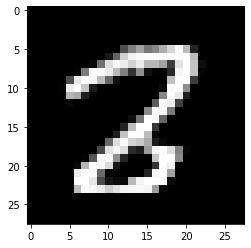

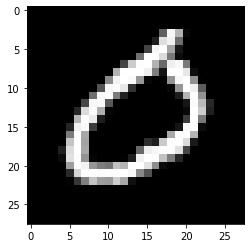

84th iteration gen_loss: 0.31707340478897095 dis_loss: 0.3880262076854706
84th iteration gen_loss: 0.45792800188064575 dis_loss: 0.4155019521713257
84th iteration gen_loss: 0.4082277715206146 dis_loss: 0.41271570324897766
84th iteration gen_loss: 0.45501044392585754 dis_loss: 0.45810598134994507
84th iteration gen_loss: 0.3029033839702606 dis_loss: 0.3713234066963196
84th iteration gen_loss: 0.3106919825077057 dis_loss: 0.40664124488830566
84th iteration gen_loss: 0.22642405331134796 dis_loss: 0.42044150829315186
84th iteration gen_loss: 0.2616092264652252 dis_loss: 0.45158839225769043
84th iteration gen_loss: 0.2776258885860443 dis_loss: 0.4847577214241028
84th iteration gen_loss: 0.2517381012439728 dis_loss: 0.41744565963745117
84th iteration gen_loss: 0.3568927049636841 dis_loss: 0.4879652261734009
84th iteration gen_loss: 0.25754809379577637 dis_loss: 0.4093194603919983


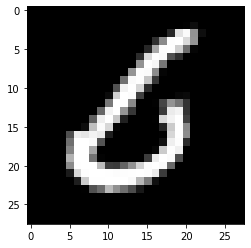

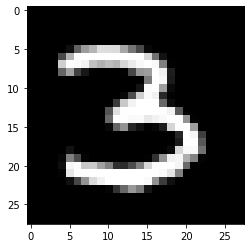

85th iteration gen_loss: 0.3338336944580078 dis_loss: 0.40415051579475403
85th iteration gen_loss: 0.4521147906780243 dis_loss: 0.441159725189209
85th iteration gen_loss: 0.5889281034469604 dis_loss: 0.4380459189414978
85th iteration gen_loss: 0.31737273931503296 dis_loss: 0.46325796842575073
85th iteration gen_loss: 0.3002198338508606 dis_loss: 0.4460661709308624
85th iteration gen_loss: 0.18009045720100403 dis_loss: 0.5297727584838867
85th iteration gen_loss: 0.3520035445690155 dis_loss: 0.5380333662033081
85th iteration gen_loss: 0.32306036353111267 dis_loss: 0.43378353118896484
85th iteration gen_loss: 0.392795205116272 dis_loss: 0.3731895089149475
85th iteration gen_loss: 0.34404322504997253 dis_loss: 0.4620245695114136
85th iteration gen_loss: 0.22540202736854553 dis_loss: 0.35564011335372925
85th iteration gen_loss: 0.4837883412837982 dis_loss: 0.5311934947967529


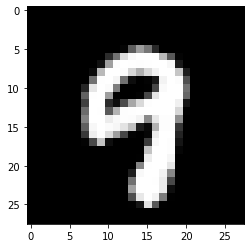

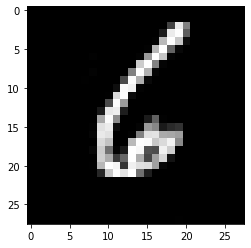

86th iteration gen_loss: 0.23377452790737152 dis_loss: 0.42049503326416016
86th iteration gen_loss: 0.32776525616645813 dis_loss: 0.42217499017715454
86th iteration gen_loss: 0.3002338111400604 dis_loss: 0.2905566096305847
86th iteration gen_loss: 0.28807833790779114 dis_loss: 0.457266628742218
86th iteration gen_loss: 0.2497033029794693 dis_loss: 0.4004552960395813
86th iteration gen_loss: 0.4658561646938324 dis_loss: 0.4078006148338318
86th iteration gen_loss: 0.3365216851234436 dis_loss: 0.4340028762817383
86th iteration gen_loss: 0.29470983147621155 dis_loss: 0.3543429970741272
86th iteration gen_loss: 0.47727805376052856 dis_loss: 0.39772361516952515
86th iteration gen_loss: 0.2532595694065094 dis_loss: 0.4376102685928345
86th iteration gen_loss: 0.22906038165092468 dis_loss: 0.38140422105789185
86th iteration gen_loss: 0.45144256949424744 dis_loss: 0.45746561884880066


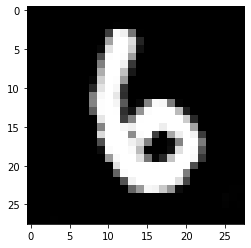

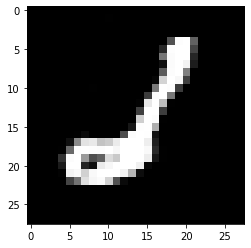

87th iteration gen_loss: 0.3082410991191864 dis_loss: 0.465421199798584
87th iteration gen_loss: 0.2949109673500061 dis_loss: 0.5011358261108398
87th iteration gen_loss: 0.3635612428188324 dis_loss: 0.3687365651130676
87th iteration gen_loss: 0.3386847674846649 dis_loss: 0.5204507112503052
87th iteration gen_loss: 0.3466622233390808 dis_loss: 0.4511086642742157
87th iteration gen_loss: 0.3573846220970154 dis_loss: 0.4083457291126251
87th iteration gen_loss: 0.32528239488601685 dis_loss: 0.493304967880249
87th iteration gen_loss: 0.4469210207462311 dis_loss: 0.5257893204689026
87th iteration gen_loss: 0.4090064465999603 dis_loss: 0.3849436044692993
87th iteration gen_loss: 0.30451899766921997 dis_loss: 0.46039924025535583
87th iteration gen_loss: 0.3523401618003845 dis_loss: 0.4547102153301239
87th iteration gen_loss: 0.18853099644184113 dis_loss: 0.47140198945999146


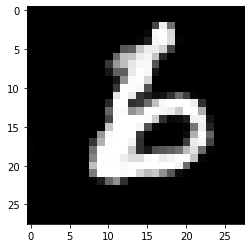

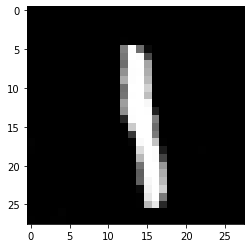

88th iteration gen_loss: 0.22632630169391632 dis_loss: 0.4225960969924927
88th iteration gen_loss: 0.20024466514587402 dis_loss: 0.361869752407074
88th iteration gen_loss: 0.44438573718070984 dis_loss: 0.39390042424201965
88th iteration gen_loss: 0.36180827021598816 dis_loss: 0.4017939567565918
88th iteration gen_loss: 0.2968020439147949 dis_loss: 0.4513396620750427
88th iteration gen_loss: 0.2428828775882721 dis_loss: 0.5220323801040649
88th iteration gen_loss: 0.35265830159187317 dis_loss: 0.36872825026512146
88th iteration gen_loss: 0.1663510650396347 dis_loss: 0.4724474549293518
88th iteration gen_loss: 0.2828201353549957 dis_loss: 0.41705024242401123
88th iteration gen_loss: 0.3582080006599426 dis_loss: 0.43886780738830566
88th iteration gen_loss: 0.33965539932250977 dis_loss: 0.39353397488594055
88th iteration gen_loss: 0.3080460727214813 dis_loss: 0.48834601044654846


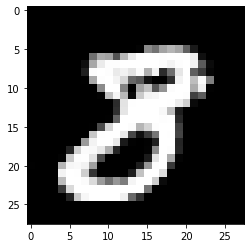

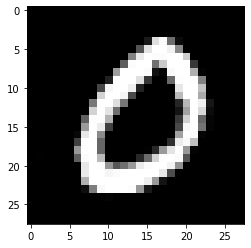

89th iteration gen_loss: 0.2806313633918762 dis_loss: 0.39480075240135193
89th iteration gen_loss: 0.375222772359848 dis_loss: 0.3958609104156494
89th iteration gen_loss: 0.3103559911251068 dis_loss: 0.4512821435928345
89th iteration gen_loss: 0.27275434136390686 dis_loss: 0.45969003438949585
89th iteration gen_loss: 0.3796408772468567 dis_loss: 0.41582006216049194
89th iteration gen_loss: 0.4661750793457031 dis_loss: 0.44222354888916016
89th iteration gen_loss: 0.3365161120891571 dis_loss: 0.43484190106391907
89th iteration gen_loss: 0.31515613198280334 dis_loss: 0.533362627029419
89th iteration gen_loss: 0.35110822319984436 dis_loss: 0.4714055061340332
89th iteration gen_loss: 0.3364218771457672 dis_loss: 0.39355355501174927
89th iteration gen_loss: 0.207614928483963 dis_loss: 0.4762047529220581
89th iteration gen_loss: 0.31625208258628845 dis_loss: 0.42008277773857117


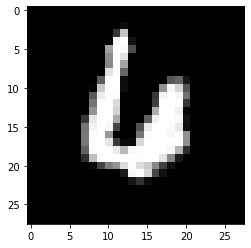

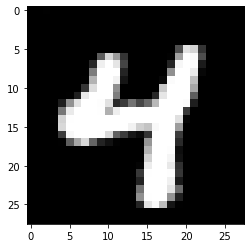

90th iteration gen_loss: 0.4918676018714905 dis_loss: 0.38777220249176025
90th iteration gen_loss: 0.4783104658126831 dis_loss: 0.4720518887042999
90th iteration gen_loss: 0.3071611821651459 dis_loss: 0.44737792015075684
90th iteration gen_loss: 0.32391586899757385 dis_loss: 0.4418453276157379
90th iteration gen_loss: 0.355253130197525 dis_loss: 0.45654964447021484
90th iteration gen_loss: 0.35892295837402344 dis_loss: 0.377183198928833
90th iteration gen_loss: 0.27679553627967834 dis_loss: 0.5127151012420654
90th iteration gen_loss: 0.2941228747367859 dis_loss: 0.5263490676879883
90th iteration gen_loss: 0.36815574765205383 dis_loss: 0.4596591591835022
90th iteration gen_loss: 0.3107775151729584 dis_loss: 0.4528413712978363
90th iteration gen_loss: 0.36873096227645874 dis_loss: 0.37631934881210327
90th iteration gen_loss: 0.3784138262271881 dis_loss: 0.42698532342910767


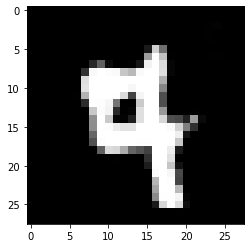

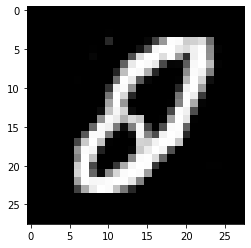

91th iteration gen_loss: 0.3455044627189636 dis_loss: 0.40147140622138977
91th iteration gen_loss: 0.3681323528289795 dis_loss: 0.4451602101325989
91th iteration gen_loss: 0.3047601878643036 dis_loss: 0.4265333414077759
91th iteration gen_loss: 0.4261155128479004 dis_loss: 0.45623746514320374
91th iteration gen_loss: 0.2845926284790039 dis_loss: 0.5186113119125366
91th iteration gen_loss: 0.3452720642089844 dis_loss: 0.36238187551498413
91th iteration gen_loss: 0.26368701457977295 dis_loss: 0.4787042737007141
91th iteration gen_loss: 0.3592281937599182 dis_loss: 0.42480015754699707
91th iteration gen_loss: 0.41173139214515686 dis_loss: 0.39445745944976807
91th iteration gen_loss: 0.3939940929412842 dis_loss: 0.38987672328948975
91th iteration gen_loss: 0.37931960821151733 dis_loss: 0.44598886370658875
91th iteration gen_loss: 0.3334205448627472 dis_loss: 0.3376139998435974


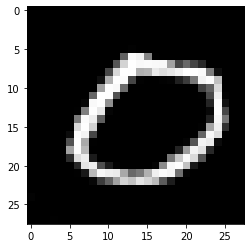

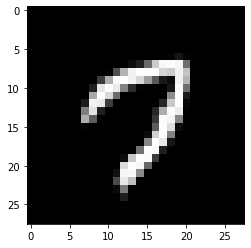

92th iteration gen_loss: 0.3033028841018677 dis_loss: 0.4863225221633911
92th iteration gen_loss: 0.3126332759857178 dis_loss: 0.3837762773036957
92th iteration gen_loss: 0.4072941243648529 dis_loss: 0.4509841203689575
92th iteration gen_loss: 0.34141287207603455 dis_loss: 0.4978695511817932
92th iteration gen_loss: 0.33396682143211365 dis_loss: 0.3808498978614807
92th iteration gen_loss: 0.3818397521972656 dis_loss: 0.4891928732395172
92th iteration gen_loss: 0.3416397273540497 dis_loss: 0.4873303174972534
92th iteration gen_loss: 0.3573404550552368 dis_loss: 0.5071338415145874
92th iteration gen_loss: 0.5026123523712158 dis_loss: 0.5292137265205383
92th iteration gen_loss: 0.4199020564556122 dis_loss: 0.4630453586578369
92th iteration gen_loss: 0.4020649492740631 dis_loss: 0.45900774002075195
92th iteration gen_loss: 0.34870561957359314 dis_loss: 0.49836212396621704


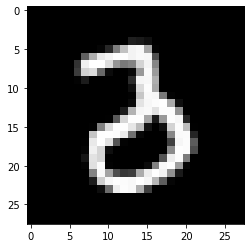

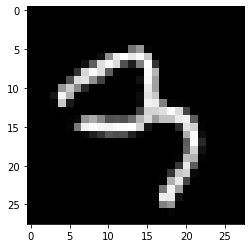

93th iteration gen_loss: 0.34967467188835144 dis_loss: 0.4459453821182251
93th iteration gen_loss: 0.3344193994998932 dis_loss: 0.448825478553772
93th iteration gen_loss: 0.5241379141807556 dis_loss: 0.4557048976421356
93th iteration gen_loss: 0.3359699249267578 dis_loss: 0.40393033623695374
93th iteration gen_loss: 0.2598637044429779 dis_loss: 0.4779500961303711
93th iteration gen_loss: 0.3355719745159149 dis_loss: 0.3735860586166382
93th iteration gen_loss: 0.3599907457828522 dis_loss: 0.48252397775650024
93th iteration gen_loss: 0.3812745213508606 dis_loss: 0.43521028757095337
93th iteration gen_loss: 0.31329190731048584 dis_loss: 0.4731239974498749
93th iteration gen_loss: 0.23875100910663605 dis_loss: 0.40128594636917114
93th iteration gen_loss: 0.3515302836894989 dis_loss: 0.45892980694770813
93th iteration gen_loss: 0.3888843059539795 dis_loss: 0.5435110926628113


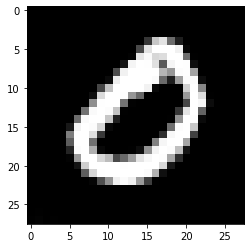

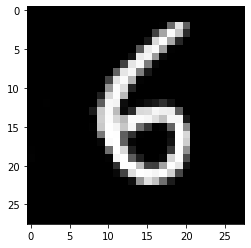

94th iteration gen_loss: 0.30638277530670166 dis_loss: 0.3702239394187927
94th iteration gen_loss: 0.2772393822669983 dis_loss: 0.463049054145813
94th iteration gen_loss: 0.24095050990581512 dis_loss: 0.3864051103591919
94th iteration gen_loss: 0.38008034229278564 dis_loss: 0.4083254635334015
94th iteration gen_loss: 0.29746899008750916 dis_loss: 0.5038869976997375
94th iteration gen_loss: 0.3312588334083557 dis_loss: 0.4577333331108093
94th iteration gen_loss: 0.23285937309265137 dis_loss: 0.5057130455970764
94th iteration gen_loss: 0.3472743034362793 dis_loss: 0.45082709193229675
94th iteration gen_loss: 0.39045119285583496 dis_loss: 0.42687952518463135
94th iteration gen_loss: 0.31442946195602417 dis_loss: 0.4040495753288269
94th iteration gen_loss: 0.3750384449958801 dis_loss: 0.4485642611980438
94th iteration gen_loss: 0.3056286573410034 dis_loss: 0.35389435291290283


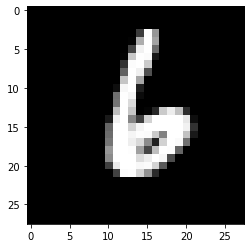

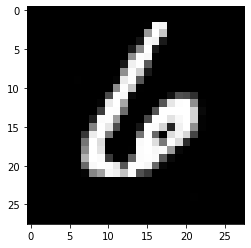

95th iteration gen_loss: 0.2559352219104767 dis_loss: 0.48171374201774597
95th iteration gen_loss: 0.29740381240844727 dis_loss: 0.44171616435050964
95th iteration gen_loss: 0.4018896520137787 dis_loss: 0.3795265257358551
95th iteration gen_loss: 0.3246750235557556 dis_loss: 0.4257364273071289
95th iteration gen_loss: 0.38800573348999023 dis_loss: 0.42043519020080566
95th iteration gen_loss: 0.4579686224460602 dis_loss: 0.6169907450675964
95th iteration gen_loss: 0.2347225546836853 dis_loss: 0.5240254402160645
95th iteration gen_loss: 0.2633962631225586 dis_loss: 0.4917525351047516
95th iteration gen_loss: 0.40282636880874634 dis_loss: 0.35941368341445923
95th iteration gen_loss: 0.22699536383152008 dis_loss: 0.4457521438598633
95th iteration gen_loss: 0.46599313616752625 dis_loss: 0.3845790922641754
95th iteration gen_loss: 0.3475130796432495 dis_loss: 0.41035109758377075


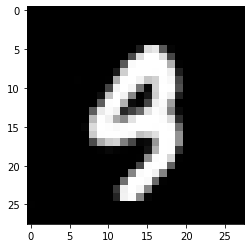

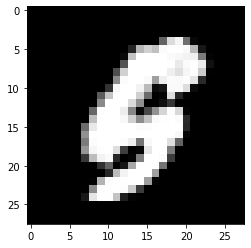

96th iteration gen_loss: 0.4037493169307709 dis_loss: 0.43621426820755005
96th iteration gen_loss: 0.3136533200740814 dis_loss: 0.3864729404449463
96th iteration gen_loss: 0.4376893639564514 dis_loss: 0.4016442894935608
96th iteration gen_loss: 0.29938095808029175 dis_loss: 0.5352581739425659
96th iteration gen_loss: 0.45098602771759033 dis_loss: 0.5032450556755066
96th iteration gen_loss: 0.3219784200191498 dis_loss: 0.38617992401123047
96th iteration gen_loss: 0.3694102466106415 dis_loss: 0.46903127431869507
96th iteration gen_loss: 0.36671409010887146 dis_loss: 0.46182781457901
96th iteration gen_loss: 0.2678055763244629 dis_loss: 0.42209911346435547
96th iteration gen_loss: 0.2810196578502655 dis_loss: 0.4994364380836487
96th iteration gen_loss: 0.2958441972732544 dis_loss: 0.4102771282196045
96th iteration gen_loss: 0.3160557746887207 dis_loss: 0.35997694730758667


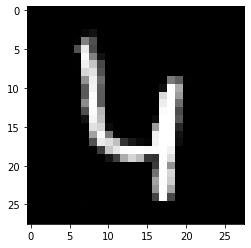

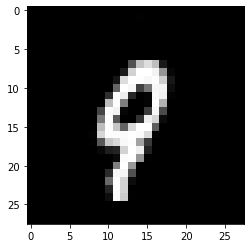

97th iteration gen_loss: 0.24811071157455444 dis_loss: 0.4207698404788971
97th iteration gen_loss: 0.2756677567958832 dis_loss: 0.5043156147003174
97th iteration gen_loss: 0.4389796853065491 dis_loss: 0.46237194538116455
97th iteration gen_loss: 0.29634642601013184 dis_loss: 0.4364863634109497
97th iteration gen_loss: 0.4070838391780853 dis_loss: 0.5043279528617859
97th iteration gen_loss: 0.24843095242977142 dis_loss: 0.3978627622127533
97th iteration gen_loss: 0.4095853269100189 dis_loss: 0.4517253339290619
97th iteration gen_loss: 0.3663903772830963 dis_loss: 0.4217228889465332
97th iteration gen_loss: 0.26328200101852417 dis_loss: 0.4234078526496887
97th iteration gen_loss: 0.37678268551826477 dis_loss: 0.4184008836746216
97th iteration gen_loss: 0.40663614869117737 dis_loss: 0.4080628752708435
97th iteration gen_loss: 0.3621564507484436 dis_loss: 0.4287819266319275


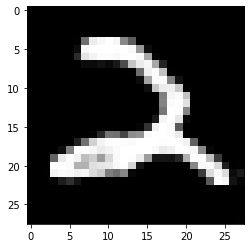

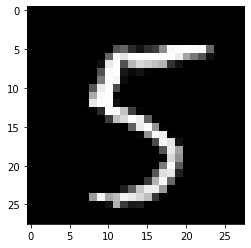

98th iteration gen_loss: 0.33427608013153076 dis_loss: 0.3084968030452728
98th iteration gen_loss: 0.26236599683761597 dis_loss: 0.39743897318840027
98th iteration gen_loss: 0.38432782888412476 dis_loss: 0.34458035230636597
98th iteration gen_loss: 0.40919896960258484 dis_loss: 0.44114041328430176
98th iteration gen_loss: 0.38107356429100037 dis_loss: 0.43035441637039185
98th iteration gen_loss: 0.4068673849105835 dis_loss: 0.4570373296737671
98th iteration gen_loss: 0.28038281202316284 dis_loss: 0.44939231872558594
98th iteration gen_loss: 0.3324280381202698 dis_loss: 0.3671044111251831
98th iteration gen_loss: 0.46991395950317383 dis_loss: 0.45130211114883423
98th iteration gen_loss: 0.3778485357761383 dis_loss: 0.4813465476036072
98th iteration gen_loss: 0.3734859824180603 dis_loss: 0.38924968242645264
98th iteration gen_loss: 0.32237187027931213 dis_loss: 0.40280681848526


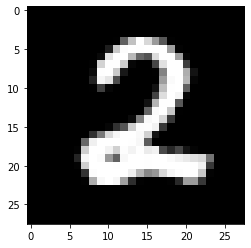

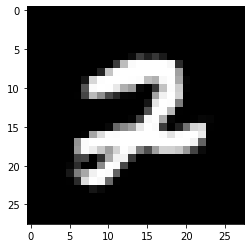

99th iteration gen_loss: 0.4400418996810913 dis_loss: 0.5229307413101196
99th iteration gen_loss: 0.3610208332538605 dis_loss: 0.48182013630867004
99th iteration gen_loss: 0.2794102728366852 dis_loss: 0.4712291359901428
99th iteration gen_loss: 0.31443488597869873 dis_loss: 0.4649561643600464
99th iteration gen_loss: 0.23562850058078766 dis_loss: 0.405687153339386
99th iteration gen_loss: 0.42004287242889404 dis_loss: 0.4451219141483307
99th iteration gen_loss: 0.4855135977268219 dis_loss: 0.4354432225227356
99th iteration gen_loss: 0.3111269176006317 dis_loss: 0.5284947752952576
99th iteration gen_loss: 0.22610679268836975 dis_loss: 0.4693158268928528
99th iteration gen_loss: 0.4118880331516266 dis_loss: 0.4910944104194641
99th iteration gen_loss: 0.5144720077514648 dis_loss: 0.50340735912323
99th iteration gen_loss: 0.2391565591096878 dis_loss: 0.49372971057891846


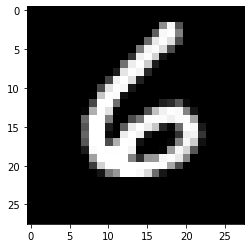

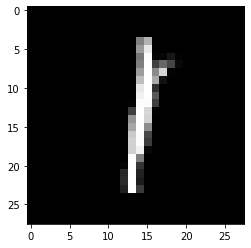

100th iteration gen_loss: 0.3677278757095337 dis_loss: 0.4601503014564514
100th iteration gen_loss: 0.5217326879501343 dis_loss: 0.36501193046569824
100th iteration gen_loss: 0.32126548886299133 dis_loss: 0.3679005801677704
100th iteration gen_loss: 0.4484812915325165 dis_loss: 0.43028098344802856
100th iteration gen_loss: 0.3163517415523529 dis_loss: 0.43681371212005615
100th iteration gen_loss: 0.30430686473846436 dis_loss: 0.5331062078475952
100th iteration gen_loss: 0.1775953322649002 dis_loss: 0.3892354965209961
100th iteration gen_loss: 0.3862974941730499 dis_loss: 0.4710029363632202
100th iteration gen_loss: 0.3958142101764679 dis_loss: 0.40286415815353394
100th iteration gen_loss: 0.3563998341560364 dis_loss: 0.47800159454345703
100th iteration gen_loss: 0.2618260383605957 dis_loss: 0.29616814851760864
100th iteration gen_loss: 0.33402034640312195 dis_loss: 0.4359395503997803


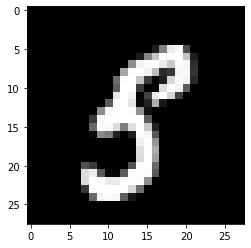

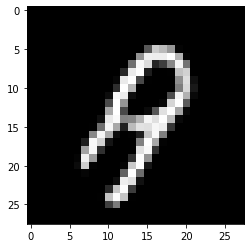

101th iteration gen_loss: 0.23053491115570068 dis_loss: 0.5087742805480957
101th iteration gen_loss: 0.3166067600250244 dis_loss: 0.44142580032348633
101th iteration gen_loss: 0.3391060531139374 dis_loss: 0.44023066759109497
101th iteration gen_loss: 0.2989986836910248 dis_loss: 0.4370420277118683
101th iteration gen_loss: 0.3357678949832916 dis_loss: 0.4930630326271057
101th iteration gen_loss: 0.315655380487442 dis_loss: 0.397682249546051
101th iteration gen_loss: 0.4038603901863098 dis_loss: 0.34742677211761475
101th iteration gen_loss: 0.4212164878845215 dis_loss: 0.3090832233428955
101th iteration gen_loss: 0.30555498600006104 dis_loss: 0.44491809606552124
101th iteration gen_loss: 0.4702797532081604 dis_loss: 0.4491766095161438
101th iteration gen_loss: 0.3484850227832794 dis_loss: 0.44753700494766235
101th iteration gen_loss: 0.3177376985549927 dis_loss: 0.46768009662628174


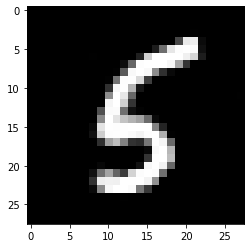

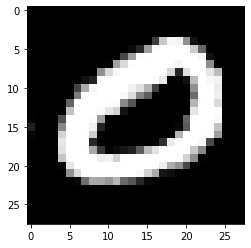

102th iteration gen_loss: 0.5078552961349487 dis_loss: 0.4268615245819092
102th iteration gen_loss: 0.40166720747947693 dis_loss: 0.3340531587600708
102th iteration gen_loss: 0.270018994808197 dis_loss: 0.4321930408477783
102th iteration gen_loss: 0.42293310165405273 dis_loss: 0.44811445474624634
102th iteration gen_loss: 0.3901840150356293 dis_loss: 0.3658449649810791
102th iteration gen_loss: 0.21915513277053833 dis_loss: 0.4520290493965149
102th iteration gen_loss: 0.510737955570221 dis_loss: 0.3178686499595642
102th iteration gen_loss: 0.3125059902667999 dis_loss: 0.37077489495277405
102th iteration gen_loss: 0.25300219655036926 dis_loss: 0.46972060203552246
102th iteration gen_loss: 0.4384239912033081 dis_loss: 0.480510413646698
102th iteration gen_loss: 0.5956974029541016 dis_loss: 0.5954458713531494
102th iteration gen_loss: 0.22789904475212097 dis_loss: 0.43785595893859863


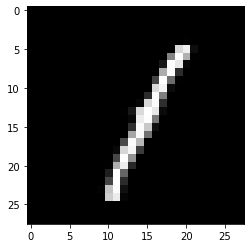

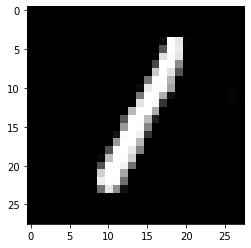

103th iteration gen_loss: 0.3184507191181183 dis_loss: 0.3571414351463318
103th iteration gen_loss: 0.26679912209510803 dis_loss: 0.4404509365558624
103th iteration gen_loss: 0.2971433699131012 dis_loss: 0.3849486708641052
103th iteration gen_loss: 0.29290029406547546 dis_loss: 0.4662240147590637
103th iteration gen_loss: 0.36130040884017944 dis_loss: 0.43707704544067383
103th iteration gen_loss: 0.382964551448822 dis_loss: 0.4098805785179138
103th iteration gen_loss: 0.4448884427547455 dis_loss: 0.38705989718437195
103th iteration gen_loss: 0.2272663414478302 dis_loss: 0.4332839846611023
103th iteration gen_loss: 0.3281809687614441 dis_loss: 0.4270964562892914
103th iteration gen_loss: 0.3778800964355469 dis_loss: 0.42516380548477173
103th iteration gen_loss: 0.2270454317331314 dis_loss: 0.4286333918571472
103th iteration gen_loss: 0.3334219753742218 dis_loss: 0.42505741119384766


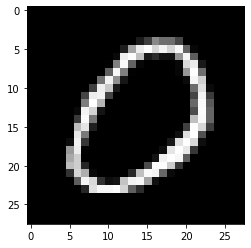

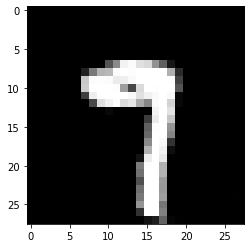

104th iteration gen_loss: 0.2738105356693268 dis_loss: 0.3958699107170105
104th iteration gen_loss: 0.3086532652378082 dis_loss: 0.5194082260131836
104th iteration gen_loss: 0.24653567373752594 dis_loss: 0.4217601716518402
104th iteration gen_loss: 0.342750608921051 dis_loss: 0.4046534299850464
104th iteration gen_loss: 0.3300148844718933 dis_loss: 0.40113890171051025
104th iteration gen_loss: 0.39453932642936707 dis_loss: 0.42392295598983765
104th iteration gen_loss: 0.37328845262527466 dis_loss: 0.4383872151374817
104th iteration gen_loss: 0.2634533643722534 dis_loss: 0.4525604248046875
104th iteration gen_loss: 0.36789655685424805 dis_loss: 0.48795175552368164
104th iteration gen_loss: 0.27227872610092163 dis_loss: 0.5138098001480103
104th iteration gen_loss: 0.3643724024295807 dis_loss: 0.4271852374076843
104th iteration gen_loss: 0.3841235339641571 dis_loss: 0.4458564817905426


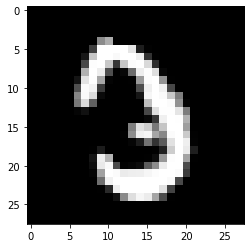

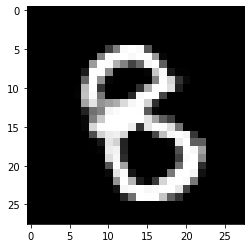

105th iteration gen_loss: 0.28487396240234375 dis_loss: 0.3828868269920349
105th iteration gen_loss: 0.32387468218803406 dis_loss: 0.4812687039375305
105th iteration gen_loss: 0.37754330039024353 dis_loss: 0.43090635538101196
105th iteration gen_loss: 0.38680389523506165 dis_loss: 0.4261569380760193
105th iteration gen_loss: 0.31084051728248596 dis_loss: 0.4177861511707306
105th iteration gen_loss: 0.27569830417633057 dis_loss: 0.4169337749481201
105th iteration gen_loss: 0.30094248056411743 dis_loss: 0.47112956643104553
105th iteration gen_loss: 0.4569850564002991 dis_loss: 0.5352280735969543
105th iteration gen_loss: 0.2691153287887573 dis_loss: 0.45371243357658386
105th iteration gen_loss: 0.27055245637893677 dis_loss: 0.4849777817726135
105th iteration gen_loss: 0.35287055373191833 dis_loss: 0.45351743698120117
105th iteration gen_loss: 0.3541422486305237 dis_loss: 0.41113531589508057


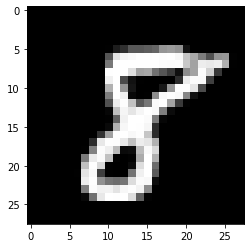

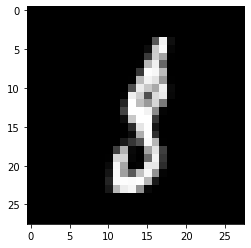

106th iteration gen_loss: 0.3316902816295624 dis_loss: 0.4527455270290375
106th iteration gen_loss: 0.33151790499687195 dis_loss: 0.4232732951641083
106th iteration gen_loss: 0.23409909009933472 dis_loss: 0.4790356755256653
106th iteration gen_loss: 0.40720614790916443 dis_loss: 0.47308260202407837
106th iteration gen_loss: 0.3140908479690552 dis_loss: 0.4560980200767517
106th iteration gen_loss: 0.31166574358940125 dis_loss: 0.37626439332962036
106th iteration gen_loss: 0.20730233192443848 dis_loss: 0.4401927590370178
106th iteration gen_loss: 0.36723533272743225 dis_loss: 0.5301939249038696
106th iteration gen_loss: 0.2613908052444458 dis_loss: 0.5057443380355835
106th iteration gen_loss: 0.33356764912605286 dis_loss: 0.42273709177970886
106th iteration gen_loss: 0.2564219534397125 dis_loss: 0.4278753995895386
106th iteration gen_loss: 0.22813770174980164 dis_loss: 0.3880315124988556


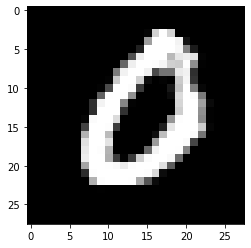

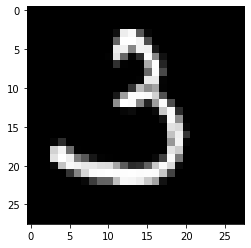

107th iteration gen_loss: 0.21548782289028168 dis_loss: 0.4234306812286377
107th iteration gen_loss: 0.33717620372772217 dis_loss: 0.38837987184524536
107th iteration gen_loss: 0.3372834324836731 dis_loss: 0.39831334352493286
107th iteration gen_loss: 0.26627689599990845 dis_loss: 0.3526478111743927
107th iteration gen_loss: 0.41896727681159973 dis_loss: 0.34587350487709045
107th iteration gen_loss: 0.36225321888923645 dis_loss: 0.43905019760131836
107th iteration gen_loss: 0.35632991790771484 dis_loss: 0.3849644064903259
107th iteration gen_loss: 0.4203207194805145 dis_loss: 0.47115999460220337
107th iteration gen_loss: 0.25105223059654236 dis_loss: 0.47511082887649536
107th iteration gen_loss: 0.3675112724304199 dis_loss: 0.5503517985343933
107th iteration gen_loss: 0.3074648380279541 dis_loss: 0.3798682391643524
107th iteration gen_loss: 0.3416779935359955 dis_loss: 0.4531867504119873


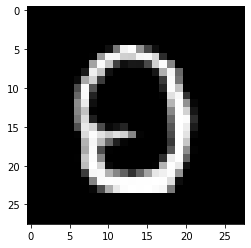

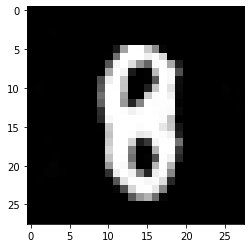

108th iteration gen_loss: 0.3924696147441864 dis_loss: 0.4162280559539795
108th iteration gen_loss: 0.29950931668281555 dis_loss: 0.4426019787788391
108th iteration gen_loss: 0.36435720324516296 dis_loss: 0.4690101444721222
108th iteration gen_loss: 0.3426963686943054 dis_loss: 0.4082011282444
108th iteration gen_loss: 0.3163093626499176 dis_loss: 0.4870802164077759
108th iteration gen_loss: 0.46902647614479065 dis_loss: 0.48449647426605225
108th iteration gen_loss: 0.34163787961006165 dis_loss: 0.455910325050354
108th iteration gen_loss: 0.3445351719856262 dis_loss: 0.4867963194847107
108th iteration gen_loss: 0.3449743688106537 dis_loss: 0.4163534641265869
108th iteration gen_loss: 0.3171432614326477 dis_loss: 0.4287462830543518
108th iteration gen_loss: 0.22702240943908691 dis_loss: 0.4058796763420105
108th iteration gen_loss: 0.3603493273258209 dis_loss: 0.42931610345840454


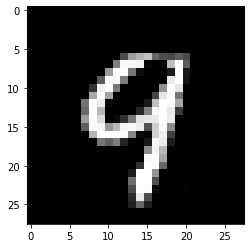

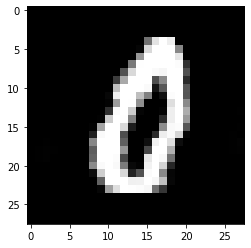

109th iteration gen_loss: 0.2626349925994873 dis_loss: 0.43522757291793823
109th iteration gen_loss: 0.44589319825172424 dis_loss: 0.4797520637512207
109th iteration gen_loss: 0.44984185695648193 dis_loss: 0.5306240916252136
109th iteration gen_loss: 0.3984520733356476 dis_loss: 0.4386138916015625
109th iteration gen_loss: 0.5717443823814392 dis_loss: 0.4540315270423889
109th iteration gen_loss: 0.24546191096305847 dis_loss: 0.4711158275604248
109th iteration gen_loss: 0.4417039453983307 dis_loss: 0.44628453254699707
109th iteration gen_loss: 0.3284941017627716 dis_loss: 0.4705861210823059
109th iteration gen_loss: 0.3048011064529419 dis_loss: 0.4412631690502167
109th iteration gen_loss: 0.2768208682537079 dis_loss: 0.5217780470848083
109th iteration gen_loss: 0.23681575059890747 dis_loss: 0.39876991510391235
109th iteration gen_loss: 0.3208634555339813 dis_loss: 0.4273616671562195


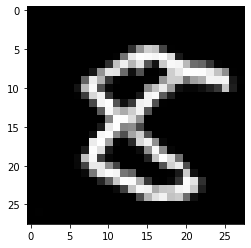

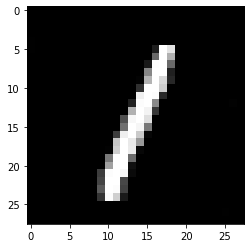

110th iteration gen_loss: 0.32493919134140015 dis_loss: 0.44615328311920166
110th iteration gen_loss: 0.32724714279174805 dis_loss: 0.46377021074295044
110th iteration gen_loss: 0.3619314730167389 dis_loss: 0.5221434831619263
110th iteration gen_loss: 0.1816931813955307 dis_loss: 0.48414409160614014
110th iteration gen_loss: 0.3471640646457672 dis_loss: 0.4750993847846985
110th iteration gen_loss: 0.33317655324935913 dis_loss: 0.46548551321029663
110th iteration gen_loss: 0.2777242660522461 dis_loss: 0.4388880133628845
110th iteration gen_loss: 0.22036856412887573 dis_loss: 0.49570250511169434
110th iteration gen_loss: 0.26052936911582947 dis_loss: 0.41091471910476685
110th iteration gen_loss: 0.2535170018672943 dis_loss: 0.43167752027511597
110th iteration gen_loss: 0.40626654028892517 dis_loss: 0.4275825619697571
110th iteration gen_loss: 0.33350813388824463 dis_loss: 0.3828076720237732


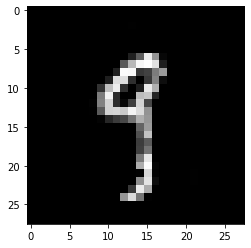

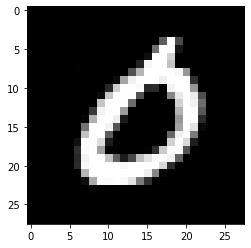

111th iteration gen_loss: 0.2778077721595764 dis_loss: 0.49362120032310486
111th iteration gen_loss: 0.41958487033843994 dis_loss: 0.39753657579421997
111th iteration gen_loss: 0.2665267884731293 dis_loss: 0.4669646620750427
111th iteration gen_loss: 0.33902403712272644 dis_loss: 0.41213393211364746
111th iteration gen_loss: 0.3798754811286926 dis_loss: 0.3478041887283325
111th iteration gen_loss: 0.3885906934738159 dis_loss: 0.39878207445144653
111th iteration gen_loss: 0.44882819056510925 dis_loss: 0.6187723875045776
111th iteration gen_loss: 0.3579791486263275 dis_loss: 0.44986802339553833
111th iteration gen_loss: 0.44198518991470337 dis_loss: 0.49390122294425964
111th iteration gen_loss: 0.5574397444725037 dis_loss: 0.46552711725234985
111th iteration gen_loss: 0.3482135832309723 dis_loss: 0.4789898097515106
111th iteration gen_loss: 0.39266863465309143 dis_loss: 0.5095201730728149


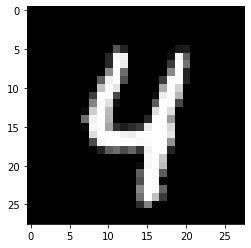

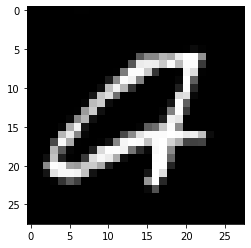

112th iteration gen_loss: 0.3093043565750122 dis_loss: 0.38182854652404785
112th iteration gen_loss: 0.3032011091709137 dis_loss: 0.41726744174957275
112th iteration gen_loss: 0.3636995851993561 dis_loss: 0.4907769560813904
112th iteration gen_loss: 0.38798972964286804 dis_loss: 0.44779545068740845
112th iteration gen_loss: 0.30420932173728943 dis_loss: 0.45624828338623047
112th iteration gen_loss: 0.3228136897087097 dis_loss: 0.44902485609054565
112th iteration gen_loss: 0.3065771758556366 dis_loss: 0.3851984739303589
112th iteration gen_loss: 0.3883805274963379 dis_loss: 0.35952040553092957
112th iteration gen_loss: 0.40858545899391174 dis_loss: 0.5135551691055298
112th iteration gen_loss: 0.23644079267978668 dis_loss: 0.44652020931243896
112th iteration gen_loss: 0.2798338532447815 dis_loss: 0.41807621717453003
112th iteration gen_loss: 0.4503033459186554 dis_loss: 0.483792245388031


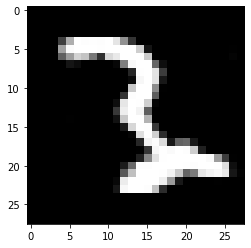

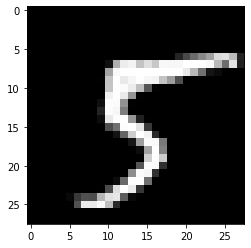

113th iteration gen_loss: 0.32716959714889526 dis_loss: 0.43121278285980225
113th iteration gen_loss: 0.4091886878013611 dis_loss: 0.5170542001724243
113th iteration gen_loss: 0.44804713129997253 dis_loss: 0.43644487857818604
113th iteration gen_loss: 0.4191129505634308 dis_loss: 0.3643713593482971
113th iteration gen_loss: 0.40557318925857544 dis_loss: 0.3697916865348816
113th iteration gen_loss: 0.31080642342567444 dis_loss: 0.4056861400604248
113th iteration gen_loss: 0.4503745138645172 dis_loss: 0.44975098967552185
113th iteration gen_loss: 0.3332580626010895 dis_loss: 0.38032346963882446
113th iteration gen_loss: 0.28341129422187805 dis_loss: 0.41799017786979675
113th iteration gen_loss: 0.3529731035232544 dis_loss: 0.4790276288986206
113th iteration gen_loss: 0.3983538746833801 dis_loss: 0.44986847043037415
113th iteration gen_loss: 0.3852631747722626 dis_loss: 0.40601277351379395


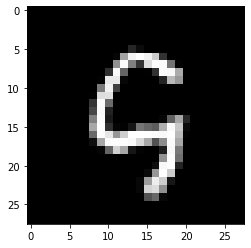

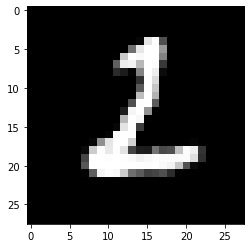

114th iteration gen_loss: 0.37454840540885925 dis_loss: 0.44416552782058716
114th iteration gen_loss: 0.42122936248779297 dis_loss: 0.4357600808143616
114th iteration gen_loss: 0.20432311296463013 dis_loss: 0.3855098485946655
114th iteration gen_loss: 0.2518637478351593 dis_loss: 0.4464204013347626
114th iteration gen_loss: 0.3254515528678894 dis_loss: 0.46864116191864014
114th iteration gen_loss: 0.394094318151474 dis_loss: 0.41707155108451843
114th iteration gen_loss: 0.23803657293319702 dis_loss: 0.5013836622238159
114th iteration gen_loss: 0.5032920837402344 dis_loss: 0.45978596806526184
114th iteration gen_loss: 0.45965197682380676 dis_loss: 0.3743149936199188
114th iteration gen_loss: 0.37435245513916016 dis_loss: 0.35944420099258423
114th iteration gen_loss: 0.32264456152915955 dis_loss: 0.43133533000946045
114th iteration gen_loss: 0.25021788477897644 dis_loss: 0.45753371715545654


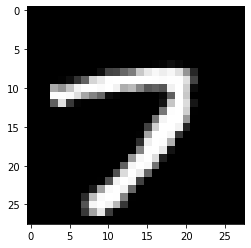

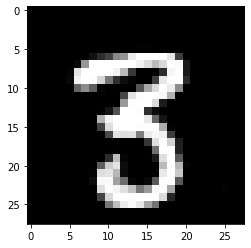

115th iteration gen_loss: 0.38202449679374695 dis_loss: 0.5289537906646729
115th iteration gen_loss: 0.36357688903808594 dis_loss: 0.4794239401817322
115th iteration gen_loss: 0.29758429527282715 dis_loss: 0.4366980195045471
115th iteration gen_loss: 0.2721942365169525 dis_loss: 0.43930092453956604
115th iteration gen_loss: 0.36396875977516174 dis_loss: 0.36944177746772766
115th iteration gen_loss: 0.3239237070083618 dis_loss: 0.43488064408302307
115th iteration gen_loss: 0.2462543398141861 dis_loss: 0.5051476955413818
115th iteration gen_loss: 0.37748825550079346 dis_loss: 0.47093841433525085
115th iteration gen_loss: 0.3148065507411957 dis_loss: 0.49453917145729065
115th iteration gen_loss: 0.5805729031562805 dis_loss: 0.4934203624725342
115th iteration gen_loss: 0.36313825845718384 dis_loss: 0.443737655878067
115th iteration gen_loss: 0.2784202992916107 dis_loss: 0.46247225999832153


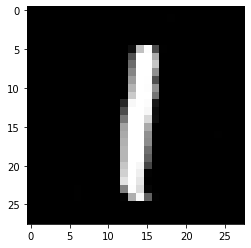

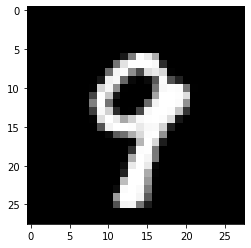

116th iteration gen_loss: 0.3719179928302765 dis_loss: 0.40291064977645874
116th iteration gen_loss: 0.4734456241130829 dis_loss: 0.4615534543991089
116th iteration gen_loss: 0.3605407178401947 dis_loss: 0.5140743851661682
116th iteration gen_loss: 0.4210526943206787 dis_loss: 0.45139509439468384
116th iteration gen_loss: 0.38247111439704895 dis_loss: 0.46301281452178955
116th iteration gen_loss: 0.3842256963253021 dis_loss: 0.37741541862487793
116th iteration gen_loss: 0.28398609161376953 dis_loss: 0.5086377263069153
116th iteration gen_loss: 0.30423271656036377 dis_loss: 0.45640861988067627
116th iteration gen_loss: 0.2917728126049042 dis_loss: 0.47215938568115234
116th iteration gen_loss: 0.3844122290611267 dis_loss: 0.43082359433174133
116th iteration gen_loss: 0.32885345816612244 dis_loss: 0.5499534010887146
116th iteration gen_loss: 0.3029637634754181 dis_loss: 0.4382033348083496


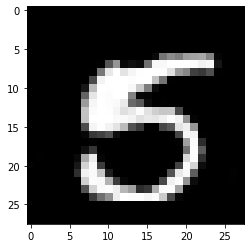

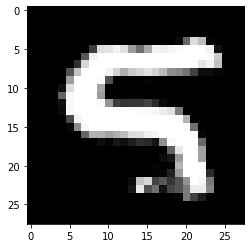

117th iteration gen_loss: 0.26606208086013794 dis_loss: 0.4053157567977905
117th iteration gen_loss: 0.21226388216018677 dis_loss: 0.38642117381095886
117th iteration gen_loss: 0.3178351819515228 dis_loss: 0.38811612129211426
117th iteration gen_loss: 0.391218364238739 dis_loss: 0.4523465037345886
117th iteration gen_loss: 0.2957908809185028 dis_loss: 0.5045884847640991
117th iteration gen_loss: 0.23747573792934418 dis_loss: 0.504891574382782
117th iteration gen_loss: 0.34193092584609985 dis_loss: 0.44182848930358887
117th iteration gen_loss: 0.41904059052467346 dis_loss: 0.44506120681762695
117th iteration gen_loss: 0.37986961007118225 dis_loss: 0.444395512342453
117th iteration gen_loss: 0.48370206356048584 dis_loss: 0.464294970035553
117th iteration gen_loss: 0.21831971406936646 dis_loss: 0.44926849007606506
117th iteration gen_loss: 0.3877173662185669 dis_loss: 0.4132937788963318


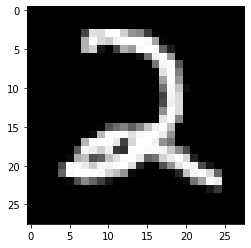

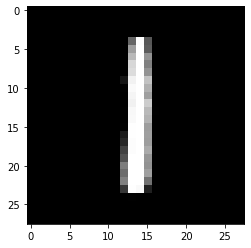

118th iteration gen_loss: 0.38980668783187866 dis_loss: 0.40155649185180664
118th iteration gen_loss: 0.28011563420295715 dis_loss: 0.38599056005477905
118th iteration gen_loss: 0.4213179051876068 dis_loss: 0.4051291048526764
118th iteration gen_loss: 0.39984846115112305 dis_loss: 0.39579594135284424
118th iteration gen_loss: 0.2653563320636749 dis_loss: 0.42277103662490845
118th iteration gen_loss: 0.25863325595855713 dis_loss: 0.42840009927749634
118th iteration gen_loss: 0.4305153489112854 dis_loss: 0.43032681941986084
118th iteration gen_loss: 0.24882906675338745 dis_loss: 0.4319077134132385
118th iteration gen_loss: 0.3217571973800659 dis_loss: 0.38982224464416504
118th iteration gen_loss: 0.3656226396560669 dis_loss: 0.42444658279418945
118th iteration gen_loss: 0.2536807060241699 dis_loss: 0.48462969064712524
118th iteration gen_loss: 0.4545993208885193 dis_loss: 0.32741498947143555


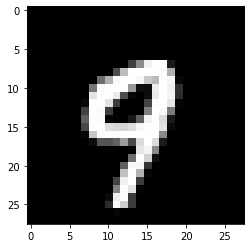

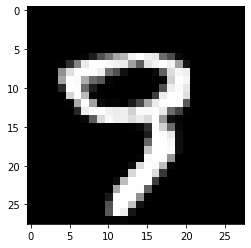

119th iteration gen_loss: 0.4715614914894104 dis_loss: 0.45794737339019775
119th iteration gen_loss: 0.4478907585144043 dis_loss: 0.48680150508880615
119th iteration gen_loss: 0.30923202633857727 dis_loss: 0.38804012537002563
119th iteration gen_loss: 0.4226052761077881 dis_loss: 0.42430394887924194
119th iteration gen_loss: 0.34496009349823 dis_loss: 0.47484540939331055
119th iteration gen_loss: 0.327665776014328 dis_loss: 0.42477577924728394
119th iteration gen_loss: 0.31646493077278137 dis_loss: 0.40203723311424255
119th iteration gen_loss: 0.24111180007457733 dis_loss: 0.5420706272125244
119th iteration gen_loss: 0.4046911895275116 dis_loss: 0.4983958601951599
119th iteration gen_loss: 0.4043811559677124 dis_loss: 0.44687920808792114
119th iteration gen_loss: 0.3767835795879364 dis_loss: 0.37953102588653564
119th iteration gen_loss: 0.18775375187397003 dis_loss: 0.4023825228214264


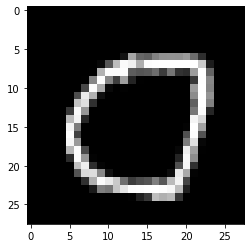

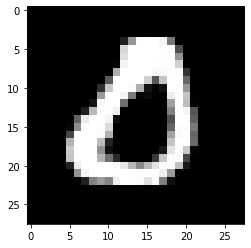

120th iteration gen_loss: 0.37003999948501587 dis_loss: 0.41032007336616516
120th iteration gen_loss: 0.1797734797000885 dis_loss: 0.4011402726173401
120th iteration gen_loss: 0.486404150724411 dis_loss: 0.5167315006256104
120th iteration gen_loss: 0.32259804010391235 dis_loss: 0.4688047766685486
120th iteration gen_loss: 0.40865468978881836 dis_loss: 0.4078676104545593
120th iteration gen_loss: 0.38377392292022705 dis_loss: 0.43420594930648804
120th iteration gen_loss: 0.2593931555747986 dis_loss: 0.4539501667022705
120th iteration gen_loss: 0.5240887999534607 dis_loss: 0.5724409818649292
120th iteration gen_loss: 0.4061051905155182 dis_loss: 0.41215312480926514
120th iteration gen_loss: 0.18985316157341003 dis_loss: 0.513586699962616
120th iteration gen_loss: 0.3854968845844269 dis_loss: 0.41623997688293457
120th iteration gen_loss: 0.4762851595878601 dis_loss: 0.47952350974082947


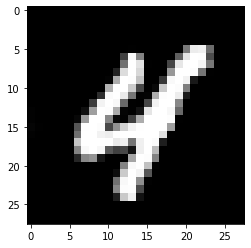

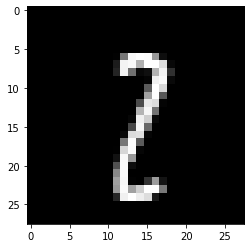

121th iteration gen_loss: 0.3790598213672638 dis_loss: 0.43960100412368774
121th iteration gen_loss: 0.32085052132606506 dis_loss: 0.5376712083816528
121th iteration gen_loss: 0.3929547071456909 dis_loss: 0.47913163900375366
121th iteration gen_loss: 0.2455511838197708 dis_loss: 0.3656897246837616
121th iteration gen_loss: 0.35017889738082886 dis_loss: 0.4398777484893799
121th iteration gen_loss: 0.259242981672287 dis_loss: 0.4432181119918823
121th iteration gen_loss: 0.3834351897239685 dis_loss: 0.4722949266433716
121th iteration gen_loss: 0.3567120134830475 dis_loss: 0.3612601161003113
121th iteration gen_loss: 0.2853326201438904 dis_loss: 0.4050511121749878
121th iteration gen_loss: 0.37433159351348877 dis_loss: 0.45740199089050293
121th iteration gen_loss: 0.5525137186050415 dis_loss: 0.43098393082618713
121th iteration gen_loss: 0.3432820439338684 dis_loss: 0.38469600677490234


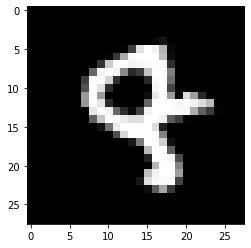

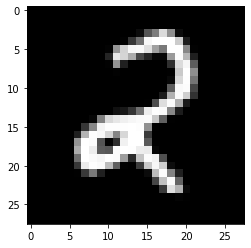

122th iteration gen_loss: 0.268926203250885 dis_loss: 0.39727747440338135
122th iteration gen_loss: 0.27304786443710327 dis_loss: 0.5159144997596741
122th iteration gen_loss: 0.40961918234825134 dis_loss: 0.3547137379646301
122th iteration gen_loss: 0.29170554876327515 dis_loss: 0.505905270576477
122th iteration gen_loss: 0.24692024290561676 dis_loss: 0.4793752133846283
122th iteration gen_loss: 0.34370216727256775 dis_loss: 0.41591984033584595
122th iteration gen_loss: 0.21655982732772827 dis_loss: 0.44893914461135864
122th iteration gen_loss: 0.3203457295894623 dis_loss: 0.4369261860847473
122th iteration gen_loss: 0.3466663360595703 dis_loss: 0.40750789642333984
122th iteration gen_loss: 0.23910586535930634 dis_loss: 0.41605329513549805
122th iteration gen_loss: 0.3914327621459961 dis_loss: 0.4574797749519348
122th iteration gen_loss: 0.3520570397377014 dis_loss: 0.41021692752838135


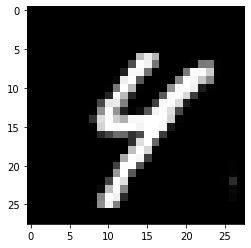

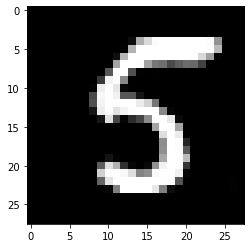

123th iteration gen_loss: 0.46248167753219604 dis_loss: 0.432249516248703
123th iteration gen_loss: 0.4162585437297821 dis_loss: 0.35898566246032715
123th iteration gen_loss: 0.3690778911113739 dis_loss: 0.3982655107975006
123th iteration gen_loss: 0.38349252939224243 dis_loss: 0.43313130736351013
123th iteration gen_loss: 0.43007269501686096 dis_loss: 0.5136907696723938
123th iteration gen_loss: 0.3618268370628357 dis_loss: 0.4374297261238098
123th iteration gen_loss: 0.41512835025787354 dis_loss: 0.4036380648612976
123th iteration gen_loss: 0.3715599775314331 dis_loss: 0.3867145776748657
123th iteration gen_loss: 0.33609697222709656 dis_loss: 0.39216044545173645
123th iteration gen_loss: 0.3513660728931427 dis_loss: 0.36808815598487854
123th iteration gen_loss: 0.3550450801849365 dis_loss: 0.5137832164764404
123th iteration gen_loss: 0.34237441420555115 dis_loss: 0.4776557981967926


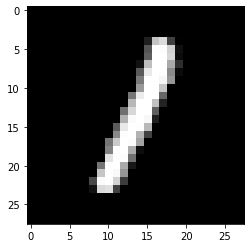

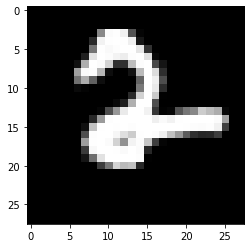

124th iteration gen_loss: 0.3702552318572998 dis_loss: 0.45081475377082825
124th iteration gen_loss: 0.3566516935825348 dis_loss: 0.47429531812667847
124th iteration gen_loss: 0.2852415144443512 dis_loss: 0.3505893051624298
124th iteration gen_loss: 0.19852805137634277 dis_loss: 0.46174150705337524
124th iteration gen_loss: 0.36689266562461853 dis_loss: 0.45574915409088135
124th iteration gen_loss: 0.5938767194747925 dis_loss: 0.4437028765678406
124th iteration gen_loss: 0.21146127581596375 dis_loss: 0.4222789406776428
124th iteration gen_loss: 0.37387388944625854 dis_loss: 0.4281958341598511
124th iteration gen_loss: 0.4349246919155121 dis_loss: 0.45078375935554504
124th iteration gen_loss: 0.48656517267227173 dis_loss: 0.44272345304489136
124th iteration gen_loss: 0.16287975013256073 dis_loss: 0.5013824105262756
124th iteration gen_loss: 0.4566150903701782 dis_loss: 0.45861417055130005


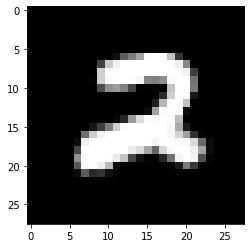

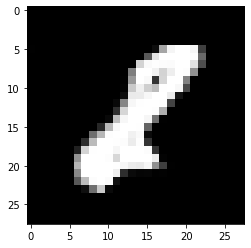

125th iteration gen_loss: 0.35522300004959106 dis_loss: 0.38089245557785034
125th iteration gen_loss: 0.2663376033306122 dis_loss: 0.4596846103668213
125th iteration gen_loss: 0.21876664459705353 dis_loss: 0.4529118537902832
125th iteration gen_loss: 0.40552738308906555 dis_loss: 0.4188024401664734
125th iteration gen_loss: 0.5563373565673828 dis_loss: 0.46303120255470276
125th iteration gen_loss: 0.3218573033809662 dis_loss: 0.40510913729667664
125th iteration gen_loss: 0.3225449323654175 dis_loss: 0.4371015429496765
125th iteration gen_loss: 0.2637034058570862 dis_loss: 0.380319744348526
125th iteration gen_loss: 0.38202688097953796 dis_loss: 0.4094851016998291
125th iteration gen_loss: 0.3641444742679596 dis_loss: 0.44940710067749023
125th iteration gen_loss: 0.3897239565849304 dis_loss: 0.401017963886261
125th iteration gen_loss: 0.27491745352745056 dis_loss: 0.40811970829963684


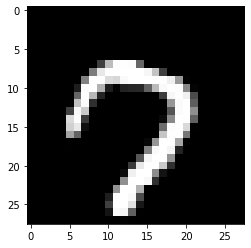

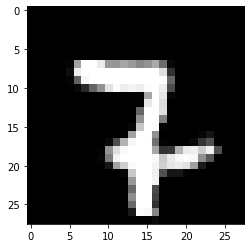

126th iteration gen_loss: 0.3695577085018158 dis_loss: 0.41685670614242554
126th iteration gen_loss: 0.5327300429344177 dis_loss: 0.42297792434692383
126th iteration gen_loss: 0.4173821210861206 dis_loss: 0.3345476984977722
126th iteration gen_loss: 0.3131278455257416 dis_loss: 0.4895733594894409
126th iteration gen_loss: 0.29593393206596375 dis_loss: 0.47442764043807983
126th iteration gen_loss: 0.3260090947151184 dis_loss: 0.377899706363678
126th iteration gen_loss: 0.5371033549308777 dis_loss: 0.41222918033599854
126th iteration gen_loss: 0.45390355587005615 dis_loss: 0.40971726179122925
126th iteration gen_loss: 0.2991489768028259 dis_loss: 0.411926805973053
126th iteration gen_loss: 0.3815009891986847 dis_loss: 0.4534827470779419
126th iteration gen_loss: 0.41862326860427856 dis_loss: 0.41926589608192444
126th iteration gen_loss: 0.29883989691734314 dis_loss: 0.43919312953948975


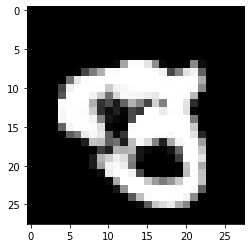

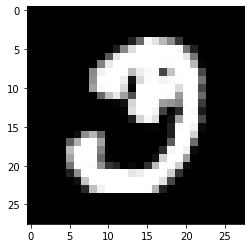

127th iteration gen_loss: 0.3678929805755615 dis_loss: 0.37455517053604126
127th iteration gen_loss: 0.3691025376319885 dis_loss: 0.3708258867263794
127th iteration gen_loss: 0.2274024486541748 dis_loss: 0.4103684425354004
127th iteration gen_loss: 0.300224632024765 dis_loss: 0.40714162588119507
127th iteration gen_loss: 0.27658966183662415 dis_loss: 0.4362785816192627
127th iteration gen_loss: 0.3964973986148834 dis_loss: 0.38705992698669434
127th iteration gen_loss: 0.3450168967247009 dis_loss: 0.3094468116760254
127th iteration gen_loss: 0.4798815846443176 dis_loss: 0.47850149869918823
127th iteration gen_loss: 0.3268360495567322 dis_loss: 0.33375751972198486
127th iteration gen_loss: 0.38523390889167786 dis_loss: 0.5425359606742859
127th iteration gen_loss: 0.30833420157432556 dis_loss: 0.3967980742454529
127th iteration gen_loss: 0.4696905314922333 dis_loss: 0.46796682476997375


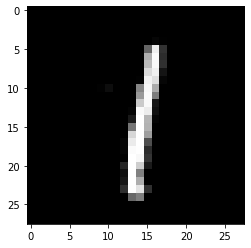

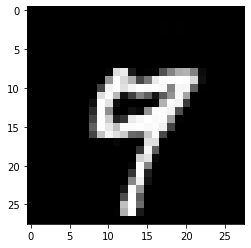

128th iteration gen_loss: 0.3693292438983917 dis_loss: 0.4775981903076172
128th iteration gen_loss: 0.372698038816452 dis_loss: 0.4862985610961914
128th iteration gen_loss: 0.3868505358695984 dis_loss: 0.41899874806404114
128th iteration gen_loss: 0.361855685710907 dis_loss: 0.2623179256916046
128th iteration gen_loss: 0.2637161910533905 dis_loss: 0.40998589992523193
128th iteration gen_loss: 0.29625535011291504 dis_loss: 0.43195298314094543
128th iteration gen_loss: 0.5004541873931885 dis_loss: 0.4741488993167877
128th iteration gen_loss: 0.3475761413574219 dis_loss: 0.5537511110305786
128th iteration gen_loss: 0.3656570017337799 dis_loss: 0.4377534091472626
128th iteration gen_loss: 0.3788173496723175 dis_loss: 0.5654516220092773
128th iteration gen_loss: 0.3407248556613922 dis_loss: 0.3980152904987335
128th iteration gen_loss: 0.4217551350593567 dis_loss: 0.4660186767578125


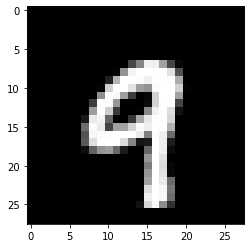

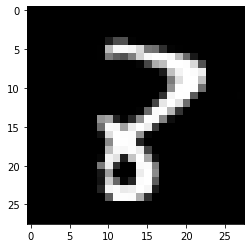

129th iteration gen_loss: 0.27809128165245056 dis_loss: 0.44923919439315796
129th iteration gen_loss: 0.3575557768344879 dis_loss: 0.44047266244888306
129th iteration gen_loss: 0.3593141734600067 dis_loss: 0.411096453666687
129th iteration gen_loss: 0.3146507143974304 dis_loss: 0.40605032444000244
129th iteration gen_loss: 0.3482327163219452 dis_loss: 0.4259262979030609
129th iteration gen_loss: 0.3421212434768677 dis_loss: 0.4278612732887268
129th iteration gen_loss: 0.31032049655914307 dis_loss: 0.35805344581604004
129th iteration gen_loss: 0.4937872290611267 dis_loss: 0.3961613178253174
129th iteration gen_loss: 0.5912878513336182 dis_loss: 0.4315810203552246
129th iteration gen_loss: 0.3537617027759552 dis_loss: 0.49616384506225586
129th iteration gen_loss: 0.4019617438316345 dis_loss: 0.42243504524230957
129th iteration gen_loss: 0.3635474443435669 dis_loss: 0.4860835671424866


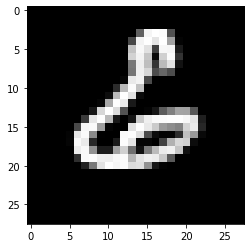

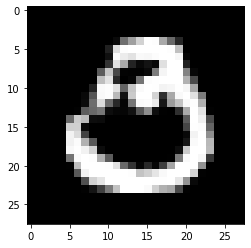

130th iteration gen_loss: 0.254235178232193 dis_loss: 0.3473237156867981
130th iteration gen_loss: 0.3508904278278351 dis_loss: 0.37686222791671753
130th iteration gen_loss: 0.4115711748600006 dis_loss: 0.5687329769134521
130th iteration gen_loss: 0.4857308864593506 dis_loss: 0.3384689688682556
130th iteration gen_loss: 0.5071101784706116 dis_loss: 0.46287834644317627
130th iteration gen_loss: 0.3915148973464966 dis_loss: 0.41528910398483276
130th iteration gen_loss: 0.28454169631004333 dis_loss: 0.3027869462966919
130th iteration gen_loss: 0.47981590032577515 dis_loss: 0.3608642816543579
130th iteration gen_loss: 0.447173535823822 dis_loss: 0.48368993401527405
130th iteration gen_loss: 0.4196053743362427 dis_loss: 0.4148639142513275
130th iteration gen_loss: 0.33042144775390625 dis_loss: 0.36523929238319397
130th iteration gen_loss: 0.27878814935684204 dis_loss: 0.35973721742630005


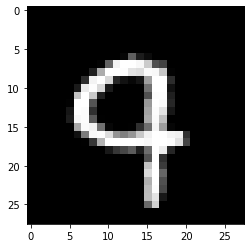

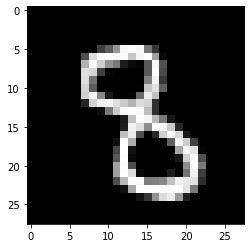

131th iteration gen_loss: 0.31641885638237 dis_loss: 0.3186991214752197
131th iteration gen_loss: 0.395382821559906 dis_loss: 0.6097909212112427
131th iteration gen_loss: 0.24866649508476257 dis_loss: 0.4588565230369568
131th iteration gen_loss: 0.44437551498413086 dis_loss: 0.3921949565410614
131th iteration gen_loss: 0.303893506526947 dis_loss: 0.4100230932235718
131th iteration gen_loss: 0.18709959089756012 dis_loss: 0.3356322944164276
131th iteration gen_loss: 0.42022231221199036 dis_loss: 0.3086507320404053
131th iteration gen_loss: 0.27632948756217957 dis_loss: 0.47168081998825073
131th iteration gen_loss: 0.32202237844467163 dis_loss: 0.43390071392059326
131th iteration gen_loss: 0.3611488342285156 dis_loss: 0.4110603332519531
131th iteration gen_loss: 0.30223318934440613 dis_loss: 0.31925201416015625
131th iteration gen_loss: 0.2683838903903961 dis_loss: 0.3784637451171875


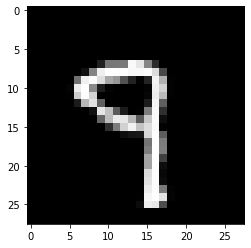

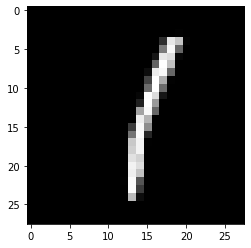

132th iteration gen_loss: 0.2835749089717865 dis_loss: 0.46472835540771484
132th iteration gen_loss: 0.2643398940563202 dis_loss: 0.4557480216026306
132th iteration gen_loss: 0.41668879985809326 dis_loss: 0.42683306336402893
132th iteration gen_loss: 0.34934088587760925 dis_loss: 0.3879481554031372
132th iteration gen_loss: 0.33747032284736633 dis_loss: 0.4380965530872345
132th iteration gen_loss: 0.3080914318561554 dis_loss: 0.5197006464004517
132th iteration gen_loss: 0.41643354296684265 dis_loss: 0.48520392179489136
132th iteration gen_loss: 0.302007794380188 dis_loss: 0.36142879724502563
132th iteration gen_loss: 0.2727958559989929 dis_loss: 0.42208224534988403
132th iteration gen_loss: 0.3662181496620178 dis_loss: 0.5065898895263672
132th iteration gen_loss: 0.6747218370437622 dis_loss: 0.3466343283653259
132th iteration gen_loss: 0.42507246136665344 dis_loss: 0.4250488877296448


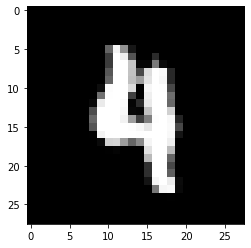

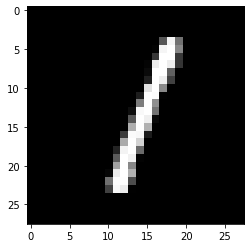

133th iteration gen_loss: 0.4019306004047394 dis_loss: 0.3580549657344818
133th iteration gen_loss: 0.38636595010757446 dis_loss: 0.447907030582428
133th iteration gen_loss: 0.3371015787124634 dis_loss: 0.4692556858062744
133th iteration gen_loss: 0.22754471004009247 dis_loss: 0.3620396852493286
133th iteration gen_loss: 0.3493390679359436 dis_loss: 0.3892412781715393
133th iteration gen_loss: 0.366687536239624 dis_loss: 0.39859631657600403
133th iteration gen_loss: 0.3231446146965027 dis_loss: 0.3593066334724426
133th iteration gen_loss: 0.2820679545402527 dis_loss: 0.5018289089202881
133th iteration gen_loss: 0.3681064248085022 dis_loss: 0.32259470224380493
133th iteration gen_loss: 0.35391494631767273 dis_loss: 0.4241045117378235
133th iteration gen_loss: 0.4177246689796448 dis_loss: 0.4553070068359375
133th iteration gen_loss: 0.45496833324432373 dis_loss: 0.42693716287612915


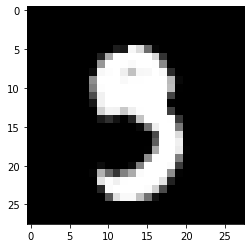

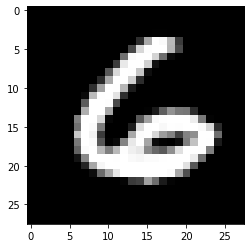

134th iteration gen_loss: 0.29420825839042664 dis_loss: 0.4621034264564514
134th iteration gen_loss: 0.3047850728034973 dis_loss: 0.44394367933273315
134th iteration gen_loss: 0.23073552548885345 dis_loss: 0.3626891076564789
134th iteration gen_loss: 0.3623300790786743 dis_loss: 0.450269877910614
134th iteration gen_loss: 0.31852465867996216 dis_loss: 0.44442349672317505
134th iteration gen_loss: 0.3662807047367096 dis_loss: 0.4241839051246643
134th iteration gen_loss: 0.41544342041015625 dis_loss: 0.4234928488731384
134th iteration gen_loss: 0.2462051510810852 dis_loss: 0.38874828815460205
134th iteration gen_loss: 0.3856422007083893 dis_loss: 0.42172205448150635
134th iteration gen_loss: 0.49575790762901306 dis_loss: 0.46349599957466125
134th iteration gen_loss: 0.3003202974796295 dis_loss: 0.4735298156738281
134th iteration gen_loss: 0.46272921562194824 dis_loss: 0.38141122460365295


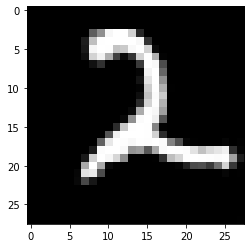

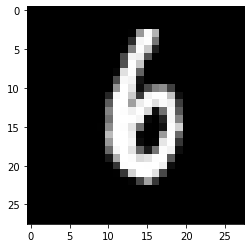

135th iteration gen_loss: 0.3905182480812073 dis_loss: 0.42502361536026
135th iteration gen_loss: 0.3353514075279236 dis_loss: 0.3521050810813904
135th iteration gen_loss: 0.3565211892127991 dis_loss: 0.43949094414711
135th iteration gen_loss: 0.49474483728408813 dis_loss: 0.3880237936973572
135th iteration gen_loss: 0.28675493597984314 dis_loss: 0.40043866634368896
135th iteration gen_loss: 0.35231325030326843 dis_loss: 0.3956713080406189
135th iteration gen_loss: 0.25071439146995544 dis_loss: 0.49409615993499756
135th iteration gen_loss: 0.4300297498703003 dis_loss: 0.39786770939826965
135th iteration gen_loss: 0.3216572403907776 dis_loss: 0.35591650009155273
135th iteration gen_loss: 0.2402781844139099 dis_loss: 0.5480764508247375
135th iteration gen_loss: 0.2796761989593506 dis_loss: 0.3510781526565552
135th iteration gen_loss: 0.35705825686454773 dis_loss: 0.4523189961910248


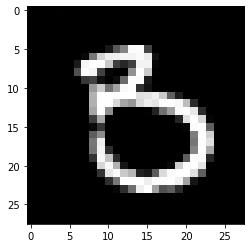

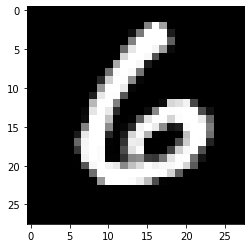

136th iteration gen_loss: 0.40611881017684937 dis_loss: 0.3651852607727051
136th iteration gen_loss: 0.1957019418478012 dis_loss: 0.42422839999198914
136th iteration gen_loss: 0.37891218066215515 dis_loss: 0.43303149938583374
136th iteration gen_loss: 0.28020215034484863 dis_loss: 0.4175761938095093
136th iteration gen_loss: 0.5122987031936646 dis_loss: 0.256240576505661
136th iteration gen_loss: 0.4570870101451874 dis_loss: 0.3201429843902588
136th iteration gen_loss: 0.5477286577224731 dis_loss: 0.45360028743743896
136th iteration gen_loss: 0.43459564447402954 dis_loss: 0.38449427485466003
136th iteration gen_loss: 0.3282845914363861 dis_loss: 0.4278859496116638
136th iteration gen_loss: 0.26242172718048096 dis_loss: 0.3044247031211853
136th iteration gen_loss: 0.6926449537277222 dis_loss: 0.2398139238357544
136th iteration gen_loss: 0.3578099310398102 dis_loss: 0.3450862169265747


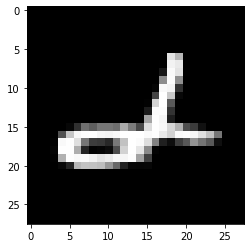

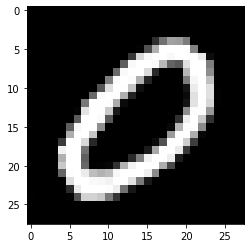

137th iteration gen_loss: 0.5001225471496582 dis_loss: 0.4493454694747925
137th iteration gen_loss: 0.43696528673171997 dis_loss: 0.4461061954498291
137th iteration gen_loss: 0.36623522639274597 dis_loss: 0.44917169213294983
137th iteration gen_loss: 0.2924163043498993 dis_loss: 0.4412573277950287
137th iteration gen_loss: 0.28131696581840515 dis_loss: 0.5171592235565186
137th iteration gen_loss: 0.3369241952896118 dis_loss: 0.3590894937515259
137th iteration gen_loss: 0.3710944354534149 dis_loss: 0.4405979514122009
137th iteration gen_loss: 0.33472365140914917 dis_loss: 0.4166398048400879
137th iteration gen_loss: 0.36749136447906494 dis_loss: 0.41266849637031555
137th iteration gen_loss: 0.3051953911781311 dis_loss: 0.4590369164943695
137th iteration gen_loss: 0.5517392754554749 dis_loss: 0.41229361295700073
137th iteration gen_loss: 0.28804129362106323 dis_loss: 0.4187335968017578


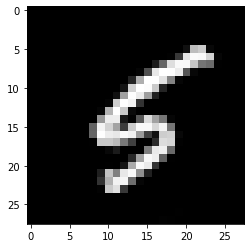

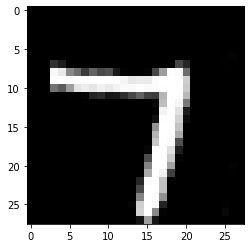

138th iteration gen_loss: 0.2619098126888275 dis_loss: 0.36194485425949097
138th iteration gen_loss: 0.4058879315853119 dis_loss: 0.4480205774307251
138th iteration gen_loss: 0.37373611330986023 dis_loss: 0.416054904460907
138th iteration gen_loss: 0.2413678616285324 dis_loss: 0.43820858001708984
138th iteration gen_loss: 0.3208386301994324 dis_loss: 0.3711671829223633
138th iteration gen_loss: 0.39316633343696594 dis_loss: 0.46043312549591064
138th iteration gen_loss: 0.28651896119117737 dis_loss: 0.3860449194908142
138th iteration gen_loss: 0.534193217754364 dis_loss: 0.40356239676475525
138th iteration gen_loss: 0.28392308950424194 dis_loss: 0.39988237619400024
138th iteration gen_loss: 0.2562498450279236 dis_loss: 0.3929557204246521
138th iteration gen_loss: 0.2997365891933441 dis_loss: 0.407145619392395
138th iteration gen_loss: 0.19004644453525543 dis_loss: 0.3956851363182068


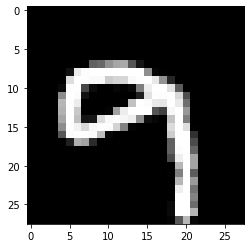

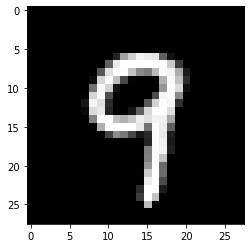

139th iteration gen_loss: 0.31112411618232727 dis_loss: 0.44749727845191956
139th iteration gen_loss: 0.39963632822036743 dis_loss: 0.37413543462753296
139th iteration gen_loss: 0.32382482290267944 dis_loss: 0.4370547831058502
139th iteration gen_loss: 0.49094200134277344 dis_loss: 0.4510701894760132
139th iteration gen_loss: 0.3240727186203003 dis_loss: 0.3958696722984314
139th iteration gen_loss: 0.5696893930435181 dis_loss: 0.36744940280914307
139th iteration gen_loss: 0.48833519220352173 dis_loss: 0.46713149547576904
139th iteration gen_loss: 0.24723955988883972 dis_loss: 0.4859258532524109
139th iteration gen_loss: 0.20238777995109558 dis_loss: 0.38703614473342896
139th iteration gen_loss: 0.3234962821006775 dis_loss: 0.5003353357315063
139th iteration gen_loss: 0.27629202604293823 dis_loss: 0.5189038515090942
139th iteration gen_loss: 0.5213894248008728 dis_loss: 0.4664382338523865


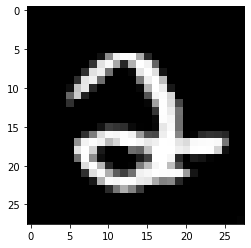

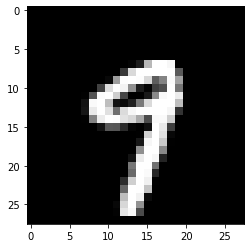

140th iteration gen_loss: 0.3593752682209015 dis_loss: 0.4879862368106842
140th iteration gen_loss: 0.38164854049682617 dis_loss: 0.532799243927002
140th iteration gen_loss: 0.36282965540885925 dis_loss: 0.4076957106590271
140th iteration gen_loss: 0.41277334094047546 dis_loss: 0.4211006760597229
140th iteration gen_loss: 0.4427623748779297 dis_loss: 0.4278513193130493
140th iteration gen_loss: 0.3326488137245178 dis_loss: 0.46256572008132935
140th iteration gen_loss: 0.25938665866851807 dis_loss: 0.5576659440994263
140th iteration gen_loss: 0.30194446444511414 dis_loss: 0.44656622409820557
140th iteration gen_loss: 0.44768011569976807 dis_loss: 0.31013956665992737
140th iteration gen_loss: 0.342886358499527 dis_loss: 0.46937471628189087
140th iteration gen_loss: 0.3871004283428192 dis_loss: 0.5762661099433899
140th iteration gen_loss: 0.42038992047309875 dis_loss: 0.348927766084671


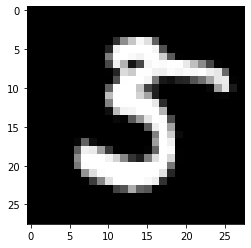

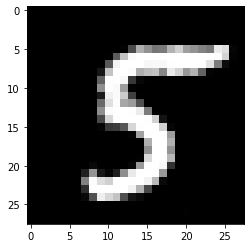

141th iteration gen_loss: 0.17173375189304352 dis_loss: 0.6166079640388489
141th iteration gen_loss: 0.3203372359275818 dis_loss: 0.3978528082370758
141th iteration gen_loss: 0.3626575767993927 dis_loss: 0.45645737648010254
141th iteration gen_loss: 0.3302043080329895 dis_loss: 0.42449307441711426
141th iteration gen_loss: 0.3150464594364166 dis_loss: 0.34347933530807495
141th iteration gen_loss: 0.2789771258831024 dis_loss: 0.38245534896850586
141th iteration gen_loss: 0.3816242814064026 dis_loss: 0.4500085711479187
141th iteration gen_loss: 0.39479514956474304 dis_loss: 0.4091547727584839
141th iteration gen_loss: 0.4026230573654175 dis_loss: 0.41961151361465454
141th iteration gen_loss: 0.41301992535591125 dis_loss: 0.42596399784088135
141th iteration gen_loss: 0.455363005399704 dis_loss: 0.40421217679977417
141th iteration gen_loss: 0.5070058107376099 dis_loss: 0.44642433524131775


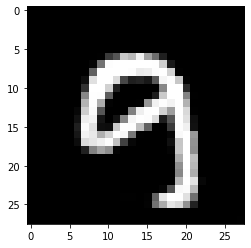

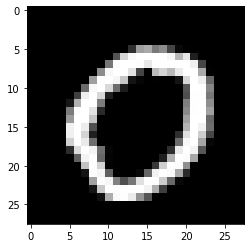

142th iteration gen_loss: 0.32058995962142944 dis_loss: 0.4174821376800537
142th iteration gen_loss: 0.3042038083076477 dis_loss: 0.4397973418235779
142th iteration gen_loss: 0.4955088198184967 dis_loss: 0.43758097290992737
142th iteration gen_loss: 0.4353421628475189 dis_loss: 0.4584835171699524
142th iteration gen_loss: 0.47986456751823425 dis_loss: 0.4613789916038513
142th iteration gen_loss: 0.5512195229530334 dis_loss: 0.42489707469940186
142th iteration gen_loss: 0.35921603441238403 dis_loss: 0.39914196729660034
142th iteration gen_loss: 0.5285049080848694 dis_loss: 0.46395719051361084
142th iteration gen_loss: 0.39047449827194214 dis_loss: 0.4405035972595215
142th iteration gen_loss: 0.454008013010025 dis_loss: 0.4928712546825409
142th iteration gen_loss: 0.368610143661499 dis_loss: 0.40104272961616516
142th iteration gen_loss: 0.4269615709781647 dis_loss: 0.4284924864768982


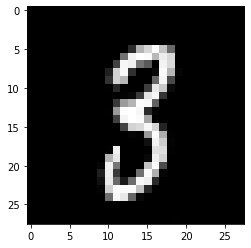

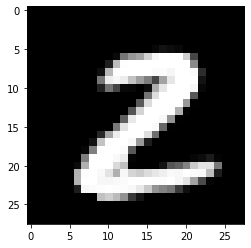

143th iteration gen_loss: 0.38177475333213806 dis_loss: 0.46917152404785156
143th iteration gen_loss: 0.36782699823379517 dis_loss: 0.3568398952484131
143th iteration gen_loss: 0.33588290214538574 dis_loss: 0.48724234104156494
143th iteration gen_loss: 0.5114139318466187 dis_loss: 0.4581144154071808
143th iteration gen_loss: 0.3906022608280182 dis_loss: 0.46042630076408386
143th iteration gen_loss: 0.27303266525268555 dis_loss: 0.48594361543655396
143th iteration gen_loss: 0.3933378756046295 dis_loss: 0.43452703952789307
143th iteration gen_loss: 0.5170350670814514 dis_loss: 0.40627384185791016
143th iteration gen_loss: 0.48605772852897644 dis_loss: 0.39763379096984863
143th iteration gen_loss: 0.29074931144714355 dis_loss: 0.4011382460594177
143th iteration gen_loss: 0.37795573472976685 dis_loss: 0.37389758229255676
143th iteration gen_loss: 0.2568541169166565 dis_loss: 0.482995867729187


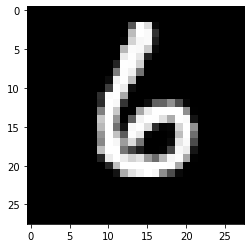

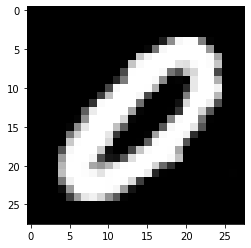

144th iteration gen_loss: 0.3276486098766327 dis_loss: 0.3469736874103546
144th iteration gen_loss: 0.3184417188167572 dis_loss: 0.4928964376449585
144th iteration gen_loss: 0.2229602038860321 dis_loss: 0.3878662586212158
144th iteration gen_loss: 0.5036206841468811 dis_loss: 0.44015443325042725
144th iteration gen_loss: 0.35114166140556335 dis_loss: 0.47818464040756226
144th iteration gen_loss: 0.47433215379714966 dis_loss: 0.47234663367271423
144th iteration gen_loss: 0.5404143333435059 dis_loss: 0.45819151401519775
144th iteration gen_loss: 0.3644564747810364 dis_loss: 0.33637481927871704
144th iteration gen_loss: 0.38485175371170044 dis_loss: 0.4109899401664734
144th iteration gen_loss: 0.4721401631832123 dis_loss: 0.4533824324607849
144th iteration gen_loss: 0.49358686804771423 dis_loss: 0.46567460894584656
144th iteration gen_loss: 0.5675636529922485 dis_loss: 0.39907306432724


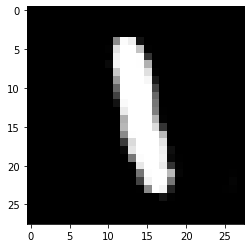

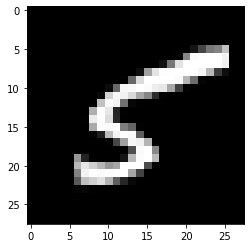

145th iteration gen_loss: 0.22526811063289642 dis_loss: 0.39076805114746094
145th iteration gen_loss: 0.3928292691707611 dis_loss: 0.4379116892814636
145th iteration gen_loss: 0.3608196973800659 dis_loss: 0.41477078199386597
145th iteration gen_loss: 0.4026292562484741 dis_loss: 0.41639792919158936
145th iteration gen_loss: 0.4871369004249573 dis_loss: 0.43700075149536133
145th iteration gen_loss: 0.3498483896255493 dis_loss: 0.4365176558494568
145th iteration gen_loss: 0.31131497025489807 dis_loss: 0.29812735319137573
145th iteration gen_loss: 0.4186128079891205 dis_loss: 0.4431849420070648
145th iteration gen_loss: 0.32457488775253296 dis_loss: 0.38449332118034363
145th iteration gen_loss: 0.44830650091171265 dis_loss: 0.35665762424468994
145th iteration gen_loss: 0.369566410779953 dis_loss: 0.3813084363937378
145th iteration gen_loss: 0.3255734145641327 dis_loss: 0.38404136896133423


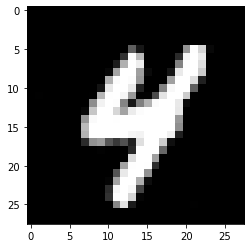

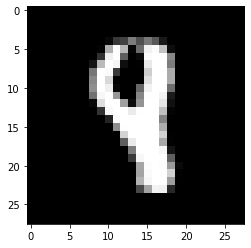

146th iteration gen_loss: 0.4080929458141327 dis_loss: 0.37906134128570557
146th iteration gen_loss: 0.44765031337738037 dis_loss: 0.40536463260650635
146th iteration gen_loss: 0.40354204177856445 dis_loss: 0.3568727672100067
146th iteration gen_loss: 0.3359997570514679 dis_loss: 0.4781695604324341
146th iteration gen_loss: 0.25782641768455505 dis_loss: 0.5171187520027161
146th iteration gen_loss: 0.4189058542251587 dis_loss: 0.30867600440979004
146th iteration gen_loss: 0.29268988966941833 dis_loss: 0.4152413010597229
146th iteration gen_loss: 0.31604546308517456 dis_loss: 0.283886581659317
146th iteration gen_loss: 0.26858416199684143 dis_loss: 0.41559481620788574
146th iteration gen_loss: 0.31858259439468384 dis_loss: 0.4154771566390991
146th iteration gen_loss: 0.49352940917015076 dis_loss: 0.34150707721710205
146th iteration gen_loss: 0.23675090074539185 dis_loss: 0.5196118354797363


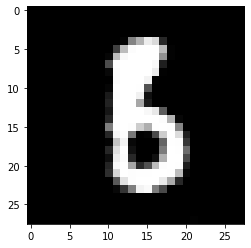

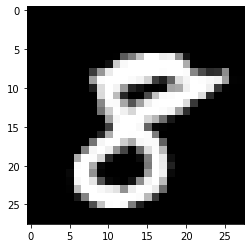

147th iteration gen_loss: 0.34391462802886963 dis_loss: 0.3703382611274719
147th iteration gen_loss: 0.36064618825912476 dis_loss: 0.3833993077278137
147th iteration gen_loss: 0.47016093134880066 dis_loss: 0.5684716701507568
147th iteration gen_loss: 0.2959458827972412 dis_loss: 0.3203839957714081
147th iteration gen_loss: 0.20554879307746887 dis_loss: 0.32317522168159485
147th iteration gen_loss: 0.428445428609848 dis_loss: 0.5607158541679382
147th iteration gen_loss: 0.4386085271835327 dis_loss: 0.37815994024276733
147th iteration gen_loss: 0.33960089087486267 dis_loss: 0.43560487031936646
147th iteration gen_loss: 0.24327071011066437 dis_loss: 0.4789084792137146
147th iteration gen_loss: 0.2794164717197418 dis_loss: 0.3167077898979187
147th iteration gen_loss: 0.40565210580825806 dis_loss: 0.3952677547931671
147th iteration gen_loss: 0.370564728975296 dis_loss: 0.3930209279060364


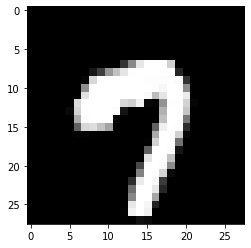

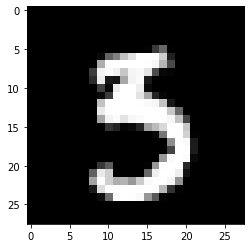

148th iteration gen_loss: 0.4159628450870514 dis_loss: 0.41923463344573975
148th iteration gen_loss: 0.3006127178668976 dis_loss: 0.3946203589439392
148th iteration gen_loss: 0.38455337285995483 dis_loss: 0.36741864681243896
148th iteration gen_loss: 0.3099495470523834 dis_loss: 0.5297480821609497
148th iteration gen_loss: 0.39244142174720764 dis_loss: 0.43224257230758667
148th iteration gen_loss: 0.23382651805877686 dis_loss: 0.45406264066696167
148th iteration gen_loss: 0.32804396748542786 dis_loss: 0.2926342785358429
148th iteration gen_loss: 0.39334386587142944 dis_loss: 0.4291580319404602
148th iteration gen_loss: 0.23537220060825348 dis_loss: 0.3531184792518616
148th iteration gen_loss: 0.2491369992494583 dis_loss: 0.4750765264034271
148th iteration gen_loss: 0.3327864706516266 dis_loss: 0.4248195290565491
148th iteration gen_loss: 0.47970303893089294 dis_loss: 0.4133872985839844


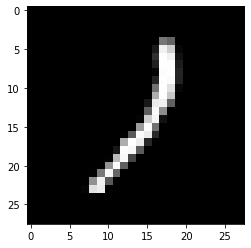

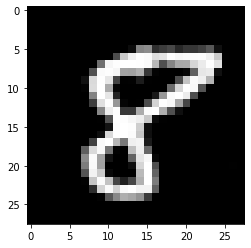

149th iteration gen_loss: 0.2569880485534668 dis_loss: 0.4755684733390808
149th iteration gen_loss: 0.2980799376964569 dis_loss: 0.4816614091396332
149th iteration gen_loss: 0.4070853590965271 dis_loss: 0.42015284299850464
149th iteration gen_loss: 0.2705911099910736 dis_loss: 0.36724790930747986
149th iteration gen_loss: 0.3417973220348358 dis_loss: 0.43480151891708374
149th iteration gen_loss: 0.36640897393226624 dis_loss: 0.43810099363327026
149th iteration gen_loss: 0.40451347827911377 dis_loss: 0.43618518114089966
149th iteration gen_loss: 0.45118147134780884 dis_loss: 0.413659006357193
149th iteration gen_loss: 0.3600507974624634 dis_loss: 0.3801029324531555
149th iteration gen_loss: 0.4519708454608917 dis_loss: 0.4522068202495575
149th iteration gen_loss: 0.5490015149116516 dis_loss: 0.3523499071598053
149th iteration gen_loss: 0.2722223997116089 dis_loss: 0.4311690926551819


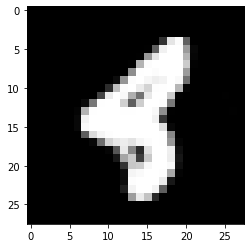

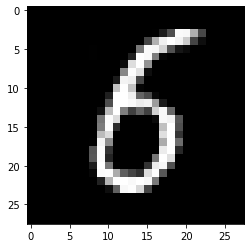

150th iteration gen_loss: 0.23533995449543 dis_loss: 0.30845940113067627
150th iteration gen_loss: 0.3147442936897278 dis_loss: 0.4282369017601013
150th iteration gen_loss: 0.47259795665740967 dis_loss: 0.5622196197509766
150th iteration gen_loss: 0.36761200428009033 dis_loss: 0.5353633165359497
150th iteration gen_loss: 0.4815886914730072 dis_loss: 0.4102182686328888
150th iteration gen_loss: 0.40861496329307556 dis_loss: 0.30408474802970886
150th iteration gen_loss: 0.23858563601970673 dis_loss: 0.3901843726634979
150th iteration gen_loss: 0.22672654688358307 dis_loss: 0.5508778095245361
150th iteration gen_loss: 0.43620210886001587 dis_loss: 0.4905996322631836
150th iteration gen_loss: 0.41163966059684753 dis_loss: 0.43592220544815063
150th iteration gen_loss: 0.33658143877983093 dis_loss: 0.3994593024253845
150th iteration gen_loss: 0.32672998309135437 dis_loss: 0.4530911445617676


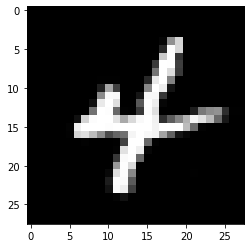

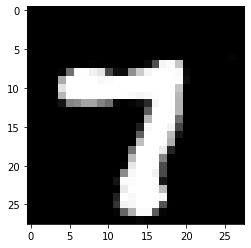

151th iteration gen_loss: 0.3181700110435486 dis_loss: 0.4407464563846588
151th iteration gen_loss: 0.25089362263679504 dis_loss: 0.4422273337841034
151th iteration gen_loss: 0.3155629336833954 dis_loss: 0.393215537071228
151th iteration gen_loss: 0.4059644639492035 dis_loss: 0.3875773549079895
151th iteration gen_loss: 0.3052178621292114 dis_loss: 0.49274587631225586
151th iteration gen_loss: 0.33367544412612915 dis_loss: 0.4835667610168457
151th iteration gen_loss: 0.39780792593955994 dis_loss: 0.41387540102005005
151th iteration gen_loss: 0.469033420085907 dis_loss: 0.5081474781036377
151th iteration gen_loss: 0.4306967854499817 dis_loss: 0.42890501022338867
151th iteration gen_loss: 0.3120022416114807 dis_loss: 0.47513502836227417
151th iteration gen_loss: 0.3990011513233185 dis_loss: 0.46196120977401733
151th iteration gen_loss: 0.3743075728416443 dis_loss: 0.39617234468460083


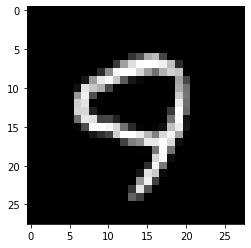

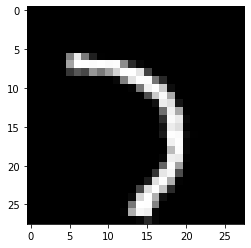

152th iteration gen_loss: 0.19599485397338867 dis_loss: 0.5261461734771729
152th iteration gen_loss: 0.18994757533073425 dis_loss: 0.39572468400001526
152th iteration gen_loss: 0.2887779176235199 dis_loss: 0.43375498056411743
152th iteration gen_loss: 0.5459064245223999 dis_loss: 0.4030458331108093
152th iteration gen_loss: 0.41533252596855164 dis_loss: 0.5210201740264893
152th iteration gen_loss: 0.20848500728607178 dis_loss: 0.5049355626106262
152th iteration gen_loss: 0.5090057253837585 dis_loss: 0.43803462386131287
152th iteration gen_loss: 0.26470255851745605 dis_loss: 0.4966333210468292
152th iteration gen_loss: 0.2613936960697174 dis_loss: 0.3915894627571106
152th iteration gen_loss: 0.47290366888046265 dis_loss: 0.45136627554893494
152th iteration gen_loss: 0.357745498418808 dis_loss: 0.5061873197555542
152th iteration gen_loss: 0.35783475637435913 dis_loss: 0.4896630644798279


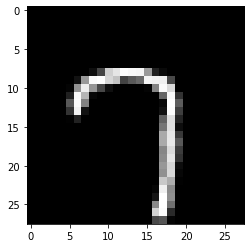

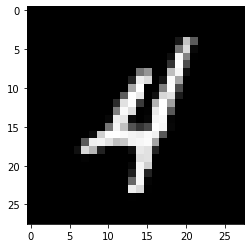

153th iteration gen_loss: 0.4791989326477051 dis_loss: 0.46286702156066895
153th iteration gen_loss: 0.32486051321029663 dis_loss: 0.321529746055603
153th iteration gen_loss: 0.3434857130050659 dis_loss: 0.3790062665939331
153th iteration gen_loss: 0.5116420388221741 dis_loss: 0.4002813398838043
153th iteration gen_loss: 0.4760188162326813 dis_loss: 0.3693668842315674
153th iteration gen_loss: 0.26621344685554504 dis_loss: 0.3613724410533905
153th iteration gen_loss: 0.2957846224308014 dis_loss: 0.4361277222633362
153th iteration gen_loss: 0.28627678751945496 dis_loss: 0.46313777565956116
153th iteration gen_loss: 0.5230254530906677 dis_loss: 0.5364819169044495
153th iteration gen_loss: 0.43629270792007446 dis_loss: 0.453658789396286
153th iteration gen_loss: 0.3940158486366272 dis_loss: 0.4028876721858978
153th iteration gen_loss: 0.2667762339115143 dis_loss: 0.4292318820953369


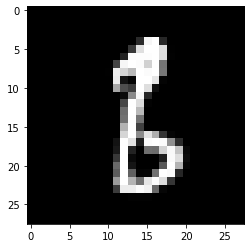

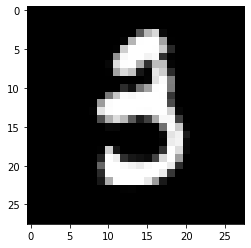

154th iteration gen_loss: 0.5016833543777466 dis_loss: 0.44553983211517334
154th iteration gen_loss: 0.3521517813205719 dis_loss: 0.4347265362739563
154th iteration gen_loss: 0.42163509130477905 dis_loss: 0.48158860206604004
154th iteration gen_loss: 0.2747189700603485 dis_loss: 0.4593866765499115
154th iteration gen_loss: 0.40475723147392273 dis_loss: 0.4385559558868408
154th iteration gen_loss: 0.4520220458507538 dis_loss: 0.40993645787239075
154th iteration gen_loss: 0.2775194048881531 dis_loss: 0.3413333296775818
154th iteration gen_loss: 0.3536183834075928 dis_loss: 0.49945545196533203
154th iteration gen_loss: 0.30785971879959106 dis_loss: 0.5097058415412903
154th iteration gen_loss: 0.3535510301589966 dis_loss: 0.4602629244327545
154th iteration gen_loss: 0.39047569036483765 dis_loss: 0.4519333839416504
154th iteration gen_loss: 0.5132097601890564 dis_loss: 0.3427876830101013


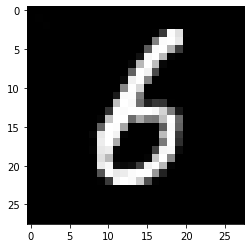

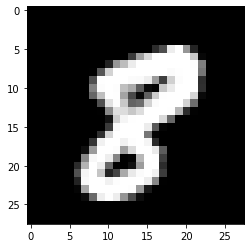

155th iteration gen_loss: 0.331991583108902 dis_loss: 0.4587430953979492
155th iteration gen_loss: 0.44175419211387634 dis_loss: 0.3778632581233978
155th iteration gen_loss: 0.29769426584243774 dis_loss: 0.3524591326713562
155th iteration gen_loss: 0.41963836550712585 dis_loss: 0.4414592981338501
155th iteration gen_loss: 0.30876174569129944 dis_loss: 0.4359024167060852
155th iteration gen_loss: 0.40637731552124023 dis_loss: 0.31895458698272705
155th iteration gen_loss: 0.36807307600975037 dis_loss: 0.5044922232627869
155th iteration gen_loss: 0.28156882524490356 dis_loss: 0.4045005142688751
155th iteration gen_loss: 0.4707435369491577 dis_loss: 0.35267090797424316
155th iteration gen_loss: 0.41629794239997864 dis_loss: 0.44922834634780884
155th iteration gen_loss: 0.3810185492038727 dis_loss: 0.3492034673690796
155th iteration gen_loss: 0.33131203055381775 dis_loss: 0.43522703647613525


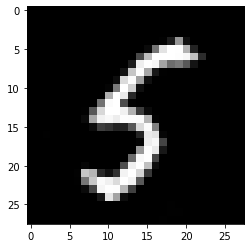

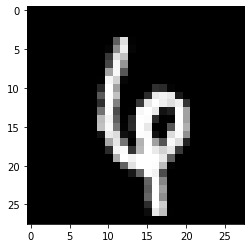

156th iteration gen_loss: 0.21862976253032684 dis_loss: 0.3784337043762207
156th iteration gen_loss: 0.37064000964164734 dis_loss: 0.42938360571861267
156th iteration gen_loss: 0.4591373801231384 dis_loss: 0.514345645904541
156th iteration gen_loss: 0.23069676756858826 dis_loss: 0.5669246912002563
156th iteration gen_loss: 0.3349032402038574 dis_loss: 0.37790024280548096
156th iteration gen_loss: 0.33416908979415894 dis_loss: 0.38929784297943115
156th iteration gen_loss: 0.4102562963962555 dis_loss: 0.469551146030426
156th iteration gen_loss: 0.24715764820575714 dis_loss: 0.4299517571926117
156th iteration gen_loss: 0.43529048562049866 dis_loss: 0.542136549949646
156th iteration gen_loss: 0.5056329369544983 dis_loss: 0.5059884190559387
156th iteration gen_loss: 0.4442087411880493 dis_loss: 0.41078031063079834
156th iteration gen_loss: 0.3588939607143402 dis_loss: 0.3841767907142639


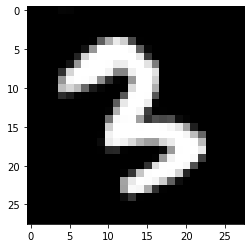

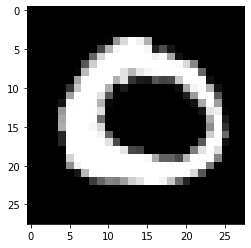

157th iteration gen_loss: 0.40839704871177673 dis_loss: 0.45368480682373047
157th iteration gen_loss: 0.2406562715768814 dis_loss: 0.41155874729156494
157th iteration gen_loss: 0.356749027967453 dis_loss: 0.4329715371131897
157th iteration gen_loss: 0.33391642570495605 dis_loss: 0.305985689163208
157th iteration gen_loss: 0.31374287605285645 dis_loss: 0.46092063188552856
157th iteration gen_loss: 0.49020543694496155 dis_loss: 0.5647144317626953
157th iteration gen_loss: 0.3586992621421814 dis_loss: 0.4053376615047455
157th iteration gen_loss: 0.26040059328079224 dis_loss: 0.37100937962532043
157th iteration gen_loss: 0.36071762442588806 dis_loss: 0.354383647441864
157th iteration gen_loss: 0.2210204005241394 dis_loss: 0.4854445159435272
157th iteration gen_loss: 0.2925291359424591 dis_loss: 0.47331786155700684
157th iteration gen_loss: 0.23716507852077484 dis_loss: 0.3847350776195526


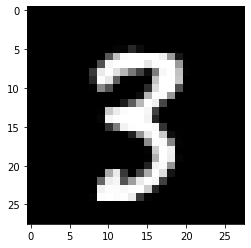

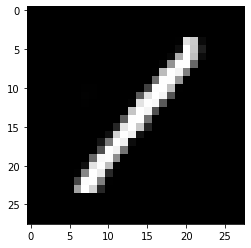

158th iteration gen_loss: 0.35557085275650024 dis_loss: 0.4453802704811096
158th iteration gen_loss: 0.3201785981655121 dis_loss: 0.3930526673793793
158th iteration gen_loss: 0.3573538362979889 dis_loss: 0.6192388534545898
158th iteration gen_loss: 0.23607532680034637 dis_loss: 0.36008715629577637
158th iteration gen_loss: 0.38275641202926636 dis_loss: 0.4561086893081665
158th iteration gen_loss: 0.2175261229276657 dis_loss: 0.46515530347824097
158th iteration gen_loss: 0.27844589948654175 dis_loss: 0.30933821201324463
158th iteration gen_loss: 0.3027224838733673 dis_loss: 0.43962711095809937
158th iteration gen_loss: 0.5059338808059692 dis_loss: 0.44296884536743164
158th iteration gen_loss: 0.38146263360977173 dis_loss: 0.4554471969604492
158th iteration gen_loss: 0.3669871687889099 dis_loss: 0.4411161541938782
158th iteration gen_loss: 0.42142242193222046 dis_loss: 0.3900965452194214


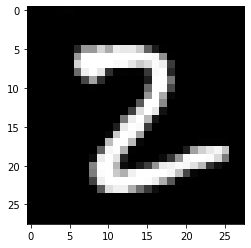

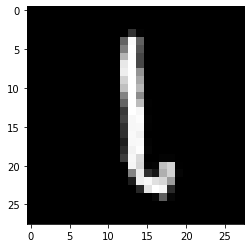

159th iteration gen_loss: 0.23881368339061737 dis_loss: 0.39402902126312256
159th iteration gen_loss: 0.3841647505760193 dis_loss: 0.2886908948421478
159th iteration gen_loss: 0.34390729665756226 dis_loss: 0.360981822013855
159th iteration gen_loss: 0.36827170848846436 dis_loss: 0.4012042284011841
159th iteration gen_loss: 0.2668024003505707 dis_loss: 0.5776834487915039
159th iteration gen_loss: 0.2887917160987854 dis_loss: 0.36242520809173584
159th iteration gen_loss: 0.25705835223197937 dis_loss: 0.44109123945236206
159th iteration gen_loss: 0.4402000308036804 dis_loss: 0.4197767376899719
159th iteration gen_loss: 0.47597768902778625 dis_loss: 0.4772021174430847
159th iteration gen_loss: 0.4464365243911743 dis_loss: 0.47775813937187195
159th iteration gen_loss: 0.3560924530029297 dis_loss: 0.35992711782455444
159th iteration gen_loss: 0.4044685959815979 dis_loss: 0.3732755184173584


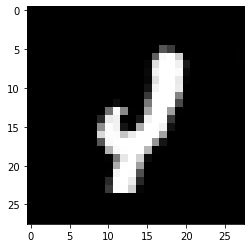

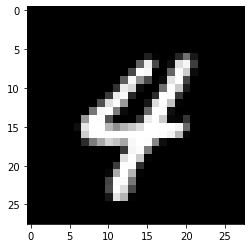

160th iteration gen_loss: 0.3740899860858917 dis_loss: 0.31167829036712646
160th iteration gen_loss: 0.38696029782295227 dis_loss: 0.38202404975891113
160th iteration gen_loss: 0.5737244486808777 dis_loss: 0.43952494859695435
160th iteration gen_loss: 0.4182438552379608 dis_loss: 0.4207409620285034
160th iteration gen_loss: 0.2726663649082184 dis_loss: 0.3240154981613159
160th iteration gen_loss: 0.30743294954299927 dis_loss: 0.35918253660202026
160th iteration gen_loss: 0.26321539282798767 dis_loss: 0.3482590913772583
160th iteration gen_loss: 0.291535347700119 dis_loss: 0.4491783082485199
160th iteration gen_loss: 0.3303566575050354 dis_loss: 0.5232212543487549
160th iteration gen_loss: 0.37497663497924805 dis_loss: 0.39871832728385925
160th iteration gen_loss: 0.2679557502269745 dis_loss: 0.5250371694564819
160th iteration gen_loss: 0.27416983246803284 dis_loss: 0.36221909523010254


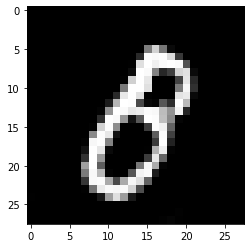

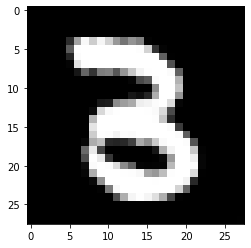

161th iteration gen_loss: 0.4724825620651245 dis_loss: 0.3276274800300598
161th iteration gen_loss: 0.3972751498222351 dis_loss: 0.46465587615966797
161th iteration gen_loss: 0.5072463750839233 dis_loss: 0.4974040985107422
161th iteration gen_loss: 0.3468020558357239 dis_loss: 0.38323694467544556
161th iteration gen_loss: 0.44879376888275146 dis_loss: 0.4178149104118347
161th iteration gen_loss: 0.2925257682800293 dis_loss: 0.46517616510391235
161th iteration gen_loss: 0.47277167439460754 dis_loss: 0.47300711274147034
161th iteration gen_loss: 0.40601715445518494 dis_loss: 0.3406078517436981
161th iteration gen_loss: 0.4821661412715912 dis_loss: 0.4772045314311981
161th iteration gen_loss: 0.32984617352485657 dis_loss: 0.4362313151359558
161th iteration gen_loss: 0.3554636240005493 dis_loss: 0.5464903116226196
161th iteration gen_loss: 0.38293325901031494 dis_loss: 0.37011370062828064


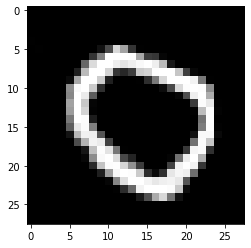

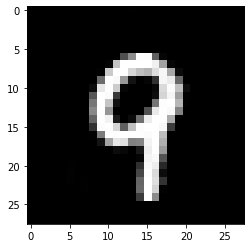

162th iteration gen_loss: 0.3061583340167999 dis_loss: 0.3865875005722046
162th iteration gen_loss: 0.2865419387817383 dis_loss: 0.4470508098602295
162th iteration gen_loss: 0.36181846261024475 dis_loss: 0.5488857626914978
162th iteration gen_loss: 0.3952842652797699 dis_loss: 0.4778788685798645
162th iteration gen_loss: 0.4213978350162506 dis_loss: 0.4367530941963196
162th iteration gen_loss: 0.3380332887172699 dis_loss: 0.3908979892730713
162th iteration gen_loss: 0.5035442113876343 dis_loss: 0.34653744101524353
162th iteration gen_loss: 0.23620763421058655 dis_loss: 0.3323943614959717
162th iteration gen_loss: 0.42222511768341064 dis_loss: 0.3928341567516327
162th iteration gen_loss: 0.2704097032546997 dis_loss: 0.30685269832611084
162th iteration gen_loss: 0.33037424087524414 dis_loss: 0.31819769740104675
162th iteration gen_loss: 0.38067933917045593 dis_loss: 0.34087860584259033


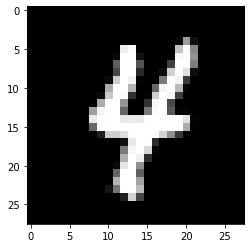

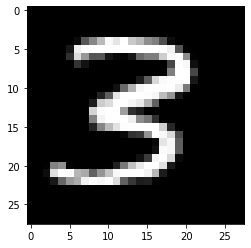

163th iteration gen_loss: 0.2614626884460449 dis_loss: 0.44237256050109863
163th iteration gen_loss: 0.2089773267507553 dis_loss: 0.5522599220275879
163th iteration gen_loss: 0.2542128264904022 dis_loss: 0.4352431297302246
163th iteration gen_loss: 0.2792673707008362 dis_loss: 0.44501516222953796
163th iteration gen_loss: 0.32574933767318726 dis_loss: 0.5519052147865295
163th iteration gen_loss: 0.34609413146972656 dis_loss: 0.3732762038707733
163th iteration gen_loss: 0.3441864848136902 dis_loss: 0.442594975233078
163th iteration gen_loss: 0.4341699182987213 dis_loss: 0.4936171770095825
163th iteration gen_loss: 0.43345770239830017 dis_loss: 0.3801267743110657
163th iteration gen_loss: 0.3581780791282654 dis_loss: 0.46915456652641296
163th iteration gen_loss: 0.264964759349823 dis_loss: 0.4558233618736267
163th iteration gen_loss: 0.299591064453125 dis_loss: 0.5608699917793274


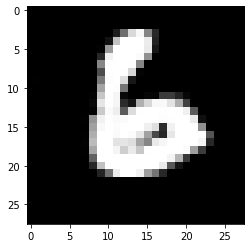

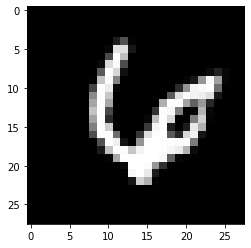

164th iteration gen_loss: 0.4085603952407837 dis_loss: 0.33259350061416626
164th iteration gen_loss: 0.3097778260707855 dis_loss: 0.45926034450531006
164th iteration gen_loss: 0.2614854872226715 dis_loss: 0.47716230154037476
164th iteration gen_loss: 0.18696729838848114 dis_loss: 0.5791493058204651
164th iteration gen_loss: 0.4144238829612732 dis_loss: 0.47564762830734253
164th iteration gen_loss: 0.300583153963089 dis_loss: 0.4948817491531372
164th iteration gen_loss: 0.3673219084739685 dis_loss: 0.412456750869751
164th iteration gen_loss: 0.3218744993209839 dis_loss: 0.4367229640483856
164th iteration gen_loss: 0.4016212224960327 dis_loss: 0.4412226676940918
164th iteration gen_loss: 0.36580005288124084 dis_loss: 0.49082887172698975
164th iteration gen_loss: 0.3020518720149994 dis_loss: 0.4542340338230133
164th iteration gen_loss: 0.37373244762420654 dis_loss: 0.5000460743904114


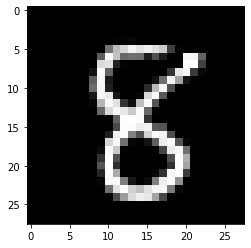

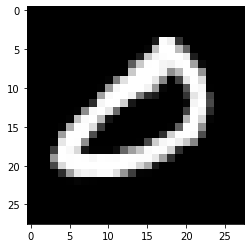

165th iteration gen_loss: 0.47541606426239014 dis_loss: 0.3706197142601013
165th iteration gen_loss: 0.4770975410938263 dis_loss: 0.38104987144470215
165th iteration gen_loss: 0.3854169249534607 dis_loss: 0.4142272472381592
165th iteration gen_loss: 0.20346887409687042 dis_loss: 0.3965190351009369
165th iteration gen_loss: 0.35710182785987854 dis_loss: 0.4711751639842987
165th iteration gen_loss: 0.294005811214447 dis_loss: 0.5653847455978394
165th iteration gen_loss: 0.2499970644712448 dis_loss: 0.5994892120361328
165th iteration gen_loss: 0.27019575238227844 dis_loss: 0.4468419551849365
165th iteration gen_loss: 0.3309915065765381 dis_loss: 0.35004428029060364
165th iteration gen_loss: 0.2991131842136383 dis_loss: 0.43780815601348877
165th iteration gen_loss: 0.27884963154792786 dis_loss: 0.3408948481082916
165th iteration gen_loss: 0.34561121463775635 dis_loss: 0.4606706202030182


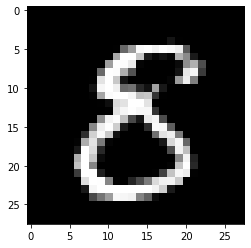

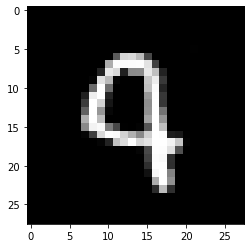

166th iteration gen_loss: 0.26180315017700195 dis_loss: 0.3246903717517853
166th iteration gen_loss: 0.5524648427963257 dis_loss: 0.3506211042404175
166th iteration gen_loss: 0.42693471908569336 dis_loss: 0.48721301555633545
166th iteration gen_loss: 0.3289187252521515 dis_loss: 0.4794796109199524
166th iteration gen_loss: 0.33586767315864563 dis_loss: 0.3847896456718445
166th iteration gen_loss: 0.3925476670265198 dis_loss: 0.44214582443237305
166th iteration gen_loss: 0.23874366283416748 dis_loss: 0.43026185035705566
166th iteration gen_loss: 0.3926471769809723 dis_loss: 0.42121201753616333
166th iteration gen_loss: 0.3639990985393524 dis_loss: 0.45948779582977295
166th iteration gen_loss: 0.4140040874481201 dis_loss: 0.4021419882774353
166th iteration gen_loss: 0.39263132214546204 dis_loss: 0.40822094678878784
166th iteration gen_loss: 0.4764900505542755 dis_loss: 0.40840500593185425


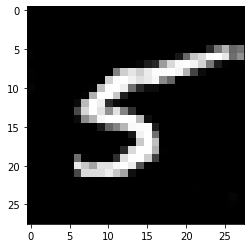

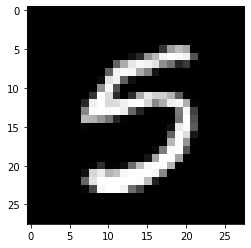

167th iteration gen_loss: 0.37885287404060364 dis_loss: 0.4481227993965149
167th iteration gen_loss: 0.3430516719818115 dis_loss: 0.38900864124298096
167th iteration gen_loss: 0.32147446274757385 dis_loss: 0.35809892416000366
167th iteration gen_loss: 0.3902021050453186 dis_loss: 0.43722301721572876
167th iteration gen_loss: 0.409106582403183 dis_loss: 0.43940815329551697
167th iteration gen_loss: 0.36135241389274597 dis_loss: 0.3559757471084595
167th iteration gen_loss: 0.2352013736963272 dis_loss: 0.37143808603286743
167th iteration gen_loss: 0.33170390129089355 dis_loss: 0.504490852355957
167th iteration gen_loss: 0.3282299041748047 dis_loss: 0.41371285915374756
167th iteration gen_loss: 0.32780686020851135 dis_loss: 0.41948041319847107
167th iteration gen_loss: 0.3847113251686096 dis_loss: 0.41398608684539795
167th iteration gen_loss: 0.35490038990974426 dis_loss: 0.36053264141082764


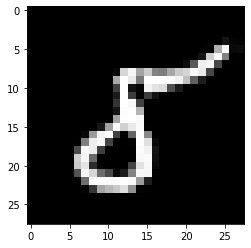

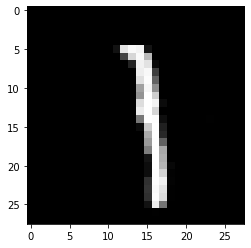

168th iteration gen_loss: 0.3198281228542328 dis_loss: 0.45705854892730713
168th iteration gen_loss: 0.22298121452331543 dis_loss: 0.4569220542907715
168th iteration gen_loss: 0.4546407461166382 dis_loss: 0.41057494282722473
168th iteration gen_loss: 0.39394450187683105 dis_loss: 0.35045140981674194
168th iteration gen_loss: 0.38126862049102783 dis_loss: 0.3784360885620117
168th iteration gen_loss: 0.4225899279117584 dis_loss: 0.41313436627388
168th iteration gen_loss: 0.39904627203941345 dis_loss: 0.4531044363975525
168th iteration gen_loss: 0.3623040020465851 dis_loss: 0.4107748866081238
168th iteration gen_loss: 0.4352021813392639 dis_loss: 0.37540334463119507
168th iteration gen_loss: 0.2509795129299164 dis_loss: 0.45062461495399475
168th iteration gen_loss: 0.40913572907447815 dis_loss: 0.3437481224536896
168th iteration gen_loss: 0.4360566735267639 dis_loss: 0.3652728796005249


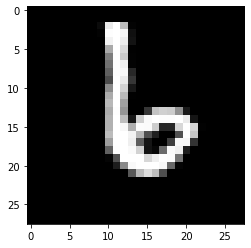

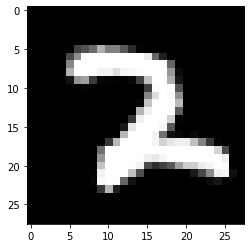

169th iteration gen_loss: 0.4560562074184418 dis_loss: 0.4654492139816284
169th iteration gen_loss: 0.3416178822517395 dis_loss: 0.37378787994384766
169th iteration gen_loss: 0.30674517154693604 dis_loss: 0.41196030378341675
169th iteration gen_loss: 0.3350563645362854 dis_loss: 0.45315200090408325
169th iteration gen_loss: 0.34233734011650085 dis_loss: 0.46039456129074097
169th iteration gen_loss: 0.433226078748703 dis_loss: 0.4024773836135864
169th iteration gen_loss: 0.2762363851070404 dis_loss: 0.3936764895915985
169th iteration gen_loss: 0.4811391830444336 dis_loss: 0.2798290550708771
169th iteration gen_loss: 0.3809574842453003 dis_loss: 0.33986765146255493
169th iteration gen_loss: 0.24510489404201508 dis_loss: 0.5010573863983154
169th iteration gen_loss: 0.4064834415912628 dis_loss: 0.4136431813240051
169th iteration gen_loss: 0.3415570855140686 dis_loss: 0.4068353772163391


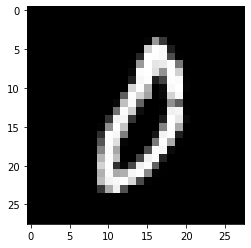

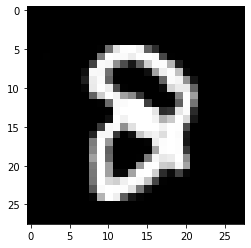

170th iteration gen_loss: 0.30820605158805847 dis_loss: 0.4649195373058319
170th iteration gen_loss: 0.3015068471431732 dis_loss: 0.37467047572135925
170th iteration gen_loss: 0.32517656683921814 dis_loss: 0.44617968797683716
170th iteration gen_loss: 0.44573551416397095 dis_loss: 0.4219903349876404
170th iteration gen_loss: 0.30555102229118347 dis_loss: 0.42164361476898193
170th iteration gen_loss: 0.5188947916030884 dis_loss: 0.38605797290802
170th iteration gen_loss: 0.4497532248497009 dis_loss: 0.2871887981891632
170th iteration gen_loss: 0.5606223344802856 dis_loss: 0.5528116226196289
170th iteration gen_loss: 0.5168761610984802 dis_loss: 0.4788479506969452
170th iteration gen_loss: 0.36552393436431885 dis_loss: 0.4099350571632385
170th iteration gen_loss: 0.3702006936073303 dis_loss: 0.40159547328948975
170th iteration gen_loss: 0.5070329308509827 dis_loss: 0.4514002799987793


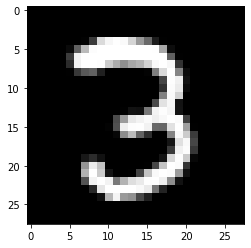

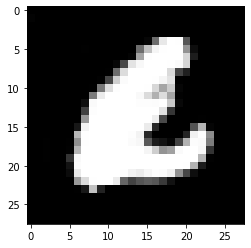

171th iteration gen_loss: 0.2882594168186188 dis_loss: 0.3349985182285309
171th iteration gen_loss: 0.44334137439727783 dis_loss: 0.4770825505256653
171th iteration gen_loss: 0.3264705240726471 dis_loss: 0.34888994693756104
171th iteration gen_loss: 0.4043588936328888 dis_loss: 0.40757670998573303
171th iteration gen_loss: 0.2812283933162689 dis_loss: 0.3082268238067627
171th iteration gen_loss: 0.4402048885822296 dis_loss: 0.442555695772171
171th iteration gen_loss: 0.505003035068512 dis_loss: 0.516318142414093
171th iteration gen_loss: 0.41590556502342224 dis_loss: 0.3005973696708679
171th iteration gen_loss: 0.42409807443618774 dis_loss: 0.4046844244003296
171th iteration gen_loss: 0.3356121778488159 dis_loss: 0.47919005155563354
171th iteration gen_loss: 0.3305593729019165 dis_loss: 0.45603179931640625
171th iteration gen_loss: 0.2973881959915161 dis_loss: 0.37085843086242676


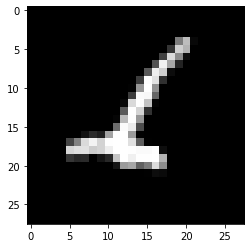

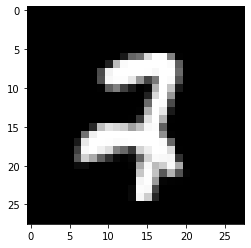

172th iteration gen_loss: 0.5116409063339233 dis_loss: 0.3315218687057495
172th iteration gen_loss: 0.12064819037914276 dis_loss: 0.44585320353507996
172th iteration gen_loss: 0.30921459197998047 dis_loss: 0.3934487998485565
172th iteration gen_loss: 0.35803884267807007 dis_loss: 0.43344277143478394
172th iteration gen_loss: 0.3747764527797699 dis_loss: 0.33649182319641113
172th iteration gen_loss: 0.5703252553939819 dis_loss: 0.4717934727668762
172th iteration gen_loss: 0.406544029712677 dis_loss: 0.44301819801330566
172th iteration gen_loss: 0.23687288165092468 dis_loss: 0.5827670097351074
172th iteration gen_loss: 0.31581830978393555 dis_loss: 0.4219099283218384
172th iteration gen_loss: 0.23131762444972992 dis_loss: 0.47679203748703003
172th iteration gen_loss: 0.4806465804576874 dis_loss: 0.4245336055755615
172th iteration gen_loss: 0.39765480160713196 dis_loss: 0.4731489419937134


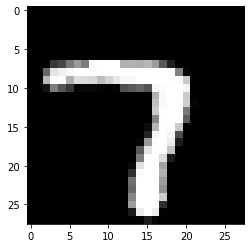

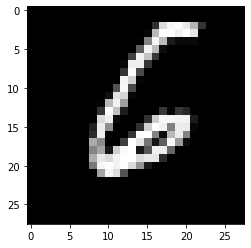

173th iteration gen_loss: 0.20076976716518402 dis_loss: 0.42061901092529297
173th iteration gen_loss: 0.31754663586616516 dis_loss: 0.4268174171447754
173th iteration gen_loss: 0.3159181773662567 dis_loss: 0.39794737100601196
173th iteration gen_loss: 0.4800308644771576 dis_loss: 0.37577900290489197
173th iteration gen_loss: 0.4879790246486664 dis_loss: 0.25031185150146484
173th iteration gen_loss: 0.24357196688652039 dis_loss: 0.4703456163406372
173th iteration gen_loss: 0.5520118474960327 dis_loss: 0.46668386459350586
173th iteration gen_loss: 0.3452984690666199 dis_loss: 0.33415576815605164
173th iteration gen_loss: 0.3587559759616852 dis_loss: 0.4488776922225952
173th iteration gen_loss: 0.24097083508968353 dis_loss: 0.37071606516838074
173th iteration gen_loss: 0.297346830368042 dis_loss: 0.35367000102996826
173th iteration gen_loss: 0.30580610036849976 dis_loss: 0.42294761538505554


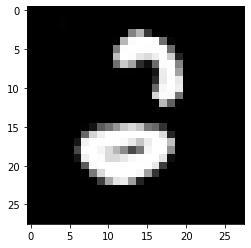

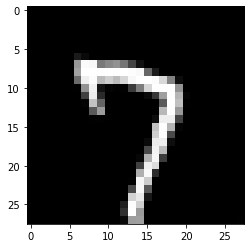

174th iteration gen_loss: 0.32402440905570984 dis_loss: 0.4147031307220459
174th iteration gen_loss: 0.3860096037387848 dis_loss: 0.39978572726249695
174th iteration gen_loss: 0.4081394076347351 dis_loss: 0.6136422157287598
174th iteration gen_loss: 0.4553377330303192 dis_loss: 0.6070371866226196
174th iteration gen_loss: 0.17285053431987762 dis_loss: 0.4657275080680847
174th iteration gen_loss: 0.256226122379303 dis_loss: 0.34693726897239685
174th iteration gen_loss: 0.3342996835708618 dis_loss: 0.38450610637664795
174th iteration gen_loss: 0.34979137778282166 dis_loss: 0.40113985538482666
174th iteration gen_loss: 0.2328818440437317 dis_loss: 0.2891664505004883
174th iteration gen_loss: 0.5235268473625183 dis_loss: 0.6038167476654053
174th iteration gen_loss: 0.5374507904052734 dis_loss: 0.4760226905345917
174th iteration gen_loss: 0.3587282598018646 dis_loss: 0.5082316994667053


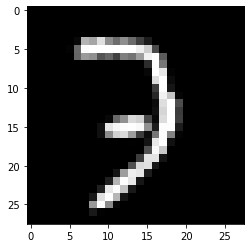

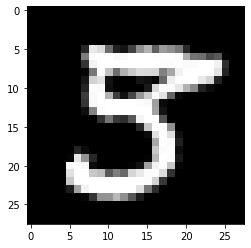

175th iteration gen_loss: 0.3487246632575989 dis_loss: 0.44177696108818054
175th iteration gen_loss: 0.3736366927623749 dis_loss: 0.3473879396915436
175th iteration gen_loss: 0.40307772159576416 dis_loss: 0.3421802520751953
175th iteration gen_loss: 0.4211389720439911 dis_loss: 0.3737669289112091
175th iteration gen_loss: 0.5281276702880859 dis_loss: 0.4661960303783417
175th iteration gen_loss: 0.425505131483078 dis_loss: 0.3282429575920105
175th iteration gen_loss: 0.35477346181869507 dis_loss: 0.3758052885532379
175th iteration gen_loss: 0.41631418466567993 dis_loss: 0.3542614281177521
175th iteration gen_loss: 0.5010280013084412 dis_loss: 0.5165903568267822
175th iteration gen_loss: 0.3406669497489929 dis_loss: 0.3388516306877136
175th iteration gen_loss: 0.4369584619998932 dis_loss: 0.31052160263061523
175th iteration gen_loss: 0.4639357030391693 dis_loss: 0.38132214546203613


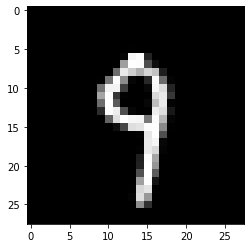

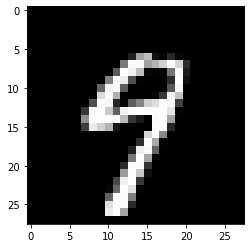

176th iteration gen_loss: 0.43452444672584534 dis_loss: 0.515380322933197
176th iteration gen_loss: 0.256510466337204 dis_loss: 0.49237263202667236
176th iteration gen_loss: 0.3807806074619293 dis_loss: 0.3430114984512329
176th iteration gen_loss: 0.4044423997402191 dis_loss: 0.4835926294326782
176th iteration gen_loss: 0.3294300138950348 dis_loss: 0.38338854908943176
176th iteration gen_loss: 0.5321954488754272 dis_loss: 0.32958564162254333
176th iteration gen_loss: 0.38210052251815796 dis_loss: 0.44017940759658813
176th iteration gen_loss: 0.22058027982711792 dis_loss: 0.23820608854293823
176th iteration gen_loss: 0.2359466552734375 dis_loss: 0.38577061891555786
176th iteration gen_loss: 0.5039111971855164 dis_loss: 0.4065799117088318
176th iteration gen_loss: 0.3890480399131775 dis_loss: 0.454038143157959
176th iteration gen_loss: 0.42530348896980286 dis_loss: 0.37320464849472046


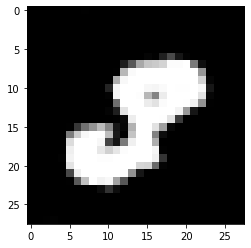

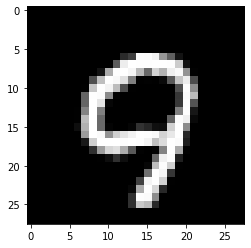

177th iteration gen_loss: 0.3308412730693817 dis_loss: 0.3650513291358948
177th iteration gen_loss: 0.5278059840202332 dis_loss: 0.388344407081604
177th iteration gen_loss: 0.38704878091812134 dis_loss: 0.4373883008956909
177th iteration gen_loss: 0.2781994044780731 dis_loss: 0.3909359276294708
177th iteration gen_loss: 0.4137324392795563 dis_loss: 0.39641907811164856
177th iteration gen_loss: 0.31279268860816956 dis_loss: 0.4007013440132141
177th iteration gen_loss: 0.31267672777175903 dis_loss: 0.3591388463973999
177th iteration gen_loss: 0.27263912558555603 dis_loss: 0.4929937720298767
177th iteration gen_loss: 0.387451171875 dis_loss: 0.2764352858066559
177th iteration gen_loss: 0.4185582399368286 dis_loss: 0.3659619688987732
177th iteration gen_loss: 0.26241329312324524 dis_loss: 0.34937140345573425
177th iteration gen_loss: 0.3769044280052185 dis_loss: 0.38309359550476074


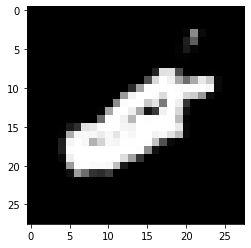

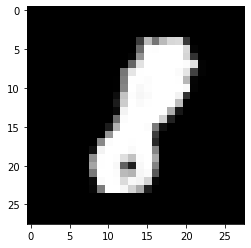

178th iteration gen_loss: 0.45370543003082275 dis_loss: 0.39730769395828247
178th iteration gen_loss: 0.40017303824424744 dis_loss: 0.3340029716491699
178th iteration gen_loss: 0.5037894248962402 dis_loss: 0.4527819752693176
178th iteration gen_loss: 0.5598074197769165 dis_loss: 0.4860009551048279
178th iteration gen_loss: 0.35395094752311707 dis_loss: 0.42923206090927124
178th iteration gen_loss: 0.41907042264938354 dis_loss: 0.36840152740478516
178th iteration gen_loss: 0.39741092920303345 dis_loss: 0.4717015027999878
178th iteration gen_loss: 0.3115972876548767 dis_loss: 0.4271462559700012
178th iteration gen_loss: 0.5389283895492554 dis_loss: 0.3442017138004303
178th iteration gen_loss: 0.5885465145111084 dis_loss: 0.1887555867433548
178th iteration gen_loss: 0.3405529856681824 dis_loss: 0.35449379682540894
178th iteration gen_loss: 0.20012351870536804 dis_loss: 0.46986496448516846


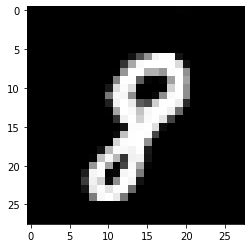

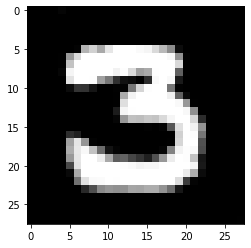

179th iteration gen_loss: 0.32214635610580444 dis_loss: 0.3541680574417114
179th iteration gen_loss: 0.5562450289726257 dis_loss: 0.4112708270549774
179th iteration gen_loss: 0.4719335734844208 dis_loss: 0.4810802638530731
179th iteration gen_loss: 0.42219078540802 dis_loss: 0.4324273467063904
179th iteration gen_loss: 0.47411105036735535 dis_loss: 0.3926659822463989
179th iteration gen_loss: 0.3515840768814087 dis_loss: 0.45286500453948975
179th iteration gen_loss: 0.4958275556564331 dis_loss: 0.4205237627029419
179th iteration gen_loss: 0.3897862136363983 dis_loss: 0.4390231966972351
179th iteration gen_loss: 0.39392343163490295 dis_loss: 0.3844679594039917
179th iteration gen_loss: 0.37469688057899475 dis_loss: 0.3451225757598877
179th iteration gen_loss: 0.3922213613986969 dis_loss: 0.34995654225349426
179th iteration gen_loss: 0.37302690744400024 dis_loss: 0.3978879153728485


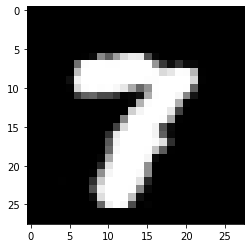

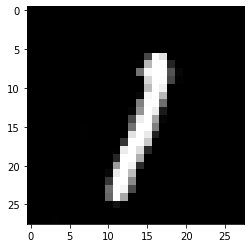

180th iteration gen_loss: 0.41573116183280945 dis_loss: 0.35799670219421387
180th iteration gen_loss: 0.469576895236969 dis_loss: 0.4795096516609192
180th iteration gen_loss: 0.20803141593933105 dis_loss: 0.4804631769657135
180th iteration gen_loss: 0.3364402651786804 dis_loss: 0.48728883266448975
180th iteration gen_loss: 0.47580572962760925 dis_loss: 0.514546811580658
180th iteration gen_loss: 0.42903974652290344 dis_loss: 0.3847510814666748
180th iteration gen_loss: 0.39791029691696167 dis_loss: 0.3548422157764435
180th iteration gen_loss: 0.49266454577445984 dis_loss: 0.4840927720069885
180th iteration gen_loss: 0.501262366771698 dis_loss: 0.36505842208862305
180th iteration gen_loss: 0.44685423374176025 dis_loss: 0.39569899439811707
180th iteration gen_loss: 0.34460896253585815 dis_loss: 0.4277092218399048
180th iteration gen_loss: 0.3643704652786255 dis_loss: 0.5457141995429993


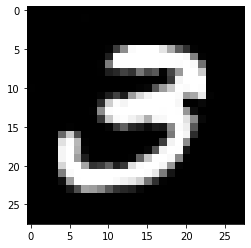

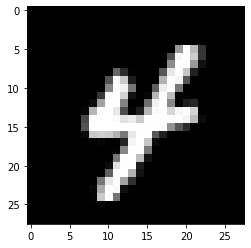

181th iteration gen_loss: 0.3785353899002075 dis_loss: 0.35984617471694946
181th iteration gen_loss: 0.5099564790725708 dis_loss: 0.3162832260131836
181th iteration gen_loss: 0.5716723799705505 dis_loss: 0.49012303352355957
181th iteration gen_loss: 0.33525973558425903 dis_loss: 0.3158615231513977
181th iteration gen_loss: 0.35640284419059753 dis_loss: 0.40068238973617554
181th iteration gen_loss: 0.3316984474658966 dis_loss: 0.4443684220314026
181th iteration gen_loss: 0.3679526448249817 dis_loss: 0.30859601497650146
181th iteration gen_loss: 0.2998765707015991 dis_loss: 0.3904043436050415
181th iteration gen_loss: 0.3029640316963196 dis_loss: 0.3248438835144043
181th iteration gen_loss: 0.48904913663864136 dis_loss: 0.37168771028518677
181th iteration gen_loss: 0.4286634624004364 dis_loss: 0.4316062331199646
181th iteration gen_loss: 0.4381583631038666 dis_loss: 0.4157606065273285


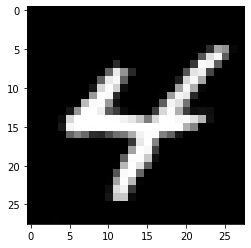

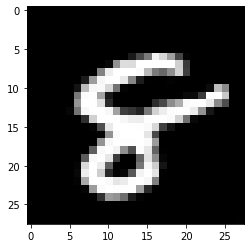

182th iteration gen_loss: 0.2976910471916199 dis_loss: 0.49618732929229736
182th iteration gen_loss: 0.3806106448173523 dis_loss: 0.3952156901359558
182th iteration gen_loss: 0.4300166666507721 dis_loss: 0.30364489555358887
182th iteration gen_loss: 0.1737145036458969 dis_loss: 0.634750485420227
182th iteration gen_loss: 0.33826056122779846 dis_loss: 0.3890096843242645
182th iteration gen_loss: 0.34440210461616516 dis_loss: 0.38332536816596985
182th iteration gen_loss: 0.2807046175003052 dis_loss: 0.38955140113830566
182th iteration gen_loss: 0.29487136006355286 dis_loss: 0.3778325617313385
182th iteration gen_loss: 0.4988951086997986 dis_loss: 0.5072699785232544
182th iteration gen_loss: 0.5375352501869202 dis_loss: 0.33455556631088257
182th iteration gen_loss: 0.3834426701068878 dis_loss: 0.42904412746429443
182th iteration gen_loss: 0.3285086750984192 dis_loss: 0.3577665388584137


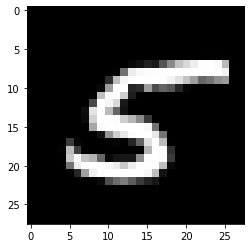

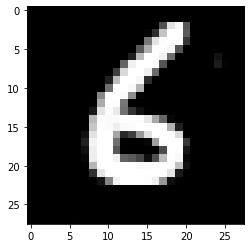

183th iteration gen_loss: 0.3557966649532318 dis_loss: 0.37004271149635315
183th iteration gen_loss: 0.42538559436798096 dis_loss: 0.46578601002693176
183th iteration gen_loss: 0.24155133962631226 dis_loss: 0.4123736619949341
183th iteration gen_loss: 0.48188748955726624 dis_loss: 0.40900808572769165
183th iteration gen_loss: 0.39254534244537354 dis_loss: 0.45192137360572815
183th iteration gen_loss: 0.45970815420150757 dis_loss: 0.4311721622943878
183th iteration gen_loss: 0.3809454143047333 dis_loss: 0.41483235359191895
183th iteration gen_loss: 0.1760099232196808 dis_loss: 0.35574695467948914
183th iteration gen_loss: 0.32274314761161804 dis_loss: 0.6074296832084656
183th iteration gen_loss: 0.23278369009494781 dis_loss: 0.44026386737823486
183th iteration gen_loss: 0.42062872648239136 dis_loss: 0.35965192317962646
183th iteration gen_loss: 0.47049659490585327 dis_loss: 0.4630342423915863


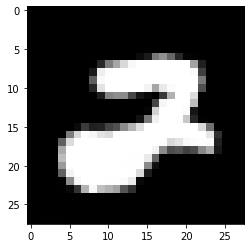

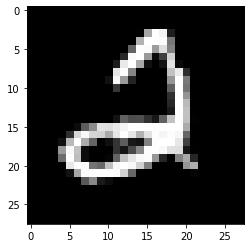

184th iteration gen_loss: 0.32326459884643555 dis_loss: 0.3355156183242798
184th iteration gen_loss: 0.552429735660553 dis_loss: 0.36271780729293823
184th iteration gen_loss: 0.25404688715934753 dis_loss: 0.5230661630630493
184th iteration gen_loss: 0.42328566312789917 dis_loss: 0.3780304193496704
184th iteration gen_loss: 0.36975112557411194 dis_loss: 0.42563652992248535
184th iteration gen_loss: 0.4566170275211334 dis_loss: 0.4247708320617676
184th iteration gen_loss: 0.3330914378166199 dis_loss: 0.2918277978897095
184th iteration gen_loss: 0.33132827281951904 dis_loss: 0.3632766604423523
184th iteration gen_loss: 0.3459779918193817 dis_loss: 0.4845511317253113
184th iteration gen_loss: 0.5714359283447266 dis_loss: 0.36175674200057983
184th iteration gen_loss: 0.37365782260894775 dis_loss: 0.4241487383842468
184th iteration gen_loss: 0.2226397693157196 dis_loss: 0.5548956394195557


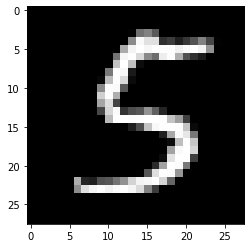

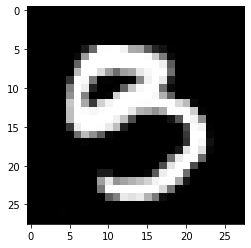

185th iteration gen_loss: 0.3626551032066345 dis_loss: 0.4685426950454712
185th iteration gen_loss: 0.3956541419029236 dis_loss: 0.4886399805545807
185th iteration gen_loss: 0.35153961181640625 dis_loss: 0.47573548555374146
185th iteration gen_loss: 0.41528746485710144 dis_loss: 0.4288521409034729
185th iteration gen_loss: 0.5043696761131287 dis_loss: 0.4922911524772644
185th iteration gen_loss: 0.41084837913513184 dis_loss: 0.4011470675468445
185th iteration gen_loss: 0.37544339895248413 dis_loss: 0.40937793254852295
185th iteration gen_loss: 0.38773414492607117 dis_loss: 0.5663138628005981
185th iteration gen_loss: 0.5304369926452637 dis_loss: 0.5840487480163574
185th iteration gen_loss: 0.5299411416053772 dis_loss: 0.4167213439941406
185th iteration gen_loss: 0.29422539472579956 dis_loss: 0.45008692145347595
185th iteration gen_loss: 0.3853302001953125 dis_loss: 0.41740506887435913


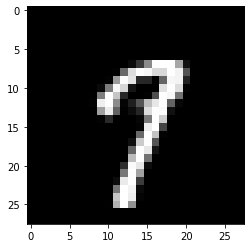

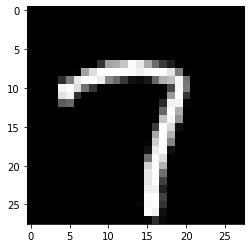

186th iteration gen_loss: 0.34499603509902954 dis_loss: 0.3322561979293823
186th iteration gen_loss: 0.4582919180393219 dis_loss: 0.45521754026412964
186th iteration gen_loss: 0.548196017742157 dis_loss: 0.3349805474281311
186th iteration gen_loss: 0.35483524203300476 dis_loss: 0.2824257016181946
186th iteration gen_loss: 0.2707682251930237 dis_loss: 0.3334416151046753
186th iteration gen_loss: 0.4222636818885803 dis_loss: 0.37124061584472656
186th iteration gen_loss: 0.5068556070327759 dis_loss: 0.43640226125717163
186th iteration gen_loss: 0.24504992365837097 dis_loss: 0.36934182047843933
186th iteration gen_loss: 0.36965033411979675 dis_loss: 0.39511755108833313
186th iteration gen_loss: 0.5588145852088928 dis_loss: 0.5434715747833252
186th iteration gen_loss: 0.45926618576049805 dis_loss: 0.411244660615921
186th iteration gen_loss: 0.3370920419692993 dis_loss: 0.36226120591163635


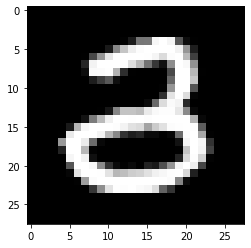

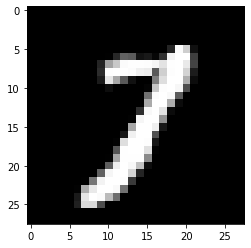

187th iteration gen_loss: 0.34597888588905334 dis_loss: 0.39104732871055603
187th iteration gen_loss: 0.4356182813644409 dis_loss: 0.3913077116012573
187th iteration gen_loss: 0.29715675115585327 dis_loss: 0.5269758701324463
187th iteration gen_loss: 0.5249571204185486 dis_loss: 0.32583749294281006
187th iteration gen_loss: 0.42869940400123596 dis_loss: 0.48438507318496704
187th iteration gen_loss: 0.3904271721839905 dis_loss: 0.41893818974494934
187th iteration gen_loss: 0.34330543875694275 dis_loss: 0.4262104332447052
187th iteration gen_loss: 0.23754817247390747 dis_loss: 0.507108747959137
187th iteration gen_loss: 0.6547217965126038 dis_loss: 0.5426026582717896
187th iteration gen_loss: 0.5850440263748169 dis_loss: 0.38917672634124756
187th iteration gen_loss: 0.24757888913154602 dis_loss: 0.4861386716365814
187th iteration gen_loss: 0.2592122554779053 dis_loss: 0.45952853560447693


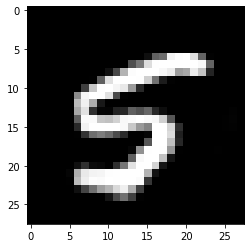

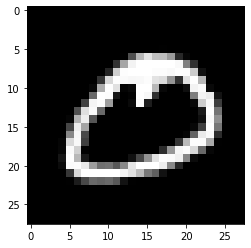

188th iteration gen_loss: 0.35610267519950867 dis_loss: 0.42001378536224365
188th iteration gen_loss: 0.4297110140323639 dis_loss: 0.39251887798309326
188th iteration gen_loss: 0.38825279474258423 dis_loss: 0.3850894272327423
188th iteration gen_loss: 0.23842179775238037 dis_loss: 0.41595613956451416
188th iteration gen_loss: 0.44118747115135193 dis_loss: 0.33773523569107056
188th iteration gen_loss: 0.3897935748100281 dis_loss: 0.4248967170715332
188th iteration gen_loss: 0.3585566580295563 dis_loss: 0.3054217994213104
188th iteration gen_loss: 0.432535320520401 dis_loss: 0.40155357122421265
188th iteration gen_loss: 0.3273758590221405 dis_loss: 0.4259527325630188
188th iteration gen_loss: 0.38570380210876465 dis_loss: 0.37064099311828613
188th iteration gen_loss: 0.314840167760849 dis_loss: 0.37785688042640686
188th iteration gen_loss: 0.29214638471603394 dis_loss: 0.4989922344684601


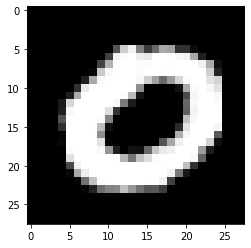

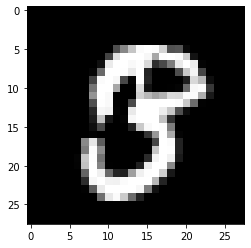

189th iteration gen_loss: 0.45317313075065613 dis_loss: 0.412922739982605
189th iteration gen_loss: 0.29039430618286133 dis_loss: 0.4059416949748993
189th iteration gen_loss: 0.3424776494503021 dis_loss: 0.4490067958831787
189th iteration gen_loss: 0.37170127034187317 dis_loss: 0.5317440032958984
189th iteration gen_loss: 0.35744231939315796 dis_loss: 0.46707913279533386
189th iteration gen_loss: 0.46827468276023865 dis_loss: 0.3780401349067688
189th iteration gen_loss: 0.2854195237159729 dis_loss: 0.4552297592163086
189th iteration gen_loss: 0.25723791122436523 dis_loss: 0.4663155674934387
189th iteration gen_loss: 0.318877637386322 dis_loss: 0.3799838423728943
189th iteration gen_loss: 0.34957611560821533 dis_loss: 0.333324134349823
189th iteration gen_loss: 0.3293924629688263 dis_loss: 0.49897873401641846
189th iteration gen_loss: 0.5042054057121277 dis_loss: 0.41149815917015076


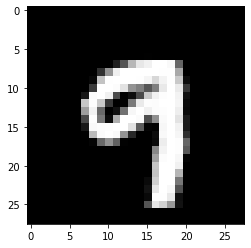

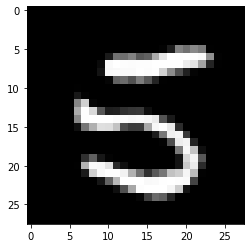

190th iteration gen_loss: 0.30746912956237793 dis_loss: 0.42205810546875
190th iteration gen_loss: 0.28878703713417053 dis_loss: 0.3176512122154236
190th iteration gen_loss: 0.2827361524105072 dis_loss: 0.4044051170349121
190th iteration gen_loss: 0.3366503417491913 dis_loss: 0.4150612950325012
190th iteration gen_loss: 0.3380982279777527 dis_loss: 0.4376523494720459
190th iteration gen_loss: 0.46417558193206787 dis_loss: 0.46877172589302063
190th iteration gen_loss: 0.29224470257759094 dis_loss: 0.38151299953460693
190th iteration gen_loss: 0.46015891432762146 dis_loss: 0.26702165603637695
190th iteration gen_loss: 0.3760744631290436 dis_loss: 0.30504584312438965
190th iteration gen_loss: 0.28269773721694946 dis_loss: 0.37831538915634155
190th iteration gen_loss: 0.41735708713531494 dis_loss: 0.4287477135658264
190th iteration gen_loss: 0.3257937431335449 dis_loss: 0.47463953495025635


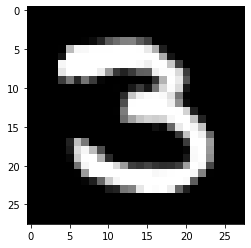

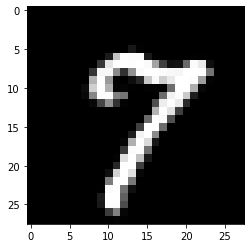

191th iteration gen_loss: 0.2761244475841522 dis_loss: 0.5441104173660278
191th iteration gen_loss: 0.5329171419143677 dis_loss: 0.4595290422439575
191th iteration gen_loss: 0.44628775119781494 dis_loss: 0.47902050614356995
191th iteration gen_loss: 0.43471574783325195 dis_loss: 0.4547654390335083
191th iteration gen_loss: 0.35852599143981934 dis_loss: 0.2799528241157532
191th iteration gen_loss: 0.30031707882881165 dis_loss: 0.3518805503845215
191th iteration gen_loss: 0.2576819360256195 dis_loss: 0.5051717162132263
191th iteration gen_loss: 0.32215967774391174 dis_loss: 0.4076319932937622
191th iteration gen_loss: 0.31543537974357605 dis_loss: 0.5490458011627197
191th iteration gen_loss: 0.42903196811676025 dis_loss: 0.546639084815979
191th iteration gen_loss: 0.4180186688899994 dis_loss: 0.30721408128738403
191th iteration gen_loss: 0.406928688287735 dis_loss: 0.3634490370750427


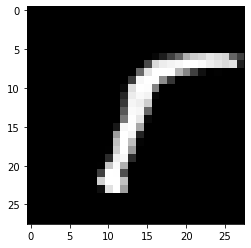

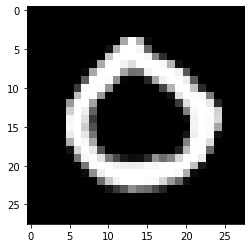

192th iteration gen_loss: 0.3120768368244171 dis_loss: 0.43100669980049133
192th iteration gen_loss: 0.4933328926563263 dis_loss: 0.4284282922744751
192th iteration gen_loss: 0.41687774658203125 dis_loss: 0.3446728587150574
192th iteration gen_loss: 0.4088969826698303 dis_loss: 0.42084839940071106
192th iteration gen_loss: 0.2981284260749817 dis_loss: 0.3114434480667114
192th iteration gen_loss: 0.4839697480201721 dis_loss: 0.38983285427093506
192th iteration gen_loss: 0.41125524044036865 dis_loss: 0.4092163145542145
192th iteration gen_loss: 0.12027429044246674 dis_loss: 0.5162972211837769
192th iteration gen_loss: 0.40324223041534424 dis_loss: 0.4050688147544861
192th iteration gen_loss: 0.2465088963508606 dis_loss: 0.458373486995697
192th iteration gen_loss: 0.33307981491088867 dis_loss: 0.5157944560050964
192th iteration gen_loss: 0.3814777433872223 dis_loss: 0.5029575228691101


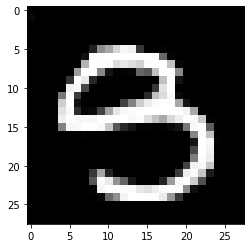

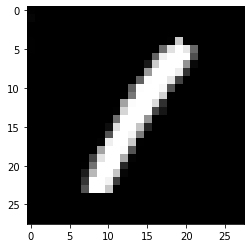

193th iteration gen_loss: 0.40476858615875244 dis_loss: 0.5080056190490723
193th iteration gen_loss: 0.4362603724002838 dis_loss: 0.38350826501846313
193th iteration gen_loss: 0.4729961156845093 dis_loss: 0.45418840646743774
193th iteration gen_loss: 0.6151307821273804 dis_loss: 0.3747459053993225
193th iteration gen_loss: 0.20782902836799622 dis_loss: 0.36594632267951965
193th iteration gen_loss: 0.29742759466171265 dis_loss: 0.31854623556137085
193th iteration gen_loss: 0.2616240084171295 dis_loss: 0.4665377140045166
193th iteration gen_loss: 0.45624732971191406 dis_loss: 0.5602881908416748
193th iteration gen_loss: 0.26069125533103943 dis_loss: 0.5027997493743896
193th iteration gen_loss: 0.35614657402038574 dis_loss: 0.46487510204315186
193th iteration gen_loss: 0.3806370496749878 dis_loss: 0.45707982778549194
193th iteration gen_loss: 0.4279893636703491 dis_loss: 0.35508573055267334


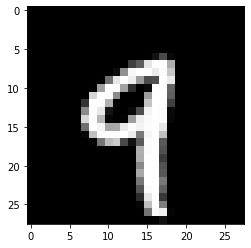

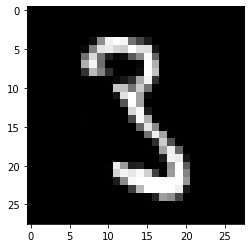

194th iteration gen_loss: 0.5273513793945312 dis_loss: 0.36435630917549133
194th iteration gen_loss: 0.3572421967983246 dis_loss: 0.37405192852020264
194th iteration gen_loss: 0.3380449712276459 dis_loss: 0.3453789949417114
194th iteration gen_loss: 0.2862517237663269 dis_loss: 0.445242315530777
194th iteration gen_loss: 0.5255066156387329 dis_loss: 0.4662827253341675
194th iteration gen_loss: 0.37135782837867737 dis_loss: 0.40761440992355347
194th iteration gen_loss: 0.38350439071655273 dis_loss: 0.36102449893951416
194th iteration gen_loss: 0.39601877331733704 dis_loss: 0.567706823348999
194th iteration gen_loss: 0.6287029385566711 dis_loss: 0.3295768201351166
194th iteration gen_loss: 0.3246246576309204 dis_loss: 0.48445096611976624
194th iteration gen_loss: 0.46819838881492615 dis_loss: 0.36619794368743896
194th iteration gen_loss: 0.4051588475704193 dis_loss: 0.40352946519851685


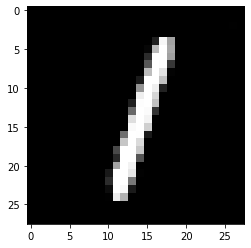

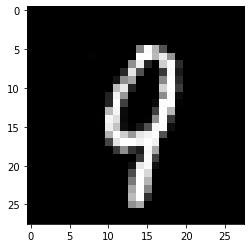

195th iteration gen_loss: 0.44829055666923523 dis_loss: 0.4565715789794922
195th iteration gen_loss: 0.20391018688678741 dis_loss: 0.4469645619392395
195th iteration gen_loss: 0.3075098693370819 dis_loss: 0.40823179483413696
195th iteration gen_loss: 0.5062522292137146 dis_loss: 0.5727174282073975
195th iteration gen_loss: 0.5043620467185974 dis_loss: 0.4724324941635132
195th iteration gen_loss: 0.4311516582965851 dis_loss: 0.42458629608154297
195th iteration gen_loss: 0.4097959101200104 dis_loss: 0.30719512701034546
195th iteration gen_loss: 0.231410950422287 dis_loss: 0.4737860858440399
195th iteration gen_loss: 0.39196524024009705 dis_loss: 0.33662617206573486
195th iteration gen_loss: 0.2029188871383667 dis_loss: 0.5640151500701904
195th iteration gen_loss: 0.23275987803936005 dis_loss: 0.36178499460220337
195th iteration gen_loss: 0.35990867018699646 dis_loss: 0.4836180806159973


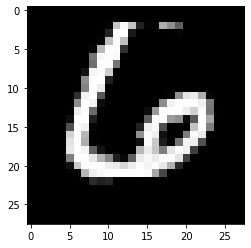

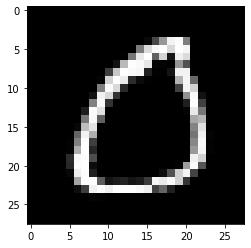

196th iteration gen_loss: 0.3943875730037689 dis_loss: 0.29327836632728577
196th iteration gen_loss: 0.48425954580307007 dis_loss: 0.3601428270339966
196th iteration gen_loss: 0.4626331925392151 dis_loss: 0.37533682584762573
196th iteration gen_loss: 0.3919968008995056 dis_loss: 0.30368733406066895
196th iteration gen_loss: 0.3826291561126709 dis_loss: 0.4806748330593109
196th iteration gen_loss: 0.3682480454444885 dis_loss: 0.4089844226837158
196th iteration gen_loss: 0.48329389095306396 dis_loss: 0.32107314467430115
196th iteration gen_loss: 0.32137206196784973 dis_loss: 0.44568687677383423
196th iteration gen_loss: 0.49282294511795044 dis_loss: 0.4244598150253296
196th iteration gen_loss: 0.4946729838848114 dis_loss: 0.3682861328125
196th iteration gen_loss: 0.3734566867351532 dis_loss: 0.3350253403186798
196th iteration gen_loss: 0.5147296190261841 dis_loss: 0.5187292695045471


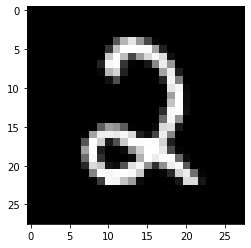

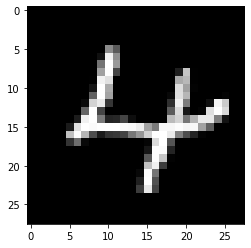

197th iteration gen_loss: 0.44133222103118896 dis_loss: 0.3267478346824646
197th iteration gen_loss: 0.4175766706466675 dis_loss: 0.39825400710105896
197th iteration gen_loss: 0.34133896231651306 dis_loss: 0.33495059609413147
197th iteration gen_loss: 0.6406058073043823 dis_loss: 0.5331225395202637
197th iteration gen_loss: 0.3134501576423645 dis_loss: 0.43442606925964355
197th iteration gen_loss: 0.40214988589286804 dis_loss: 0.3926255404949188
197th iteration gen_loss: 0.4349074363708496 dis_loss: 0.42286378145217896
197th iteration gen_loss: 0.36784568428993225 dis_loss: 0.4364057183265686
197th iteration gen_loss: 0.5087377429008484 dis_loss: 0.4033493995666504
197th iteration gen_loss: 0.3569558560848236 dis_loss: 0.37964773178100586
197th iteration gen_loss: 0.36528846621513367 dis_loss: 0.3933260440826416
197th iteration gen_loss: 0.2219783365726471 dis_loss: 0.5293371081352234


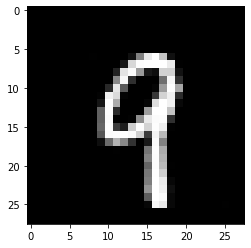

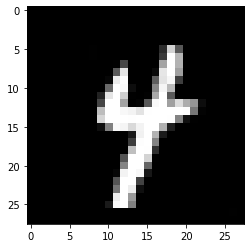

198th iteration gen_loss: 0.600781261920929 dis_loss: 0.46854668855667114
198th iteration gen_loss: 0.2873770594596863 dis_loss: 0.38153114914894104
198th iteration gen_loss: 0.5128013491630554 dis_loss: 0.4239542484283447
198th iteration gen_loss: 0.32082584500312805 dis_loss: 0.33412155508995056
198th iteration gen_loss: 0.30245456099510193 dis_loss: 0.35132378339767456
198th iteration gen_loss: 0.485760897397995 dis_loss: 0.47188371419906616
198th iteration gen_loss: 0.28702983260154724 dis_loss: 0.4532853364944458
198th iteration gen_loss: 0.365634560585022 dis_loss: 0.45648568868637085
198th iteration gen_loss: 0.28229236602783203 dis_loss: 0.40080827474594116
198th iteration gen_loss: 0.5017108917236328 dis_loss: 0.3393416702747345
198th iteration gen_loss: 0.32705122232437134 dis_loss: 0.47041696310043335
198th iteration gen_loss: 0.18311645090579987 dis_loss: 0.5045351386070251


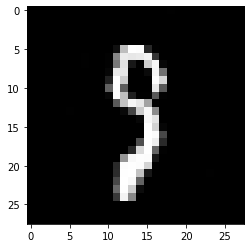

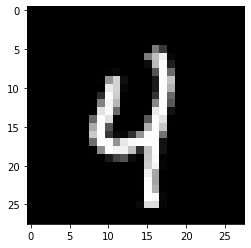

199th iteration gen_loss: 0.505840003490448 dis_loss: 0.37182193994522095
199th iteration gen_loss: 0.36160802841186523 dis_loss: 0.4695643484592438
199th iteration gen_loss: 0.4211104214191437 dis_loss: 0.21349141001701355
199th iteration gen_loss: 0.4620561897754669 dis_loss: 0.37642669677734375
199th iteration gen_loss: 0.3203524351119995 dis_loss: 0.4530646800994873
199th iteration gen_loss: 0.40363243222236633 dis_loss: 0.4093977212905884
199th iteration gen_loss: 0.5932957530021667 dis_loss: 0.4137428402900696
199th iteration gen_loss: 0.25626277923583984 dis_loss: 0.32544052600860596
199th iteration gen_loss: 0.3725225329399109 dis_loss: 0.43156811594963074
199th iteration gen_loss: 0.4637433588504791 dis_loss: 0.3136335015296936
199th iteration gen_loss: 0.4217551350593567 dis_loss: 0.4896593391895294
199th iteration gen_loss: 0.3164808750152588 dis_loss: 0.37209367752075195


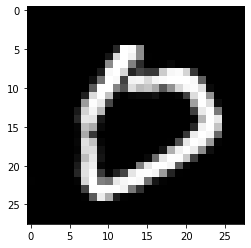

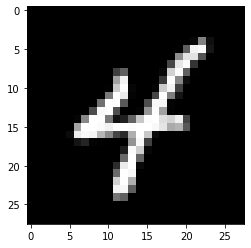

In [9]:
# train

for i in range(epoch):
    for j,(image,label) in enumerate(train_loader):
        image = Variable(image).cuda()
        
        # generator
        gen_optim.zero_grad()
        
        z = Variable(init.normal(torch.Tensor(batch_size,100),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake,ones_label)) # fake classified as real
        gen_loss.backward(retain_graph=True)
        gen_optim.step()
    
        # discriminator
        dis_optim.zero_grad()
        
        z = Variable(init.normal(torch.Tensor(batch_size,100),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)
        
        dis_real,_ = discriminator.forward(image)
        dis_loss = torch.sum(loss_func(dis_fake,zeros_label)) + torch.sum(loss_func(dis_real,ones_label))
        dis_loss.backward()
        dis_optim.step()
    
        # model save
        if j % 50 == 0:
            #print(gen_loss,dis_loss)
            torch.save(generator.state_dict(),'./saved_model/generator.pkl')
            torch.save(discriminator.state_dict(),'./saved_model/discriminator.pkl')


            print("{}th iteration gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))
            v_utils.save_image(gen_fake.data[0:25],"./result/gen_{}_{}.png".format(i,j), nrow=5)
            
    image_check(gen_fake.cpu())

### Anomaly Detection 

#### Define a function to calculate anomaly score

In [10]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data
def Anomaly_score(x, G_z, Lambda=0.1):
    _,x_feature = discriminator(x)
    _,G_z_feature = discriminator(G_z)
    
    residual_loss = torch.sum(torch.abs(x-G_z))
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature))
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    return total_loss

In [23]:
#mnist_test.__dict__.keys()

## Test the model

##### Define Test Data

In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

start_idx = 64
test_size = 8

test_data_mnist = mnist_test.__dict__['data'][start_idx:start_idx+test_size]
test_data_mnist = test_data_mnist.view(test_size,1,28,28).type_as(torch.FloatTensor())
test_data_mnist.size()

torch.Size([8, 1, 28, 28])

##### Restore model for testing

In [14]:
generator = nn.DataParallel(Generator(),device_ids=[0])
discriminator = nn.DataParallel(Discriminator(),device_ids=[0])

#generator, discriminator

# model restore if any

try:
    generator.load_state_dict(torch.load('./saved_model/generator.pkl'))
    discriminator.load_state_dict(torch.load('./saved_model/discriminator.pkl'))

    print("\n--------model restored--------\n")

except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



#### Test with Normal (=MNIST) Data

In [15]:
z = Variable(init.normal(torch.zeros(test_size,100),mean=0,std=0.1),requires_grad=True)
z_optimizer = torch.optim.Adam([z],lr=1e-4)

gen_fake = generator(z.cuda())
loss = Anomaly_score(Variable(test_data_mnist).cuda(),gen_fake)
print(loss)

tensor(203669.4062, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """Entry point for launching an IPython kernel.


##### Latent Z optimization

In [16]:
for i in range(5000):
    gen_fake = generator(z.cuda())
    loss = Anomaly_score(Variable(test_data_mnist).cuda(),gen_fake,Lambda=0.01)
    loss.backward()
    z_optimizer.step()
    
    if i%100==0:
        print(loss.cpu().data)
        '''
        target = test_data_mnist[1,0,:,:].numpy()
        plt.imshow(target,cmap="gray")
        plt.show()
        
        img=gen_fake.cpu().data[1,0,:,:].numpy()
        plt.imshow(img,cmap='gray')
        plt.show()
        '''

tensor(222977.3906)
tensor(222832.1250)
tensor(222723.4062)
tensor(222644.5469)
tensor(222582.6250)
tensor(222561.4688)
tensor(222533.6875)
tensor(222497.6406)
tensor(222472.8125)
tensor(222466.4375)
tensor(222436.8594)
tensor(222415.5625)
tensor(222434.5938)
tensor(222410.6250)
tensor(222407.8125)
tensor(222395.1875)
tensor(222379.7969)
tensor(222374.6875)
tensor(222372.1250)
tensor(222370.4531)
tensor(222354.9062)
tensor(222348.8438)
tensor(222343.6406)
tensor(222322.4219)
tensor(222325.4531)
tensor(222319.5625)
tensor(222312.9688)
tensor(222313.5625)
tensor(222298.1875)
tensor(222301.0469)
tensor(222291.8281)
tensor(222288.7656)
tensor(222294.4531)
tensor(222284.0625)
tensor(222281.5781)
tensor(222283.6250)
tensor(222281.8594)
tensor(222275.0469)
tensor(222268.3906)
tensor(222270.6094)
tensor(222266.8125)
tensor(222268.4844)
tensor(222267.2188)
tensor(222259.9844)
tensor(222256.7969)
tensor(222250.4688)
tensor(222246.5781)
tensor(222245.5625)
tensor(222243.7188)
tensor(222239.6562)


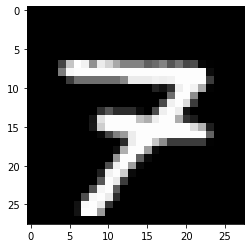

real data


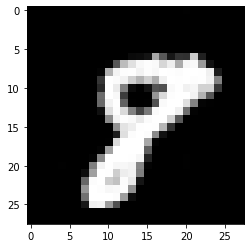

generated data

------------------------------------



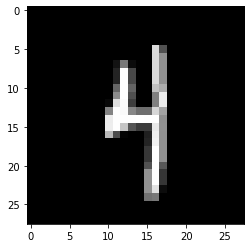

real data


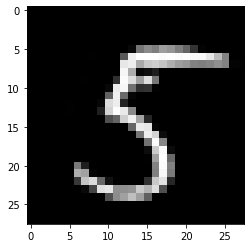

generated data

------------------------------------



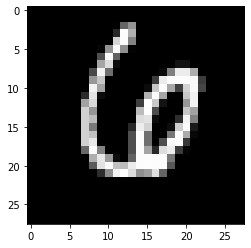

real data


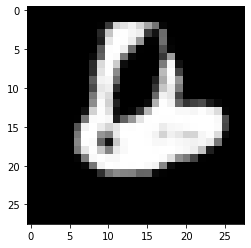

generated data

------------------------------------



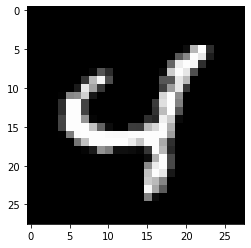

real data


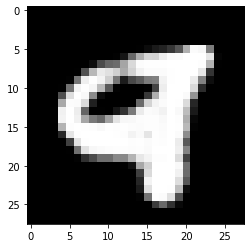

generated data

------------------------------------



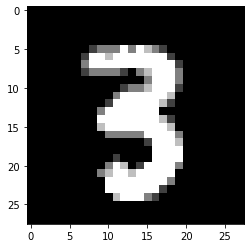

real data


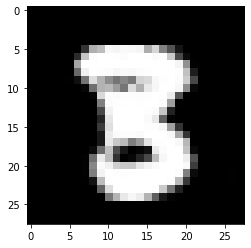

generated data

------------------------------------



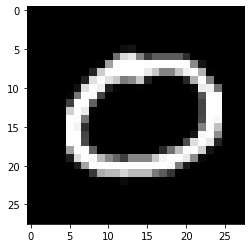

real data


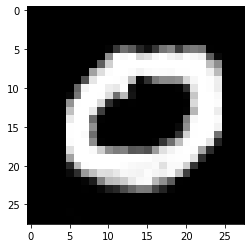

generated data

------------------------------------



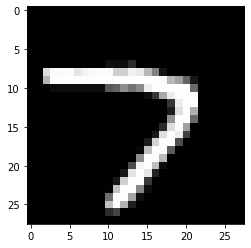

real data


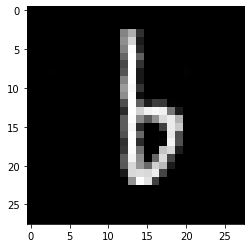

generated data

------------------------------------



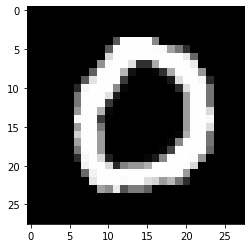

real data


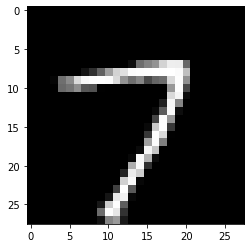

generated data

------------------------------------



In [17]:
for idx in range(test_size):
    target = test_data_mnist[idx,0,:,:].numpy()
    plt.imshow(target,cmap="gray")
    plt.show()
    print("real data")

    img=gen_fake.cpu().data[idx,0,:,:].numpy()
    plt.imshow(img,cmap='gray')
    plt.show()
    print("generated data")
    print("\n------------------------------------\n")